## Environment Set Up

In [1]:
# Install packages not in Colab by default
!pip install vaderSentiment
!pip install textstat
!pip install flwr

     |████████████████████████████████| 125 kB 30.2 MB/s 
     |████████████████████████████████| 101 kB 10.4 MB/s 
     |████████████████████████████████| 2.0 MB 67.4 MB/s 
     |████████████████████████████████| 229 kB 29.5 MB/s 


In [2]:
# Import packages
import pickle
import sys
import string
import re
import nltk
import seaborn
import os
import time
import warnings
import random
import nltk.stem.porter
import pandas as pd
import numpy as np
import flwr as fl
import threading
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, log_loss, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from typing import Tuple, Union, List, Dict, Optional
from flwr.server.criterion import Criterion
from flwr.server.client_proxy import ClientProxy
from google.colab import drive
from multiprocessing import Process, Manager
from multiprocessing.managers import ListProxy
from math import ceil
from statistics import mean
%matplotlib inline

In [3]:
# Mount external storage
drive.mount('/content/drive')

Mounted at /content/drive


## Preliminary Data Analysis

In [4]:
# Deserialize Pandas DataFrame from pickle file
df = pd.read_pickle(open("/content/drive/MyDrive/labeled_data.p", mode='rb'))

In [5]:
# Describe content, size and format of the data
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [6]:
# Generate descriptive statistics
df.describe()

,count,hate_speech,offensive_language,neither
count,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247
std,0.883060,0.631851,1.399459,1.113299
min,3.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000
50%,3.000000,0.000000,3.000000,0.000000
75%,3.000000,0.000000,3.000000,0.000000
max,9.000000,7.000000,9.000000,9.000000


In [7]:
# Get feature names 
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

Key:

count = number of CrowdFlower users who coded each tweet (at least 3; more users coded a tweet when judgments were determined to be unreliable by CF)


hate_speech = number of CF users who coded the tweet as hate speech


offensive_language = number of CF users who coded the tweet as offensive but not hate speech


neither = number of CF users who coded the tweet as neither offensive nor hate speech


class = class label determined by majority rule:

* 0 : hate speech
* 1 : offensive  language
* 2 : neither

tweet = tweet text


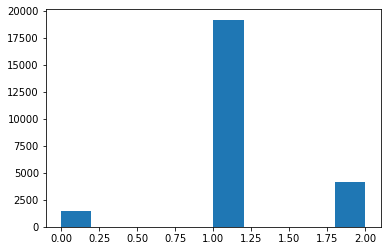

In [8]:
# Plot distribution of samples across classes
plt.hist(df['class'])
plt.show()

The histogram shows the imbalanced nature of the classification problem; most tweets containing "hateful" words, as defined by Hatebase, were coded as offensive by CF coders. More tweets were considered neither hate speech nor offensive than were considered hate speech.

## Data Preprocessing

In [9]:
# Select data for preprocessing and transformation
tweets=df.tweet

In [10]:
# Create list of stopwords 
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# Create reusable stemmer
stemmer = nltk.stem.porter.PorterStemmer()

In [12]:
# Define functions for preprocessing data
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

## Feature Engineering

### Automatic Feature Extraction

In [13]:
# Construct tfidf matrix and get relevant scores
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


In [14]:
# Get POS tags for tweets and save as a string
nltk.download('averaged_perceptron_tagger')
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [15]:
# Construct POS TF matrix and get vocab dict
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}

### Manual Feature Construction

In [16]:
# Create reusable sentiment analyzer
sentiment_analyzer = VS()

In [17]:
# Define functions for devising features
def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) # Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    # Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    # Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [18]:
# Construct features
other_feats = get_feature_array(tweets)

## Feature Selection

In [19]:
# Join automatically extracted features and manually constructed features together
X = np.concatenate([tfidf,pos,other_feats],axis=1)

In [20]:
# Get dimensions of the data
X.shape

(24783, 4023)

The data is high dimensional. There is an exponential decrease in predictive power for each additional variable in a multivariate model, known as the curse of dimensionality. Therefore, the dimensionality of the data should be reduced.

## Centralized Model

In [21]:
# Encode class labels
y = df['class'].astype(int)

In [22]:
# Reduce dimensionality of data. Specify solver as 'liblinear' because default solver changed to 'lbfgs' in 0.22.
feature_transformer = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1", C=0.01, solver='liblinear'))

X_ = feature_transformer.fit_transform(X,y)

In [23]:
# Get reduced dimensions of the data
X_.shape

(24783, 466)

In [24]:
# Generate train/test split of 9/1. Initialise with random seed for reproduciblability.
X_train, X_test, y_train, y_test = train_test_split(X_, y, random_state=42, test_size=0.1, stratify=y)

As classification problem is imbalanced, [it's desirable](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms//) for the train/test split to preserve the same proportions of examples in each class as observed in the original dataset (stratified split).

In [25]:
# Create model. Change hyperparameters to ensure control variables remain constant. Change solver to the new default solver, lbfgs.
# Increase `max_iter` as lbfgs takes longer to converge. Change framework used for multi class classification to multinomial.
# See comments in `start_flower_client` for details.
classifier = LogisticRegression(class_weight='balanced',penalty='l2', C=0.01, max_iter=1500)

In [26]:
y_train.value_counts()

1    17270
2     3747
0     1287
Name: class, dtype: int64

In [27]:
# Train model
model = classifier.fit(X_train, y_train)

### Model Testing

In [28]:
# Test model
y_preds = model.predict(X_test)

In [29]:
# Generate test report
report = classification_report(y_test, y_preds)
print(report.rsplit("\n",2)[0])

              precision    recall  f1-score   support

           0       0.25      0.69      0.36       143
           1       0.96      0.75      0.84      1920
           2       0.62      0.87      0.72       416

    accuracy                           0.77      2479
   macro avg       0.61      0.77      0.64      2479


There is a class-imbalance in the dataset; the hate speech class (0) and neither class (2) are most important to get right, and they are under-represented. Offensive language class (1) is over-represented. Therefore, [macro average is preferable](https://www.mariakhalusova.com/posts/2019-04-17-ml-model-evaluation-metrics-p2/#micro--macro--weighted-averaged-precision) over misleading weighted average.

F1-score is used rather than AUROC because AUROC averages over all possible discrimination thresholds, [which is misleading](https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc) in the case of class-imbalanced data. In contrast, F-1 score keeps a balance between Precision and Recall.

In [30]:
# Define function for plotting confusion matrix
def plot_confusion_matrix(y, y_preds):

  matrix = confusion_matrix(y,y_preds)
  matrix_proportions = np.zeros((3,3))
  for i in range(0,3):
    matrix_proportions[i,:] = matrix[i,:]/float(matrix[i,:].sum())
  names=['Hate','Offensive','Neither']
  confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
  plt.figure(figsize=(5,5))
  seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'True categories',fontsize=14)
  plt.xlabel(r'Predicted categories',fontsize=14)
  plt.tick_params(labelsize=12)

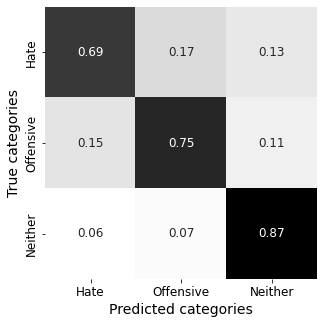

In [31]:
# Plot confusion matrix
plot_confusion_matrix(y_test,y_preds)

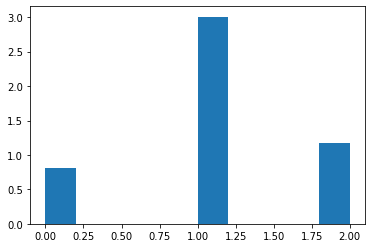

In [34]:
# Plot distribution of estimates. Set the density parameter to True to normalize bin heights so that the integral of the histogram is 1.
# The resulting histogram is an approximation of the probability density function. This facilitates comparison between the distribution 
# of estimates and true distribution.
plt.hist(y_preds, density=True)
plt.show()

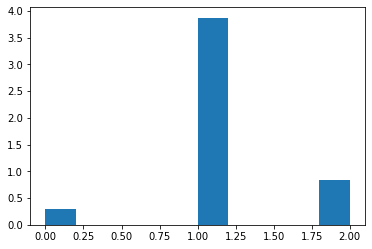

In [35]:
# Plot true distribution
plt.hist(y, density=True)
plt.show()

# Single-Machine Simulation of Federated Learning System

We use a controlled environment that is suitable for experiments. We assume
a synchronous update scheme that proceeds in rounds of
communication. There is a fixed set of $K$ clients, each
with a fixed local dataset. At the beginning of each round,
a fraction of random clients are selected, and the server
sends the current global model parameters to each of these clients. Each selected client then trains its local model on its local dataset, and sends an
update to the server. The server then applies these updates
to the global model, and the cycle repeats.

In [36]:
# Initialize global experiment config
DATA_PARTITIONING_STRATEGY = ""
DATA_PARTITIONING_RANDOM_SEED = 1
DIRICHLET_DISTRIBUTION_PARAM = 10
NUMBER_OF_CLIENTS = 20
MIN_AVAILABLE_CLIENTS = 20
NUMBER_OF_FL_ROUNDS = 50
LOCAL_EPOCHS = ceil(1500 / NUMBER_OF_FL_ROUNDS)
MIN_FIT_CLIENTS = 14
FRACTION_FIT = 0.7
FRACTION_FIT_RANDOM_SEED = 1

Key:

DATA_PARTITIONING_STRATEGY - strategy for how samples are distributed over clients

DATA_PARTITIONING_RANDOM_SEED - seed for initializing the random data partition generator, this allows reproducability of results and is varied in experiment repetitions to evaluate the confidence interval

DIRICHLET_DISTRIBUTION_PARAM - distribution parameter of the Dirichlet distribution used in particular data partitioning strategies

NUMBER_OF_CLIENTS - Total number of clients participating in the FL

MIN_AVAILABLE_CLIENTS - minimum number of clients that must be connected to the server before FL can begin

NUMBER_OF_FL_ROUNDS - number of FL rounds, set to a sufficiently large number to limit number of local epochs so that the convergence behaviour of the FL algorithm can be observed

LOCAL_EPOCHS - Number of complete passes over local training data performed by clients during a training round, bounded by 1500 as that is how long it takes for the solver to converge

MIN_FIT_CLIENTS - minimum number of clients that must be connected to the server before a training round can begin

FRACTION_FIT - fraction of random clients selected to participate in a training round

FRACTION_FIT_RANDOM_SEED - seed for initializing the random sampling used to select clients for participation in a training round, this allows reproducability of results and control of the variable across experiments



## Utility Functions

In [37]:
XY = Tuple[np.ndarray, np.ndarray]
Dataset = Tuple[XY, XY]
LogRegParams = Union[XY, Tuple[np.ndarray]]
XYList = List[XY]


def get_model_parameters(model: LogisticRegression) -> LogRegParams:
#Returns the paramters of a sklearn LogisticRegression model.
    if model.fit_intercept: # model.fit_intercept is true by default
        params = (model.coef_, model.intercept_)
    else:
        params = (model.coef_,)
    return params


def set_model_params(
    model: LogisticRegression, params: LogRegParams
) -> LogisticRegression:
#Sets the parameters of a sklean LogisticRegression model.
    model.coef_ = params[0]
    if model.fit_intercept: # model.fit_intercept is true by default
        model.intercept_ = params[1]
    return model


def set_initial_params(model: LogisticRegression):
#Sets initial parameters as zeros Required since model params are
#uninitialized until model.fit is called.
#But server asks for initial parameters from clients at launch. Refer
#to sklearn.linear_model.LogisticRegression documentation for more
#information.

    n_classes = 3  # our dataset has 3 classes
    n_features = 466  # Number of features in dataset after feature selection by transformer
    model.classes_ = np.array([i for i in range(n_classes)])

    model.coef_ = np.zeros((n_classes, n_features))
    if model.fit_intercept:
        model.intercept_ = np.zeros((n_classes,))


def get_partitions(x_train, y_train):
    np.random.seed(DATA_PARTITIONING_RANDOM_SEED)

    n_train = y_train.shape[0]

    if DATA_PARTITIONING_STRATEGY == "iid":
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, NUMBER_OF_CLIENTS)
        net_dataidx_map = {i: batch_idxs[i] for i in range(NUMBER_OF_CLIENTS)}
    elif DATA_PARTITIONING_STRATEGY == "noniid-distribution-based-label-imbalance":
        min_size = 0
        min_require_size = 10
        K = 3
        N = y_train.shape[0]
        net_dataidx_map = {}

        while min_size < min_require_size:
            idx_batch = [[] for _ in range(NUMBER_OF_CLIENTS)]

            for k in range(K):
                idx_k = np.where(y_train == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(DIRICHLET_DISTRIBUTION_PARAM, NUMBER_OF_CLIENTS))
                proportions = np.array([p * (len(idx_j) < N / NUMBER_OF_CLIENTS) for p, idx_j in zip(proportions, idx_batch)])
                proportions = proportions / proportions.sum()
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
                min_size = min([len(idx_j) for idx_j in idx_batch])

        for j in range(NUMBER_OF_CLIENTS):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]
    elif DATA_PARTITIONING_STRATEGY == "noniid-quantity-based-label-imbalance1" or DATA_PARTITIONING_STRATEGY == "noniid-quantity-based-label-imbalance2":
        num = eval(DATA_PARTITIONING_STRATEGY[37:]) # number of distinct labels per client
        K = 3 # total number of labels
        times = [0 for _ in range(K)] # holds the number of parties to which each label ID is assigned
        contain = [[] for _ in range(NUMBER_OF_CLIENTS)] # holds the buckets of num label IDs assigned to each party

        for i in range(K): # ensure each label ID is assigned
            bucket = contain[np.random.randint(NUMBER_OF_CLIENTS)]
            while len(bucket) == num:
                bucket = contain[np.random.randint(NUMBER_OF_CLIENTS)]
            bucket.append(i)
            times[i] += 1

        for bucket in contain: # randomly assign num different distinct label IDs to each party
            j = len(bucket)
            while j < num:
                ind = np.random.randint(K)
                if ind not in bucket:
                    bucket.append(ind)
                    times[ind] += 1
                    j += 1

        net_dataidx_map ={i: np.ndarray(0, dtype=np.int64) for i in range(NUMBER_OF_CLIENTS)}

        # For the samples of each label, randomly and equally divide them into the parties
        # which own the label, such that there is no overlap between the samples of different parties
        for i in range(K):
            idx_k = np.where(y_train == i)[0]
            np.random.shuffle(idx_k)
            split = np.array_split(idx_k,times[i])
            ids = 0
            for j in range(NUMBER_OF_CLIENTS):
                if i in contain[j]:
                    net_dataidx_map[j]=np.append(net_dataidx_map[j],split[ids])
                    ids += 1

    elif DATA_PARTITIONING_STRATEGY == "iid-quantity-skew":
        idxs = np.random.permutation(n_train)
        min_size = 0
        while min_size < 10:
            proportions = np.random.dirichlet(np.repeat(DIRICHLET_DISTRIBUTION_PARAM, NUMBER_OF_CLIENTS))
            proportions = proportions/proportions.sum()
            min_size = np.min(proportions*len(idxs))
        proportions = (np.cumsum(proportions)*len(idxs)).astype(int)[:-1]
        batch_idxs = np.split(idxs, proportions)
        net_dataidx_map = {i: batch_idxs[i] for i in range(NUMBER_OF_CLIENTS)}

    return [(x_train[net_dataidx_map[idx]], pd.Series(y_train[net_dataidx_map[idx]])) for idx in range(NUMBER_OF_CLIENTS)]

## Server Functions

In [38]:
def fit_round(rnd: int) -> Dict:
  """Send fit round number to client."""

  return {"rnd": rnd}

# get_eval_fn is a closure factory function that creates a closure consisting of the inner function evaluate together with its enclosing environment.
# The closure can modify the mutable objects aka dynamic enclosing state, such as model, within its enclosing state
def get_eval_fn(model: LogisticRegression, y_preds: ListProxy, test_accs: ListProxy):
    """Return an evaluation function for server-side evaluation."""

    # The `evaluate` function will be called after every training round.
    def evaluate(parameters: fl.common.Weights):
        print("Beginning centralized evaluation")
        print("Updating aggregate model with the latest parameters")
        # Update model with the latest parameters
        set_model_params(model, parameters)
        print(f"Class labels known to classifier: {model.classes_}")
        print("Predicting class labels for samples in X_test")
        # Predict class labels for samples in X_test
        predictions = model.predict(X_test)
        y_preds.append(predictions)
        print(classification_report(y_test, predictions))
        # Calculate probability estimates
        print("Calculating probability estimates")
        prob_estimates = model.predict_proba(X_test)
        print(f"Probability estimates: {prob_estimates}")
        # Calculate cross-entropy loss
        print("Calculating cross-entropy loss")
        loss = log_loss(y_test, prob_estimates)
        print("Calculating the mean accuracy on the test data and labels")
        # Calculate the mean accuracy on the test data and labels.
        accuracy = model.score(X_test, y_test)

        test_accs.append(accuracy)
        print("Finished centralized evaluation")
        return loss, {"accuracy": accuracy}
    return evaluate

In [39]:
def start_flower_server(y_preds: ListProxy, test_accs: ListProxy):
  model = LogisticRegression()
  set_initial_params(model)

# Sample fraction of available clients for the next round
# Minimum number of clients to be sampled for the next round
# Minimum number of clients that need to be connected to the server before a round of federated learning can start. If few clients 
# are connected then the server will wait until more connect before sampling clients
# There are two main approaches to evaluate models in flower, centralized (server-side) evaluation and federated (client-side) evaluation.
# Centralized and federated evaluation are mutually exclusive.
# All built-in strategies support centalized evaluation by providing an evaluation function during 
# initialization. An evaluation function is any function that can take the current global model parameters as input 
# and return evaluation results. The current server implementation calls eval_fn AFTER parameter aggregation  
# (training round).
# Customizing the existing FedAvg strategy with the callback function fit_round, bound to eval_fn, to pass variable 
# configuration values to the client each training round. The provided function will be called by the strategy 
# and must return a dictionary of arbitrary configuration key-value pairs that will be sent to the client 
# (received in its own client.fit function).

  class MyClientManager(fl.server.SimpleClientManager):
    def __init__(self) -> None:
      super().__init__()
      random.seed(FRACTION_FIT_RANDOM_SEED)

  client_manager = MyClientManager()

  strategy = fl.server.strategy.FedAvg(
      min_available_clients=MIN_AVAILABLE_CLIENTS,
      fraction_fit=FRACTION_FIT,
      min_fit_clients=MIN_FIT_CLIENTS,            
      on_fit_config_fn=fit_round,
      fraction_eval=1.0,
      min_eval_clients=2,
      eval_fn=get_eval_fn(model, y_preds, test_accs))
  
  server = fl.server.Server(client_manager=client_manager, strategy=strategy)
  
  fl.server.start_server("0.0.0.0:80", server=server, config={"num_rounds": NUMBER_OF_FL_ROUNDS})

## Client Functions

In [40]:
def start_flower_client(X_train: np.ndarray, y_train: np.ndarray, id: str):
  pid = os.getpid()
  print(f"initializing Client{id} with pid {pid}")

  # Create LogisticRegression Model
  # max_iter: way to limit the number of epochs. One epoch means that each sample in the training dataset has had an opportunity 
  # to update the internal model parameters. The solver iterates until convergence (determined by ‘tol’) or this number of iterations.
  # i.e., the learning will be stopped either when the solver iterates max_iter times or when the cost between two iterations changes less than tol, 
  # whichever comes first. From sklearn.linear_model.LogisticRegression documentation we can see that ‘tol’ is 0.0001 by default.
  # warm_start: prevent refreshing weights when fitting, this is required for federated learning
  # As a result of the fact that warm_start is required, the variable solver must be changed because liblinear does not support warm start
  # Framework used for multi class classification is multinomial. 
  # This is necessary because of the non-iid data in federated learning scenarios; in a multinomial framework, learning 𝛽𝑖 for a particular class i
  # immediately affects our model for other classes j, through the joint model. Consequently, The training algorithm uses log loss aka cross-entropy loss
  model = LogisticRegression(penalty='l2', max_iter=LOCAL_EPOCHS, warm_start=True, class_weight='balanced', C=0.01)

  # Setting initial parameters, akin to model.compile for keras models
  set_initial_params(model)

  # Define Flower client
  class MyClient(fl.client.NumPyClient):
    def get_parameters(self): # -> List[numpy.ndarray]
      return get_model_parameters(model)

    # Federated training happens in fit method and can be configured from the server side. 
    # Model parameters can also be evaluated during training. Client.fit can return arbitrary evaluation results as a dictionary
    def fit(self, parameters, config):
      print(f"Client{id} with pid {pid} is sampled in rnd {config['rnd']}")
      set_model_params(model, parameters)
      # Ignore convergence failure due to low local epochs
      with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          model.fit(X_train, y_train)
      print(f"Training finished for round {config['rnd']}")
      return get_model_parameters(model), len(X_train), {}

    # Although we use centralized evaluation, abstract method evaluate must be ovveridden
    def evaluate(self, parameters, config): 
      set_model_params(model, parameters)
      loss = log_loss(y_test, model.predict_proba(X_test))
      accuracy = model.score(X_test, y_test)
      return loss, len(X_test), {"accuracy": accuracy}

  client = MyClient()

  # Start Flower client
  fl.client.start_numpy_client("0.0.0.0:80", client=client)

## Experiment Functions

In [41]:
def evaluate_local_models(partitioned_train_set):
  local_models_y_preds = []

  for i in range(NUMBER_OF_CLIENTS):
    (X_train_partition, y_train_partition) = partitioned_train_set[i]
    model = classifier.fit(X_train_partition, y_train_partition)
    y_preds = model.predict(X_test)
    local_models_y_preds.append(y_preds)

  return local_models_y_preds

In [42]:
# Define function for running simulation with global config
def run_sim(partitioned_train_set):
  with Manager() as manager:
    # Holds all child processes
    processes = []

    # List proxy for gathering class labels predicted by aggregate model
    y_preds = manager.list()

    # List proxy for gathering test accuracies of aggregate model
    test_accs = manager.list()

    # Start Flower server
    server_process = Process(target=start_flower_server, args=(y_preds, test_accs))
    server_process.start()
    processes.append(server_process)

    # Block the script here for a second or two so the server has time to start
    time.sleep(2)
    
    # Start Flower clients
    for i in range(NUMBER_OF_CLIENTS):
      (X_train_partition, y_train_partition) = partitioned_train_set[i]
      client_process = Process(target=start_flower_client, args=(X_train_partition, y_train_partition, str(i)))
      client_process.start()
      processes.append(client_process)

      # Block the script here for a second to ensure clients register with server in-order (helps control fraction fit variable)
      time.sleep(1)

    # Wait for processes to finish
    for p in processes:
      p.join()

    # Dereference proxies and return results
    return {"y_preds": y_preds[:], "test_accs": test_accs[:]}

In [43]:
def get_label_freqs(partitioned_train_set, relative=False):
  label_freqs = [y_train.value_counts(normalize=relative).rename("y_train")]
  
  for i in range(NUMBER_OF_CLIENTS):
    label_freqs.append(partitioned_train_set[i][1].value_counts(normalize=relative).rename("client" + str(i)))

  label_freqs_table = pd.concat(label_freqs, axis=1).fillna(0)

  if relative:
    return label_freqs_table.astype("float64")
  else:
    return label_freqs_table.astype("int64")


def plot_distribution_of_labels(partitioned_train_set):
  number_of_label_across_partitions = pd.concat([partitioned_train_set[i][1].value_counts().sort_index() for i in range(NUMBER_OF_CLIENTS)], axis=1).fillna(0).astype("int64").to_numpy()
  
  labs = [str(i) for i in range(NUMBER_OF_CLIENTS)]
  plt.barh(labs, number_of_label_across_partitions[0])
  plt.barh(labs, number_of_label_across_partitions[1], left=number_of_label_across_partitions[0], color='g')
  plt.barh(labs, number_of_label_across_partitions[2], left=number_of_label_across_partitions[0]+number_of_label_across_partitions[1], color='r')
  plt.title("Distribution of Labels")
  plt.xlabel("Number of Local Data Samples")
  plt.ylabel("Client ID")
  labelIDs=['0','1', '2']
  plt.legend(labelIDs, bbox_to_anchor = (1.03, 0.6))
  plt.show()


def plot_performance_of_local_models(precision_recall_fscores, avg_local_model_precision_recall_fscore):
  labs = [str(i) for i in range(NUMBER_OF_CLIENTS)]
  plt.bar(labs, precision_recall_fscores[2], label='Client')
  plt.axhline(y=avg_local_model_precision_recall_fscore[2], color='r', linestyle='--', label='Avg')
  plt.ylim([0, 1])
  plt.xlabel("Client ID")
  plt.ylabel('F1-score')
  plt.title('F1-score of Local Models')
  plt.legend(bbox_to_anchor = (1.03, 0.6))
  plt.show()


def print_measures_of_dispersion(precision_recall_fscores):
  var = np.var(precision_recall_fscores[2])
  std = np.std(precision_recall_fscores[2])

  print(f'Variance of F1-score across local models: {var}')
  print(f'Standard Deviation of F1-score across local models: {std}')


def precision_recall_fscore(y_true, y_pred):
  return precision_recall_fscore_support(y_true, y_pred, average="macro")[:-1]


def get_precision_recall_fscores_of_local_models(y_test, local_models_y_preds):
  return list(zip(*[precision_recall_fscore(y_test, local_model_y_preds) for local_model_y_preds in local_models_y_preds]))


def get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_models):
  return [mean(metric) for metric in precision_recall_fscores_of_local_models]


def get_utility_measure_on_distributions(aggr_model_precision_recall_fscore, avg_local_model_precision_recall_fscore):
  arrays = [["Precision", "Precision", "Recall", "Recall", "F1-score", "F1-score"],
          ["Aggr.", "Local", "Aggr.", "Local", "Aggr.", "Local"]]
  tuples = list(zip(*arrays))
  index = pd.MultiIndex.from_tuples(tuples, names=["Distribution", ""])

  utility_measure_on_iid_distribution = pd.DataFrame([[round(i, 2) for sub in zip(aggr_model_precision_recall_fscore,avg_local_model_precision_recall_fscore) for i in sub]], index=[DATA_PARTITIONING_STRATEGY], columns=index)
  return utility_measure_on_iid_distribution


def plot_convergence_behaviour(test_accs):
  plt.plot(test_accs, label="FedAvg")
  plt.xlabel("Round")
  plt.ylabel("Test Acc")
  plt.title("Convergence Behaviour")
  plt.legend(bbox_to_anchor = (1.03, 0.6))
  plt.show()

## [Distributed Optimization Problem](https://arxiv.org/pdf/1602.05629.pdf)

Our federated learning system has the finite sum objective with generic form:

\begin{equation}
\min_{w \in \mathbb{R}^d} f(w)
\qquad \text{where} \qquad
f(w) \overset{\text{def}}{=} \frac{1}{n} \sum_{i=1}^n f_i(w).
\end{equation}

where $n$ is the number of data samples and $w$ is the model parameters

We take $f_i(w) = \ell(x_i, y_i; w)$, that is, the log loss of the prediction on sample $(x_i, y_i)$ made with coefficients $w$. We assume there are $K$ clients over which the data is partitioned, with $\mathcal{P}_k$ the set of samples on client $k$, with $n_k = |\mathcal{P}_k|$. Thus, we can re-write the system's objective as:

\begin{equation}
\min_{w \in \mathbb{R}^d} \sum_{k = 1}^K \frac{n_k}{n} F_k(w)
\qquad \text{where} \qquad
F_k(w) \overset{\text{def}}{=} \frac{1}{n_k} \sum_{i \in \mathcal{P}_k} f_i(w).
\end{equation}

If the partition $\mathcal{P}_k$ is formed by distributing the samples over the clients uniformly at random, then the following holds: $\forall k.\mathbb{E}_{\mathcal{P}_k}[F_k(w)] = f(w)$. This is the **IID assumption** made by distributed optimization algorithms. 

We refer to the IID setting where this holds below:

In [44]:
# Overrides to global experiment config
DATA_PARTITIONING_STRATEGY = "iid"

In [45]:
# Split train set into NUMBER_OF_CLIENTS partitions.
partitioned_train_set = get_partitions(X_train, y_train.to_numpy())

In [46]:
get_label_freqs(partitioned_train_set)

,y_train,client0,client1,client2,client3,client4,client5,client6,client7,client8,client9,client10,client11,client12,client13,client14,client15,client16,client17,client18,client19
1,17270,858,842,876,839,892,875,861,865,845,846,865,871,871,833,885,887,875,862,841,881
2,3747,196,200,180,196,171,176,186,179,210,201,182,182,188,213,183,163,176,176,211,178
0,1287,62,74,60,81,52,64,68,71,60,68,68,62,56,69,47,65,64,77,63,56


In [47]:
get_label_freqs(partitioned_train_set, relative=True)

,y_train,client0,client1,client2,client3,client4,client5,client6,client7,client8,client9,client10,client11,client12,client13,client14,client15,client16,client17,client18,client19
1,0.774301,0.768817,0.754480,0.784946,0.751792,0.800000,0.784753,0.772197,0.775785,0.757848,0.758744,0.775785,0.781166,0.781166,0.747085,0.793722,0.795516,0.784753,0.773094,0.754260,0.790135
2,0.167997,0.175627,0.179211,0.161290,0.175627,0.153363,0.157848,0.166816,0.160538,0.188341,0.180269,0.163229,0.163229,0.168610,0.191031,0.164126,0.146188,0.157848,0.157848,0.189238,0.159641
0,0.057703,0.055556,0.066308,0.053763,0.072581,0.046637,0.057399,0.060987,0.063677,0.053812,0.060987,0.060987,0.055605,0.050224,0.061883,0.042152,0.058296,0.057399,0.069058,0.056502,0.050224


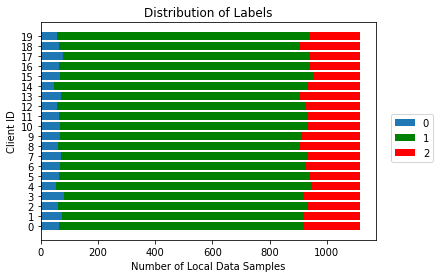

In [48]:
plot_distribution_of_labels(partitioned_train_set)

In [49]:
# Evaluate local models trained on local data
local_models_y_preds = evaluate_local_models(partitioned_train_set)

In [50]:
precision_recall_fscores_of_local_models = get_precision_recall_fscores_of_local_models(y_test, local_models_y_preds)

In [51]:
avg_local_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_models)

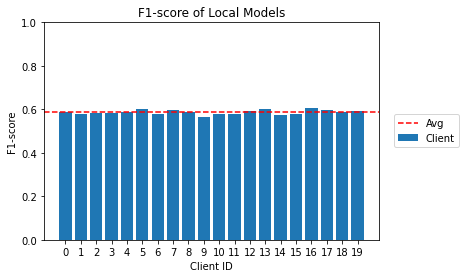

In [52]:
plot_performance_of_local_models(precision_recall_fscores_of_local_models, avg_local_model_precision_recall_fscore)

In [53]:
print_measures_of_dispersion(precision_recall_fscores_of_local_models)

Variance of F1-score across local models: 8.820078542147896e-05
Standard Deviation of F1-score across local models: 0.009391527321020738


In [54]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set)

INFO flower 2022-02-12 23:08:03,919 | app.py:80 | Flower server running (insecure, 50 rounds)
INFO flower 2022-02-12 23:08:03,922 | server.py:118 | Initializing global parameters
INFO flower 2022-02-12 23:08:03,925 | server.py:304 | Requesting initial parameters from one random client


initializing Client0 with pid 437


DEBUG flower 2022-02-12 23:08:05,927 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:08:05,930 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:08:05,930 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:08:05,938 | server.py:307 | Received initial parameters from one random client
INFO flower 2022-02-12 23:08:05,940 | server.py:120 | Evaluating initial parameters


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.06      1.00      0.11       143
           1       0.00      0.00      0.00      1920
           2       0.00      0.00      0.00       416

    accuracy                           0.06      2479
   macro avg       0.02      0.33      0.04      2479
weighted avg       0.00      0.06      0.01      2479

Calculating probability estimates
Probability estimates: [[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 ...
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:06,067 | server.py:127 | initial parameters (loss, other metrics): 1.0986122886681096, {'accuracy': 0.057684550221863654}
INFO flower 2022-02-12 23:08:06,078 | server.py:133 | FL starting


initializing Client1 with pid 504


DEBUG flower 2022-02-12 23:08:06,944 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:08:06,947 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:08:06,947 | app.py:61 | Opened (insecure) gRPC connection


initializing Client2 with pid 524


DEBUG flower 2022-02-12 23:08:07,966 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:08:07,969 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:08:07,970 | app.py:61 | Opened (insecure) gRPC connection


initializing Client3 with pid 544


DEBUG flower 2022-02-12 23:08:08,982 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:08:08,984 | connection.py:36 | ChannelConnectivity.CONNECTING
INFO flower 2022-02-12 23:08:08,985 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:08:08,985 | connection.py:36 | ChannelConnectivity.READY


initializing Client4 with pid 566


DEBUG flower 2022-02-12 23:08:10,005 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:08:10,007 | connection.py:36 | ChannelConnectivity.CONNECTING
INFO flower 2022-02-12 23:08:10,009 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:08:10,009 | connection.py:36 | ChannelConnectivity.READY


initializing Client5 with pid 588


DEBUG flower 2022-02-12 23:08:11,019 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:08:11,021 | connection.py:36 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-02-12 23:08:11,023 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:08:11,023 | app.py:61 | Opened (insecure) gRPC connection


initializing Client6 with pid 610


DEBUG flower 2022-02-12 23:08:12,034 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:08:12,037 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:08:12,037 | app.py:61 | Opened (insecure) gRPC connection


initializing Client7 with pid 630


DEBUG flower 2022-02-12 23:08:13,051 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:08:13,054 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:08:13,055 | connection.py:36 | ChannelConnectivity.READY


initializing Client8 with pid 653


DEBUG flower 2022-02-12 23:08:14,068 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:08:14,070 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:08:14,070 | connection.py:36 | ChannelConnectivity.READY


initializing Client9 with pid 675


DEBUG flower 2022-02-12 23:08:15,084 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:08:15,086 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:08:15,087 | connection.py:36 | ChannelConnectivity.READY


initializing Client10 with pid 695


DEBUG flower 2022-02-12 23:08:16,102 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:08:16,104 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:08:16,105 | app.py:61 | Opened (insecure) gRPC connection


initializing Client11 with pid 715


DEBUG flower 2022-02-12 23:08:17,121 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:08:17,123 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:08:17,124 | connection.py:36 | ChannelConnectivity.READY


initializing Client12 with pid 735


DEBUG flower 2022-02-12 23:08:18,137 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:08:18,140 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:08:18,140 | connection.py:36 | ChannelConnectivity.READY


initializing Client13 with pid 755


DEBUG flower 2022-02-12 23:08:19,152 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:08:19,154 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:08:19,154 | connection.py:36 | ChannelConnectivity.READY


initializing Client14 with pid 775


DEBUG flower 2022-02-12 23:08:20,171 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:08:20,174 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:08:20,174 | connection.py:36 | ChannelConnectivity.READY


initializing Client15 with pid 795


DEBUG flower 2022-02-12 23:08:21,189 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:08:21,191 | connection.py:36 | ChannelConnectivity.CONNECTING
INFO flower 2022-02-12 23:08:21,192 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:08:21,193 | connection.py:36 | ChannelConnectivity.READY


initializing Client16 with pid 817


DEBUG flower 2022-02-12 23:08:22,206 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:08:22,208 | connection.py:36 | ChannelConnectivity.CONNECTING
INFO flower 2022-02-12 23:08:22,209 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:08:22,209 | connection.py:36 | ChannelConnectivity.READY


initializing Client17 with pid 839


DEBUG flower 2022-02-12 23:08:23,233 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:08:23,236 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:08:23,237 | app.py:61 | Opened (insecure) gRPC connection


initializing Client18 with pid 859


DEBUG flower 2022-02-12 23:08:24,252 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:08:24,255 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:08:24,256 | app.py:61 | Opened (insecure) gRPC connection


initializing Client19 with pid 881


DEBUG flower 2022-02-12 23:08:25,272 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:08:25,276 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)
DEBUG flower 2022-02-12 23:08:25,276 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:08:25,275 | app.py:61 | Opened (insecure) gRPC connection


Client18 with pid 859 is sampled in rnd 1
Client2 with pid 524 is sampled in rnd 1
Client8 with pid 653 is sampled in rnd 1
Client3 with pid 544 is sampled in rnd 1
Client13 with pid 755 is sampled in rnd 1
Client7 with pid 630 is sampled in rnd 1
Client10 with pid 695 is sampled in rnd 1
Client15 with pid 795 is sampled in rnd 1
Client16 with pid 817 is sampled in rnd 1
Client12 with pid 735 is sampled in rnd 1
Client6 with pid 610 is sampled in rnd 1
Client1 with pid 504 is sampled in rnd 1
Client14 with pid 775 is sampled in rnd 1
Client0 with pid 437 is sampled in rnd 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1

DEBUG flower 2022-02-12 23:08:26,666 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.25      0.50      0.33       143
           1       0.92      0.77      0.84      1920
           2       0.52      0.73      0.60       416

    accuracy                           0.75      2479
   macro avg       0.56      0.66      0.59      2479
weighted avg       0.81      0.75      0.77      2479

Calculating probability estimates
Probability estimates: [[0.21606197 0.65069781 0.13324022]
 [0.0024041  0.0015546  0.9960413 ]
 [0.10951576 0.76855206 0.12193218]
 ...
 [0.05132561 0.82218391 0.12649047]
 [0.11071102 0.70839001 0.18089896]
 [0.06545675 0.82276737 0.11177588]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:26,807 | server.py:154 | fit progress: (1, 0.6583917417664652, {'accuracy': 0.7450584913271481}, 20.719693173999985)
INFO flower 2022-02-12 23:08:26,812 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:26,816 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 755 is sampled in rnd 2
Client12 with pid 735 is sampled in rnd 2
Client0 with pid 437 is sampled in rnd 2
Client14 with pid 775 is sampled in rnd 2
Client8 with pid 653 is sampled in rnd 2
Client11 with pid 715 is sampled in rnd 2
Client19 with pid 881 is sampled in rnd 2
Client3 with pid 544 is sampled in rnd 2
Client9 with pid 675 is sampled in rnd 2
Client1 with pid 504 is sampled in rnd 2
Client5 with pid 588 is sampled in rnd 2
Client17 with pid 839 is sampled in rnd 2
Client15 with pid 795 is sampled in rnd 2
Client7 with pid 630 is sampled in rnd 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2

DEBUG flower 2022-02-12 23:08:28,155 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.44      0.38       143
           1       0.93      0.81      0.87      1920
           2       0.55      0.81      0.66       416

    accuracy                           0.79      2479
   macro avg       0.61      0.69      0.63      2479
weighted avg       0.83      0.79      0.80      2479

Calculating probability estimates
Probability estimates: [[0.19840728 0.72431358 0.07727914]
 [0.0016653  0.00411258 0.99422212]
 [0.13792308 0.73679902 0.1252779 ]
 ...
 [0.07372319 0.80487885 0.12139796]
 [0.16274063 0.61695376 0.22030561]
 [0.07281378 0.80614298 0.12104324]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:28,293 | server.py:154 | fit progress: (2, 0.5747541042764024, {'accuracy': 0.7898346107301332}, 22.2054461109999)
INFO flower 2022-02-12 23:08:28,304 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:28,309 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 839 is sampled in rnd 3
Client0 with pid 437 is sampled in rnd 3
Client12 with pid 735 is sampled in rnd 3
Client6 with pid 610 is sampled in rnd 3
Client13 with pid 755 is sampled in rnd 3
Client11 with pid 715 is sampled in rnd 3
Client18 with pid 859 is sampled in rnd 3
Client3 with pid 544 is sampled in rnd 3
Client8 with pid 653 is sampled in rnd 3
Client7 with pid 630 is sampled in rnd 3
Client19 with pid 881 is sampled in rnd 3
Client10 with pid 695 is sampled in rnd 3
Client14 with pid 775 is sampled in rnd 3
Client2 with pid 524 is sampled in rnd 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 

DEBUG flower 2022-02-12 23:08:29,621 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.31      0.41      0.35       143
           1       0.94      0.81      0.87      1920
           2       0.55      0.85      0.67       416

    accuracy                           0.79      2479
   macro avg       0.60      0.69      0.63      2479
weighted avg       0.84      0.79      0.80      2479

Calculating probability estimates
Probability estimates: [[0.05104705 0.82987916 0.11907378]
 [0.0024518  0.00258277 0.99496543]
 [0.10406615 0.7882509  0.10768296]
 ...
 [0.0491574  0.85967966 0.09116294]
 [0.09492654 0.71412005 0.1909534 ]
 [0.04912707 0.8481376  0.10273532]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:29,739 | server.py:154 | fit progress: (3, 0.5590031911851815, {'accuracy': 0.7894312222670432}, 23.651602240000102)
INFO flower 2022-02-12 23:08:29,746 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:29,756 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 630 is sampled in rnd 4
Client14 with pid 775 is sampled in rnd 4
Client19 with pid 881 is sampled in rnd 4
Client9 with pid 675 is sampled in rnd 4
Client6 with pid 610 is sampled in rnd 4
Client13 with pid 755 is sampled in rnd 4
Client8 with pid 653 is sampled in rnd 4
Client10 with pid 695 is sampled in rnd 4
Client1 with pid 504 is sampled in rnd 4
Client4 with pid 566 is sampled in rnd 4
Client11 with pid 715 is sampled in rnd 4
Client2 with pid 524 is sampled in rnd 4
Client0 with pid 437 is sampled in rnd 4
Client5 with pid 588 is sampled in rnd 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4


DEBUG flower 2022-02-12 23:08:31,036 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.44      0.38       143
           1       0.94      0.82      0.87      1920
           2       0.57      0.85      0.68       416

    accuracy                           0.80      2479
   macro avg       0.61      0.70      0.65      2479
weighted avg       0.84      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[0.08855433 0.78221476 0.12923091]
 [0.0010034  0.00388336 0.99511324]
 [0.11760513 0.79867312 0.08372176]
 ...
 [0.05855375 0.85982157 0.08162467]
 [0.13511484 0.66100614 0.20387902]
 [0.06067821 0.8176273  0.12169449]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:31,175 | server.py:154 | fit progress: (4, 0.5485390693614084, {'accuracy': 0.799919322307382}, 25.087410010999974)
INFO flower 2022-02-12 23:08:31,179 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:31,181 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 695 is sampled in rnd 5
Client13 with pid 755 is sampled in rnd 5
Client16 with pid 817 is sampled in rnd 5
Client18 with pid 859 is sampled in rnd 5
Client6 with pid 610 is sampled in rnd 5
Client4 with pid 566 is sampled in rnd 5
Client14 with pid 775 is sampled in rnd 5
Client7 with pid 630 is sampled in rnd 5
Client8 with pid 653 is sampled in rnd 5
Client9 with pid 675 is sampled in rnd 5
Client15 with pid 795 is sampled in rnd 5
Client0 with pid 437 is sampled in rnd 5
Client11 with pid 715 is sampled in rnd 5
Client1 with pid 504 is sampled in rnd 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5

DEBUG flower 2022-02-12 23:08:32,479 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.43      0.37       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.85      0.69       416

    accuracy                           0.80      2479
   macro avg       0.61      0.70      0.64      2479
weighted avg       0.84      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[0.06283988 0.85545266 0.08170746]
 [0.00132919 0.0037624  0.99490841]
 [0.08566461 0.83953743 0.07479796]
 ...
 [0.05152082 0.8797628  0.06871637]
 [0.10498444 0.72915375 0.16586181]
 [0.06413038 0.83788697 0.09798264]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:32,600 | server.py:154 | fit progress: (5, 0.5433327371416975, {'accuracy': 0.8023396530859217}, 26.51223289099994)
INFO flower 2022-02-12 23:08:32,606 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:32,607 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 735 is sampled in rnd 6
Client13 with pid 755 is sampled in rnd 6
Client11 with pid 715 is sampled in rnd 6
Client16 with pid 817 is sampled in rnd 6
Client1 with pid 504 is sampled in rnd 6
Client10 with pid 695 is sampled in rnd 6
Client8 with pid 653 is sampled in rnd 6
Client7 with pid 630 is sampled in rnd 6
Client5 with pid 588 is sampled in rnd 6
Client14 with pid 775 is sampled in rnd 6
Client6 with pid 610 is sampled in rnd 6
Client15 with pid 795 is sampled in rnd 6
Client9 with pid 675 is sampled in rnd 6
Client2 with pid 524 is sampled in rnd 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6

DEBUG flower 2022-02-12 23:08:33,926 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.43      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.04333107 0.86580815 0.09086078]
 [0.00143257 0.00500987 0.99355756]
 [0.09773883 0.82551391 0.07674726]
 ...
 [0.04068926 0.88936346 0.06994728]
 [0.09927243 0.71882739 0.18190018]
 [0.04423335 0.86729107 0.08847558]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:34,063 | server.py:154 | fit progress: (6, 0.524430264327616, {'accuracy': 0.8108108108108109}, 27.975630247000026)
INFO flower 2022-02-12 23:08:34,074 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:34,084 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 795 is sampled in rnd 7
Client0 with pid 437 is sampled in rnd 7
Client19 with pid 881 is sampled in rnd 7
Client9 with pid 675 is sampled in rnd 7
Client1 with pid 504 is sampled in rnd 7
Client11 with pid 715 is sampled in rnd 7
Client13 with pid 755 is sampled in rnd 7
Client17 with pid 839 is sampled in rnd 7
Client14 with pid 775 is sampled in rnd 7
Client12 with pid 735 is sampled in rnd 7
Client6 with pid 610 is sampled in rnd 7
Client2 with pid 524 is sampled in rnd 7
Client8 with pid 653 is sampled in rnd 7
Client4 with pid 566 is sampled in rnd 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7

DEBUG flower 2022-02-12 23:08:35,444 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.44      0.38       143
           1       0.93      0.82      0.87      1920
           2       0.58      0.84      0.69       416

    accuracy                           0.80      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.84      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[0.05014495 0.87469085 0.0751642 ]
 [0.00101339 0.00422994 0.99475666]
 [0.08065162 0.84318975 0.07615863]
 ...
 [0.0424062  0.90231536 0.05527844]
 [0.09083267 0.74316306 0.16600426]
 [0.03400947 0.90465259 0.06133793]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:35,578 | server.py:154 | fit progress: (7, 0.5308248308846336, {'accuracy': 0.8027430415490117}, 29.490090565999935)
INFO flower 2022-02-12 23:08:35,584 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:35,590 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 630 is sampled in rnd 8
Client0 with pid 437 is sampled in rnd 8
Client6 with pid 610 is sampled in rnd 8
Client19 with pid 881 is sampled in rnd 8
Client8 with pid 653 is sampled in rnd 8
Client12 with pid 735 is sampled in rnd 8
Client5 with pid 588 is sampled in rnd 8
Client9 with pid 675 is sampled in rnd 8
Client13 with pid 755 is sampled in rnd 8
Client16 with pid 817 is sampled in rnd 8
Client4 with pid 566 is sampled in rnd 8
Client14 with pid 775 is sampled in rnd 8
Client18 with pid 859 is sampled in rnd 8
Client3 with pid 544 is sampled in rnd 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8


DEBUG flower 2022-02-12 23:08:36,914 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.44      0.37       143
           1       0.94      0.82      0.87      1920
           2       0.58      0.87      0.70       416

    accuracy                           0.80      2479
   macro avg       0.61      0.71      0.65      2479
weighted avg       0.85      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.05535667 0.83266615 0.11197718]
 [0.00181464 0.00519335 0.99299201]
 [0.09004107 0.84276911 0.06718982]
 ...
 [0.04823933 0.88208157 0.0696791 ]
 [0.11359952 0.70756377 0.17883671]
 [0.04341901 0.88013404 0.07644695]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:37,040 | server.py:154 | fit progress: (8, 0.5348463924565859, {'accuracy': 0.8019362646228317}, 30.952030483000044)
INFO flower 2022-02-12 23:08:37,042 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:37,044 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 817 is sampled in rnd 9
Client4 with pid 566 is sampled in rnd 9
Client19 with pid 881 is sampled in rnd 9
Client6 with pid 610 is sampled in rnd 9
Client0 with pid 437 is sampled in rnd 9
Client13 with pid 755 is sampled in rnd 9
Client7 with pid 630 is sampled in rnd 9
Client5 with pid 588 is sampled in rnd 9
Client9 with pid 675 is sampled in rnd 9
Client8 with pid 653 is sampled in rnd 9
Client3 with pid 544 is sampled in rnd 9
Client10 with pid 695 is sampled in rnd 9
Client17 with pid 839 is sampled in rnd 9
Client11 with pid 715 is sampled in rnd 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9


DEBUG flower 2022-02-12 23:08:38,396 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.45      0.38       143
           1       0.94      0.83      0.88      1920
           2       0.60      0.85      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[9.50285172e-02 8.20543768e-01 8.44277147e-02]
 [9.33502910e-04 4.29807680e-03 9.94768420e-01]
 [8.11127322e-02 8.54115856e-01 6.47714115e-02]
 ...
 [6.38590469e-02 8.75217656e-01 6.09232971e-02]
 [1.30279717e-01 6.89141943e-01 1.80578341e-01]
 [4.57936813e-02 8.73739728e-01 8.04665909e-02]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finish

INFO flower 2022-02-12 23:08:38,530 | server.py:154 | fit progress: (9, 0.5270347889060961, {'accuracy': 0.8083904800322711}, 32.442626046999976)
INFO flower 2022-02-12 23:08:38,537 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:38,540 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 715 is sampled in rnd 10
Client10 with pid 695 is sampled in rnd 10
Client0 with pid 437 is sampled in rnd 10
Client13 with pid 755 is sampled in rnd 10
Client19 with pid 881 is sampled in rnd 10
Client7 with pid 630 is sampled in rnd 10
Client9 with pid 675 is sampled in rnd 10
Client16 with pid 817 is sampled in rnd 10
Client3 with pid 544 is sampled in rnd 10
Client15 with pid 795 is sampled in rnd 10
Client2 with pid 524 is sampled in rnd 10
Client8 with pid 653 is sampled in rnd 10
Client18 with pid 859 is sampled in rnd 10
Client6 with pid 610 is sampled in rnd 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Tr

DEBUG flower 2022-02-12 23:08:39,893 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.44      0.38       143
           1       0.94      0.83      0.88      1920
           2       0.60      0.84      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.84      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.07585722 0.827131   0.09701178]
 [0.00143945 0.00481256 0.99374799]
 [0.07532737 0.86115365 0.06351899]
 ...
 [0.05925067 0.88127625 0.05947308]
 [0.11325332 0.7059094  0.18083728]
 [0.05174757 0.87479454 0.07345788]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:40,036 | server.py:154 | fit progress: (10, 0.517163591284588, {'accuracy': 0.8108108108108109}, 33.947955587000024)
INFO flower 2022-02-12 23:08:40,044 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:40,054 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 524 is sampled in rnd 11
Client17 with pid 839 is sampled in rnd 11
Client8 with pid 653 is sampled in rnd 11
Client1 with pid 504 is sampled in rnd 11
Client19 with pid 881 is sampled in rnd 11
Client16 with pid 817 is sampled in rnd 11
Client13 with pid 755 is sampled in rnd 11
Training finished for round 11
Client7 with pid 630 is sampled in rnd 11
Client0 with pid 437 is sampled in rnd 11
Client4 with pid 566 is sampled in rnd 11
Client3 with pid 544 is sampled in rnd 11
Client12 with pid 735 is sampled in rnd 11
Client9 with pid 675 is sampled in rnd 11
Client10 with pid 695 is sampled in rnd 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Tra

DEBUG flower 2022-02-12 23:08:41,340 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.44      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[8.29098583e-02 8.24418372e-01 9.26717698e-02]
 [8.54814348e-04 4.15613602e-03 9.94989050e-01]
 [7.01083764e-02 8.65074468e-01 6.48171552e-02]
 ...
 [5.30050737e-02 8.87146596e-01 5.98483299e-02]
 [1.23453975e-01 6.76499295e-01 2.00046731e-01]
 [3.74610973e-02 8.78461559e-01 8.40773436e-02]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finish

INFO flower 2022-02-12 23:08:41,481 | server.py:154 | fit progress: (11, 0.5170190301962734, {'accuracy': 0.8104074223477209}, 35.39378469600001)
INFO flower 2022-02-12 23:08:41,490 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:41,498 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client5 with pid 588 is sampled in rnd 12
Client19 with pid 881 is sampled in rnd 12
Client11 with pid 715 is sampled in rnd 12
Client9 with pid 675 is sampled in rnd 12
Client15 with pid 795 is sampled in rnd 12
Client14 with pid 775 is sampled in rnd 12
Client2 with pid 524 is sampled in rnd 12
Client8 with pid 653 is sampled in rnd 12
Client4 with pid 566 is sampled in rnd 12
Client13 with pid 755 is sampled in rnd 12
Client12 with pid 735 is sampled in rnd 12
Client16 with pid 817 is sampled in rnd 12
Client7 with pid 630 is sampled in rnd 12
Client18 with pid 859 is sampled in rnd 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
T

DEBUG flower 2022-02-12 23:08:42,880 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.42      0.38       143
           1       0.94      0.83      0.88      1920
           2       0.58      0.86      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.84      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.03833782 0.87818126 0.08348092]
 [0.00220848 0.00619584 0.99159569]
 [0.07491277 0.86130422 0.06378301]
 ...
 [0.04321863 0.9060389  0.05074247]
 [0.09496881 0.74461207 0.16041912]
 [0.0323376  0.90656362 0.06109878]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:42,996 | server.py:154 | fit progress: (12, 0.5171192852878351, {'accuracy': 0.8104074223477209}, 36.90838983499998)
INFO flower 2022-02-12 23:08:43,006 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:43,012 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 695 is sampled in rnd 13
Client18 with pid 859 is sampled in rnd 13
Client0 with pid 437 is sampled in rnd 13
Client15 with pid 795 is sampled in rnd 13
Client3 with pid 544 is sampled in rnd 13
Client4 with pid 566 is sampled in rnd 13
Client6 with pid 610 is sampled in rnd 13
Client5 with pid 588 is sampled in rnd 13
Client13 with pid 755 is sampled in rnd 13
Client16 with pid 817 is sampled in rnd 13
Client14 with pid 775 is sampled in rnd 13
Client1 with pid 504 is sampled in rnd 13
Client9 with pid 675 is sampled in rnd 13
Client12 with pid 735 is sampled in rnd 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Tr

DEBUG flower 2022-02-12 23:08:44,348 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.41      0.37       143
           1       0.94      0.83      0.88      1920
           2       0.58      0.84      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.84      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.04933625 0.85605143 0.09461232]
 [0.00140463 0.00608493 0.99251044]
 [0.06978402 0.8738338  0.05638218]
 ...
 [0.04937332 0.88752782 0.06309886]
 [0.1041929  0.73917908 0.15662802]
 [0.0352551  0.90169501 0.06304989]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:44,505 | server.py:154 | fit progress: (13, 0.5163460883754807, {'accuracy': 0.809600645421541}, 38.41743948399994)
INFO flower 2022-02-12 23:08:44,512 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:44,521 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 610 is sampled in rnd 14
Client16 with pid 817 is sampled in rnd 14
Client13 with pid 755 is sampled in rnd 14
Client7 with pid 630 is sampled in rnd 14
Client0 with pid 437 is sampled in rnd 14
Client19 with pid 881 is sampled in rnd 14
Client2 with pid 524 is sampled in rnd 14
Client18 with pid 859 is sampled in rnd 14
Client14 with pid 775 is sampled in rnd 14
Client12 with pid 735 is sampled in rnd 14
Client15 with pid 795 is sampled in rnd 14
Client8 with pid 653 is sampled in rnd 14
Client17 with pid 839 is sampled in rnd 14
Client4 with pid 566 is sampled in rnd 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
T

DEBUG flower 2022-02-12 23:08:45,830 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.43      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.60      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.04765102 0.87532614 0.07702284]
 [0.00275732 0.00693943 0.99030326]
 [0.07765822 0.85612025 0.06622152]
 ...
 [0.05281892 0.89276765 0.05441343]
 [0.09555507 0.74677003 0.1576749 ]
 [0.03366282 0.90735154 0.05898563]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:45,975 | server.py:154 | fit progress: (14, 0.520936982637261, {'accuracy': 0.8144413069786204}, 39.88757765199989)
INFO flower 2022-02-12 23:08:45,984 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:45,988 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 630 is sampled in rnd 15
Client16 with pid 817 is sampled in rnd 15
Client19 with pid 881 is sampled in rnd 15
Client14 with pid 775 is sampled in rnd 15
Client0 with pid 437 is sampled in rnd 15
Client6 with pid 610 is sampled in rnd 15
Client10 with pid 695 is sampled in rnd 15
Client5 with pid 588 is sampled in rnd 15
Client9 with pid 675 is sampled in rnd 15
Client17 with pid 839 is sampled in rnd 15
Client13 with pid 755 is sampled in rnd 15
Client4 with pid 566 is sampled in rnd 15
Client15 with pid 795 is sampled in rnd 15
Client1 with pid 504 is sampled in rnd 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Tr

DEBUG flower 2022-02-12 23:08:47,298 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.43      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.58      0.86      0.69       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[7.39189470e-02 8.37567049e-01 8.85140044e-02]
 [9.16234843e-04 5.07047817e-03 9.94013287e-01]
 [7.52132371e-02 8.72180615e-01 5.26061480e-02]
 ...
 [5.97249373e-02 8.88448005e-01 5.18270582e-02]
 [1.19770741e-01 7.25961119e-01 1.54268141e-01]
 [3.63625757e-02 8.96321606e-01 6.73158181e-02]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finish

INFO flower 2022-02-12 23:08:47,428 | server.py:154 | fit progress: (15, 0.5196943717052301, {'accuracy': 0.8112141992739008}, 41.34014719399988)
INFO flower 2022-02-12 23:08:47,433 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:47,438 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 610 is sampled in rnd 16
Client1 with pid 504 is sampled in rnd 16
Client9 with pid 675 is sampled in rnd 16
Client2 with pid 524 is sampled in rnd 16
Client4 with pid 566 is sampled in rnd 16
Client14 with pid 775 is sampled in rnd 16
Client11 with pid 715 is sampled in rnd 16
Client15 with pid 795 is sampled in rnd 16
Client16 with pid 817 is sampled in rnd 16
Client19 with pid 881 is sampled in rnd 16
Client17 with pid 839 is sampled in rnd 16
Client13 with pid 755 is sampled in rnd 16
Client12 with pid 735 is sampled in rnd 16
Client0 with pid 437 is sampled in rnd 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
T

DEBUG flower 2022-02-12 23:08:48,775 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.45      0.37       143
           1       0.93      0.82      0.88      1920
           2       0.60      0.84      0.70       416

    accuracy                           0.80      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.84      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.05607821 0.85608717 0.08783462]
 [0.00173075 0.00642866 0.99184059]
 [0.08066127 0.86010809 0.05923064]
 ...
 [0.05228579 0.89840854 0.04930567]
 [0.1104102  0.74277673 0.14681307]
 [0.02961582 0.91985339 0.05053079]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:48,915 | server.py:154 | fit progress: (16, 0.5321734979528738, {'accuracy': 0.8039532069382815}, 42.82760611200001)
INFO flower 2022-02-12 23:08:48,922 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:48,927 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 839 is sampled in rnd 17
Client1 with pid 504 is sampled in rnd 17
Client6 with pid 610 is sampled in rnd 17
Client5 with pid 588 is sampled in rnd 17
Client13 with pid 755 is sampled in rnd 17
Client16 with pid 817 is sampled in rnd 17
Client12 with pid 735 is sampled in rnd 17
Client9 with pid 675 is sampled in rnd 17
Client11 with pid 715 is sampled in rnd 17
Client0 with pid 437 is sampled in rnd 17
Client8 with pid 653 is sampled in rnd 17
Client14 with pid 775 is sampled in rnd 17
Client19 with pid 881 is sampled in rnd 17
Client18 with pid 859 is sampled in rnd 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
T

DEBUG flower 2022-02-12 23:08:50,212 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.43      0.39       143
           1       0.94      0.82      0.88      1920
           2       0.57      0.87      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[8.13179687e-02 8.32607030e-01 8.60750018e-02]
 [9.15744818e-04 3.27726289e-03 9.95806992e-01]
 [7.38097504e-02 8.58882148e-01 6.73081019e-02]
 ...
 [5.11691747e-02 8.88585771e-01 6.02450543e-02]
 [1.05039082e-01 7.30452135e-01 1.64508783e-01]
 [4.67808896e-02 8.78662336e-01 7.45567740e-02]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finish

INFO flower 2022-02-12 23:08:50,357 | server.py:154 | fit progress: (17, 0.5248332564478596, {'accuracy': 0.8075837031060912}, 44.2693487439999)
INFO flower 2022-02-12 23:08:50,360 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:50,367 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 715 is sampled in rnd 18
Client13 with pid 755 is sampled in rnd 18
Client3 with pid 544 is sampled in rnd 18
Client17 with pid 839 is sampled in rnd 18
Client7 with pid 630 is sampled in rnd 18
Client6 with pid 610 is sampled in rnd 18
Client1 with pid 504 is sampled in rnd 18
Client10 with pid 695 is sampled in rnd 18
Client15 with pid 795 is sampled in rnd 18
Client4 with pid 566 is sampled in rnd 18
Client8 with pid 653 is sampled in rnd 18
Client14 with pid 775 is sampled in rnd 18
Client0 with pid 437 is sampled in rnd 18
Client2 with pid 524 is sampled in rnd 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Tra

DEBUG flower 2022-02-12 23:08:51,648 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.45      0.40       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.85      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.06614356 0.8398933  0.09396313]
 [0.00217829 0.00635079 0.99147092]
 [0.07402647 0.86170309 0.06427044]
 ...
 [0.05010258 0.878276   0.07162143]
 [0.09140734 0.72007183 0.18852084]
 [0.04570413 0.86657928 0.08771659]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:51,796 | server.py:154 | fit progress: (18, 0.5197945902450908, {'accuracy': 0.8140379185155304}, 45.708633713999916)
INFO flower 2022-02-12 23:08:51,802 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:51,807 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 881 is sampled in rnd 19
Client9 with pid 675 is sampled in rnd 19
Client0 with pid 437 is sampled in rnd 19
Client12 with pid 735 is sampled in rnd 19
Client5 with pid 588 is sampled in rnd 19
Client3 with pid 544 is sampled in rnd 19
Client15 with pid 795 is sampled in rnd 19
Client13 with pid 755 is sampled in rnd 19
Client17 with pid 839 is sampled in rnd 19
Client2 with pid 524 is sampled in rnd 19
Client18 with pid 859 is sampled in rnd 19
Client6 with pid 610 is sampled in rnd 19
Client14 with pid 775 is sampled in rnd 19
Client10 with pid 695 is sampled in rnd 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
T

DEBUG flower 2022-02-12 23:08:53,177 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.44      0.40       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.85      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.02973561 0.88753124 0.08273315]
 [0.0013761  0.00445305 0.99417085]
 [0.08975932 0.84336249 0.06687819]
 ...
 [0.05190911 0.89328417 0.05480672]
 [0.11590124 0.74068434 0.14341441]
 [0.03149853 0.92133227 0.04716921]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:53,328 | server.py:154 | fit progress: (19, 0.5151167786614687, {'accuracy': 0.8124243646631706}, 47.24068421800007)
INFO flower 2022-02-12 23:08:53,333 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:53,343 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 735 is sampled in rnd 20
Client3 with pid 544 is sampled in rnd 20
Client11 with pid 715 is sampled in rnd 20
Client17 with pid 839 is sampled in rnd 20
Client15 with pid 795 is sampled in rnd 20
Client18 with pid 859 is sampled in rnd 20
Client8 with pid 653 is sampled in rnd 20
Client19 with pid 881 is sampled in rnd 20
Client1 with pid 504 is sampled in rnd 20
Client16 with pid 817 is sampled in rnd 20
Client0 with pid 437 is sampled in rnd 20
Client13 with pid 755 is sampled in rnd 20
Client2 with pid 524 is sampled in rnd 20
Client9 with pid 675 is sampled in rnd 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
T

DEBUG flower 2022-02-12 23:08:54,671 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.45      0.39       143
           1       0.93      0.83      0.88      1920
           2       0.59      0.83      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.84      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.12455317 0.79207307 0.08337376]
 [0.0019835  0.00474866 0.99326784]
 [0.06423868 0.86247969 0.07328163]
 ...
 [0.05053839 0.88815382 0.0613078 ]
 [0.08680713 0.75209208 0.16110079]
 [0.04000844 0.90389617 0.05609539]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:54,832 | server.py:154 | fit progress: (20, 0.5213723186084654, {'accuracy': 0.8067769261799113}, 48.74483351599997)
INFO flower 2022-02-12 23:08:54,838 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:54,847 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 839 is sampled in rnd 21
Client6 with pid 610 is sampled in rnd 21
Client8 with pid 653 is sampled in rnd 21
Client10 with pid 695 is sampled in rnd 21
Client19 with pid 881 is sampled in rnd 21
Client5 with pid 588 is sampled in rnd 21
Client14 with pid 775 is sampled in rnd 21
Client13 with pid 755 is sampled in rnd 21
Client1 with pid 504 is sampled in rnd 21
Client3 with pid 544 is sampled in rnd 21
Client4 with pid 566 is sampled in rnd 21
Client7 with pid 630 is sampled in rnd 21
Client2 with pid 524 is sampled in rnd 21
Client16 with pid 817 is sampled in rnd 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Tra

DEBUG flower 2022-02-12 23:08:56,248 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.43      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.05849953 0.85872167 0.08277881]
 [0.00150143 0.00560822 0.99289035]
 [0.08348236 0.85236331 0.06415433]
 ...
 [0.05942121 0.8804671  0.06011169]
 [0.10768205 0.71705522 0.17526274]
 [0.03949391 0.86757976 0.09292633]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:56,392 | server.py:154 | fit progress: (21, 0.5208451412153122, {'accuracy': 0.8148446954417103}, 50.30482631099994)
INFO flower 2022-02-12 23:08:56,397 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:56,403 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 839 is sampled in rnd 22
Client3 with pid 544 is sampled in rnd 22
Client1 with pid 504 is sampled in rnd 22
Client10 with pid 695 is sampled in rnd 22
Client13 with pid 755 is sampled in rnd 22
Client16 with pid 817 is sampled in rnd 22
Client6 with pid 610 is sampled in rnd 22
Client12 with pid 735 is sampled in rnd 22
Client2 with pid 524 is sampled in rnd 22
Client11 with pid 715 is sampled in rnd 22
Client5 with pid 588 is sampled in rnd 22
Client14 with pid 775 is sampled in rnd 22
Client15 with pid 795 is sampled in rnd 22
Client0 with pid 437 is sampled in rnd 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
T

DEBUG flower 2022-02-12 23:08:57,758 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.43      0.38       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.85      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.0568674  0.84751376 0.09561884]
 [0.00202507 0.00531237 0.99266257]
 [0.07600142 0.85547656 0.06852202]
 ...
 [0.05267422 0.88111815 0.06620763]
 [0.09738817 0.74407614 0.15853569]
 [0.04195721 0.88289132 0.07515147]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:57,921 | server.py:154 | fit progress: (22, 0.5240032165917521, {'accuracy': 0.809197256958451}, 51.83386019499994)
INFO flower 2022-02-12 23:08:57,928 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:57,938 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 859 is sampled in rnd 23
Client17 with pid 839 is sampled in rnd 23
Client2 with pid 524 is sampled in rnd 23
Client7 with pid 630 is sampled in rnd 23
Client5 with pid 588 is sampled in rnd 23
Client8 with pid 653 is sampled in rnd 23
Client4 with pid 566 is sampled in rnd 23
Client9 with pid 675 is sampled in rnd 23
Client15 with pid 795 is sampled in rnd 23
Client1 with pid 504 is sampled in rnd 23
Client13 with pid 755 is sampled in rnd 23
Client19 with pid 881 is sampled in rnd 23
Client10 with pid 695 is sampled in rnd 23
Client6 with pid 610 is sampled in rnd 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Tra

DEBUG flower 2022-02-12 23:08:59,225 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.37      0.47      0.41       143
           1       0.94      0.84      0.88      1920
           2       0.60      0.84      0.70       416

    accuracy                           0.82      2479
   macro avg       0.63      0.72      0.67      2479
weighted avg       0.85      0.82      0.83      2479

Calculating probability estimates
Probability estimates: [[0.0580351  0.86572478 0.07624012]
 [0.00119816 0.00548668 0.99331516]
 [0.09021679 0.84327948 0.06650373]
 ...
 [0.05795335 0.88907129 0.05297536]
 [0.12644723 0.71581211 0.15774067]
 [0.03438196 0.90034371 0.06527433]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:08:59,367 | server.py:154 | fit progress: (23, 0.5177131359265785, {'accuracy': 0.8152480839048003}, 53.27954333899993)
INFO flower 2022-02-12 23:08:59,369 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:08:59,370 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 504 is sampled in rnd 24
Client0 with pid 437 is sampled in rnd 24
Client9 with pid 675 is sampled in rnd 24
Client17 with pid 839 is sampled in rnd 24
Client2 with pid 524 is sampled in rnd 24
Client19 with pid 881 is sampled in rnd 24
Client6 with pid 610 is sampled in rnd 24
Client12 with pid 735 is sampled in rnd 24
Client16 with pid 817 is sampled in rnd 24
Client3 with pid 544 is sampled in rnd 24
Client10 with pid 695 is sampled in rnd 24
Client14 with pid 775 is sampled in rnd 24
Client11 with pid 715 is sampled in rnd 24
Client15 with pid 795 is sampled in rnd 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
T

DEBUG flower 2022-02-12 23:09:00,676 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.44      0.38       143
           1       0.94      0.82      0.87      1920
           2       0.58      0.87      0.70       416

    accuracy                           0.80      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.06096885 0.82205804 0.1169731 ]
 [0.00183497 0.00439834 0.99376669]
 [0.06799774 0.86575735 0.06624491]
 ...
 [0.04664442 0.89025982 0.06309576]
 [0.10141367 0.72981121 0.16877512]
 [0.03884241 0.89526271 0.06589488]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:00,838 | server.py:154 | fit progress: (24, 0.5301170861421275, {'accuracy': 0.8035498184751916}, 54.75060913399989)
INFO flower 2022-02-12 23:09:00,845 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:00,851 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 775 is sampled in rnd 25
Client5 with pid 588 is sampled in rnd 25
Client7 with pid 630 is sampled in rnd 25
Client3 with pid 544 is sampled in rnd 25
Client6 with pid 610 is sampled in rnd 25
Client18 with pid 859 is sampled in rnd 25
Client19 with pid 881 is sampled in rnd 25
Client12 with pid 735 is sampled in rnd 25
Client8 with pid 653 is sampled in rnd 25
Client4 with pid 566 is sampled in rnd 25
Client10 with pid 695 is sampled in rnd 25
Client11 with pid 715 is sampled in rnd 25
Client17 with pid 839 is sampled in rnd 25
Client2 with pid 524 is sampled in rnd 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Tr

DEBUG flower 2022-02-12 23:09:02,159 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.37      0.43      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.87      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.04158981 0.839999   0.11841119]
 [0.00238173 0.00510099 0.99251728]
 [0.07710107 0.85520958 0.06768935]
 ...
 [0.04029414 0.89700719 0.06269867]
 [0.09925666 0.72356896 0.17717438]
 [0.03712488 0.87134019 0.09153492]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:02,305 | server.py:154 | fit progress: (25, 0.5138994289594364, {'accuracy': 0.8144413069786204}, 56.21745290400008)
INFO flower 2022-02-12 23:09:02,308 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:02,313 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 610 is sampled in rnd 26
Client3 with pid 544 is sampled in rnd 26
Client10 with pid 695 is sampled in rnd 26
Client0 with pid 437 is sampled in rnd 26
Client1 with pid 504 is sampled in rnd 26
Client12 with pid 735 is sampled in rnd 26
Client15 with pid 795 is sampled in rnd 26
Client4 with pid 566 is sampled in rnd 26
Client11 with pid 715 is sampled in rnd 26
Client9 with pid 675 is sampled in rnd 26
Client5 with pid 588 is sampled in rnd 26
Client7 with pid 630 is sampled in rnd 26
Client18 with pid 859 is sampled in rnd 26
Client2 with pid 524 is sampled in rnd 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Trai

DEBUG flower 2022-02-12 23:09:03,624 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.45      0.38       143
           1       0.94      0.81      0.87      1920
           2       0.57      0.87      0.69       416

    accuracy                           0.80      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.05289093 0.82896358 0.11814549]
 [0.00187749 0.00420781 0.9939147 ]
 [0.08503333 0.84994381 0.06502286]
 ...
 [0.04559165 0.886425   0.06798335]
 [0.11292356 0.71656195 0.17051448]
 [0.04040059 0.8814932  0.07810621]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:03,769 | server.py:154 | fit progress: (26, 0.527545048205681, {'accuracy': 0.8023396530859217}, 57.68129719600006)
INFO flower 2022-02-12 23:09:03,774 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:03,780 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 524 is sampled in rnd 27
Client12 with pid 735 is sampled in rnd 27
Client10 with pid 695 is sampled in rnd 27
Client4 with pid 566 is sampled in rnd 27
Client18 with pid 859 is sampled in rnd 27
Client1 with pid 504 is sampled in rnd 27
Client14 with pid 775 is sampled in rnd 27
Client3 with pid 544 is sampled in rnd 27
Client9 with pid 675 is sampled in rnd 27
Client8 with pid 653 is sampled in rnd 27
Client13 with pid 755 is sampled in rnd 27
Client7 with pid 630 is sampled in rnd 27
Client5 with pid 588 is sampled in rnd 27
Client15 with pid 795 is sampled in rnd 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Tra

DEBUG flower 2022-02-12 23:09:05,089 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.37      0.43      0.40       143
           1       0.94      0.84      0.89      1920
           2       0.60      0.86      0.70       416

    accuracy                           0.82      2479
   macro avg       0.64      0.71      0.66      2479
weighted avg       0.85      0.82      0.83      2479

Calculating probability estimates
Probability estimates: [[0.03985631 0.86188429 0.0982594 ]
 [0.00195706 0.00540902 0.99263392]
 [0.07463339 0.868179   0.05718762]
 ...
 [0.03883579 0.9053913  0.05577291]
 [0.10427767 0.74646253 0.1492598 ]
 [0.03341072 0.9016996  0.06488968]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:05,239 | server.py:154 | fit progress: (27, 0.5048717526328639, {'accuracy': 0.8188785800726099}, 59.15168507899989)
INFO flower 2022-02-12 23:09:05,251 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:05,256 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 610 is sampled in rnd 28
Client17 with pid 839 is sampled in rnd 28
Client18 with pid 859 is sampled in rnd 28
Client1 with pid 504 is sampled in rnd 28
Client4 with pid 566 is sampled in rnd 28
Client7 with pid 630 is sampled in rnd 28
Client9 with pid 675 is sampled in rnd 28
Client5 with pid 588 is sampled in rnd 28
Client13 with pid 755 is sampled in rnd 28
Client15 with pid 795 is sampled in rnd 28
Client11 with pid 715 is sampled in rnd 28
Client14 with pid 775 is sampled in rnd 28
Client3 with pid 544 is sampled in rnd 28
Client10 with pid 695 is sampled in rnd 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Tr

DEBUG flower 2022-02-12 23:09:06,636 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.44      0.39       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.87      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.07832607 0.82262237 0.09905156]
 [0.00161798 0.00543071 0.99295132]
 [0.08125217 0.85492307 0.06382475]
 ...
 [0.05585201 0.88010811 0.06403988]
 [0.11257563 0.73811503 0.14930934]
 [0.04276547 0.88676651 0.07046802]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:06,770 | server.py:154 | fit progress: (28, 0.5248621415181941, {'accuracy': 0.8079870915691811}, 60.682495965000044)
INFO flower 2022-02-12 23:09:06,772 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:06,777 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 675 is sampled in rnd 29
Client1 with pid 504 is sampled in rnd 29
Client10 with pid 695 is sampled in rnd 29
Client17 with pid 839 is sampled in rnd 29
Client12 with pid 735 is sampled in rnd 29
Client13 with pid 755 is sampled in rnd 29
Client5 with pid 588 is sampled in rnd 29
Client19 with pid 881 is sampled in rnd 29
Client3 with pid 544 is sampled in rnd 29
Client4 with pid 566 is sampled in rnd 29
Client16 with pid 817 is sampled in rnd 29
Client18 with pid 859 is sampled in rnd 29
Client7 with pid 630 is sampled in rnd 29
Client8 with pid 653 is sampled in rnd 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Tr

DEBUG flower 2022-02-12 23:09:08,043 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.46      0.40       143
           1       0.94      0.83      0.88      1920
           2       0.60      0.87      0.71       416

    accuracy                           0.81      2479
   macro avg       0.63      0.72      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.10257938 0.80302906 0.09439156]
 [0.00127034 0.00460071 0.99412895]
 [0.07942712 0.84625833 0.07431456]
 ...
 [0.0614286  0.87424262 0.06432878]
 [0.14589012 0.68437334 0.16973653]
 [0.04075754 0.87578822 0.08345424]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:08,204 | server.py:154 | fit progress: (29, 0.5206316350620167, {'accuracy': 0.8132311415893505}, 62.11643565600002)
INFO flower 2022-02-12 23:09:08,208 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:08,216 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 630 is sampled in rnd 30
Client19 with pid 881 is sampled in rnd 30
Client0 with pid 437 is sampled in rnd 30
Client12 with pid 735 is sampled in rnd 30
Client2 with pid 524 is sampled in rnd 30
Client8 with pid 653 is sampled in rnd 30
Client4 with pid 566 is sampled in rnd 30
Client1 with pid 504 is sampled in rnd 30
Client11 with pid 715 is sampled in rnd 30
Client18 with pid 859 is sampled in rnd 30
Client16 with pid 817 is sampled in rnd 30
Client9 with pid 675 is sampled in rnd 30
Client14 with pid 775 is sampled in rnd 30
Client6 with pid 610 is sampled in rnd 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Tra

DEBUG flower 2022-02-12 23:09:09,495 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.45      0.39       143
           1       0.94      0.81      0.87      1920
           2       0.57      0.87      0.69       416

    accuracy                           0.80      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.0493065  0.82378639 0.12690711]
 [0.00208653 0.00507577 0.9928377 ]
 [0.06870008 0.86751883 0.06378109]
 ...
 [0.04176112 0.89621869 0.06202019]
 [0.0887108  0.73621129 0.17507791]
 [0.04245029 0.86663921 0.0909105 ]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:09,646 | server.py:154 | fit progress: (30, 0.5321344840621377, {'accuracy': 0.8027430415490117}, 63.55831290700007)
INFO flower 2022-02-12 23:09:09,649 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:09,660 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 715 is sampled in rnd 31
Client15 with pid 795 is sampled in rnd 31
Client18 with pid 859 is sampled in rnd 31
Client4 with pid 566 is sampled in rnd 31
Client8 with pid 653 is sampled in rnd 31
Client12 with pid 735 is sampled in rnd 31
Client3 with pid 544 is sampled in rnd 31
Client13 with pid 755 is sampled in rnd 31
Client5 with pid 588 is sampled in rnd 31
Client14 with pid 775 is sampled in rnd 31
Client1 with pid 504 is sampled in rnd 31
Client2 with pid 524 is sampled in rnd 31
Client9 with pid 675 is sampled in rnd 31
Client6 with pid 610 is sampled in rnd 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Tra

DEBUG flower 2022-02-12 23:09:10,940 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.43      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.85      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.07133275 0.83697056 0.09169669]
 [0.00171062 0.00610525 0.99218413]
 [0.07283978 0.86537348 0.06178674]
 ...
 [0.04437849 0.8946754  0.0609461 ]
 [0.09439503 0.75912055 0.14648442]
 [0.04109394 0.89241112 0.06649494]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:11,081 | server.py:154 | fit progress: (31, 0.5166160973936702, {'accuracy': 0.8120209762000806}, 64.99312687099996)
INFO flower 2022-02-12 23:09:11,088 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:11,094 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 566 is sampled in rnd 32
Client19 with pid 881 is sampled in rnd 32
Client9 with pid 675 is sampled in rnd 32
Client10 with pid 695 is sampled in rnd 32
Client3 with pid 544 is sampled in rnd 32
Client11 with pid 715 is sampled in rnd 32
Client8 with pid 653 is sampled in rnd 32
Client16 with pid 817 is sampled in rnd 32
Client18 with pid 859 is sampled in rnd 32
Client2 with pid 524 is sampled in rnd 32
Client15 with pid 795 is sampled in rnd 32
Client17 with pid 839 is sampled in rnd 32
Client0 with pid 437 is sampled in rnd 32
Client6 with pid 610 is sampled in rnd 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Tr

DEBUG flower 2022-02-12 23:09:12,468 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.45      0.38       143
           1       0.94      0.82      0.87      1920
           2       0.58      0.87      0.70       416

    accuracy                           0.80      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.08776222 0.81168092 0.10055686]
 [0.0017095  0.00399168 0.99429882]
 [0.07421106 0.8618291  0.06395984]
 ...
 [0.05879514 0.88137255 0.05983231]
 [0.11093182 0.72240238 0.1666658 ]
 [0.04306945 0.87904052 0.07789002]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:12,616 | server.py:154 | fit progress: (32, 0.5326524701753295, {'accuracy': 0.8035498184751916}, 66.5284672360001)
INFO flower 2022-02-12 23:09:12,625 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:12,634 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 695 is sampled in rnd 33
Client17 with pid 839 is sampled in rnd 33
Client6 with pid 610 is sampled in rnd 33
Client9 with pid 675 is sampled in rnd 33
Client18 with pid 859 is sampled in rnd 33
Client5 with pid 588 is sampled in rnd 33
Client8 with pid 653 is sampled in rnd 33
Client2 with pid 524 is sampled in rnd 33
Client0 with pid 437 is sampled in rnd 33
Client19 with pid 881 is sampled in rnd 33
Client3 with pid 544 is sampled in rnd 33
Client4 with pid 566 is sampled in rnd 33
Client16 with pid 817 is sampled in rnd 33
Client1 with pid 504 is sampled in rnd 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Trai

DEBUG flower 2022-02-12 23:09:14,099 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.42      0.38       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.87      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[5.28743297e-02 8.54994376e-01 9.21312948e-02]
 [9.72391595e-04 4.01971074e-03 9.95007898e-01]
 [8.42855469e-02 8.51108075e-01 6.46063779e-02]
 ...
 [5.23537817e-02 8.84642856e-01 6.30033622e-02]
 [1.11835704e-01 7.09391484e-01 1.78772811e-01]
 [3.39142793e-02 8.70895895e-01 9.51898257e-02]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finish

INFO flower 2022-02-12 23:09:14,223 | server.py:154 | fit progress: (33, 0.5226999154511943, {'accuracy': 0.8079870915691811}, 68.13582470699998)
INFO flower 2022-02-12 23:09:14,229 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:14,234 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 775 is sampled in rnd 34
Client17 with pid 839 is sampled in rnd 34
Client8 with pid 653 is sampled in rnd 34
Client19 with pid 881 is sampled in rnd 34
Client18 with pid 859 is sampled in rnd 34
Client16 with pid 817 is sampled in rnd 34
Client13 with pid 755 is sampled in rnd 34
Client0 with pid 437 is sampled in rnd 34
Client6 with pid 610 is sampled in rnd 34
Client7 with pid 630 is sampled in rnd 34
Client5 with pid 588 is sampled in rnd 34
Client2 with pid 524 is sampled in rnd 34
Client3 with pid 544 is sampled in rnd 34
Client4 with pid 566 is sampled in rnd 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Tra

DEBUG flower 2022-02-12 23:09:15,577 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.37      0.45      0.40       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.87      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.072951   0.82971192 0.09733709]
 [0.00238268 0.00522253 0.99239479]
 [0.07337008 0.864131   0.06249892]
 ...
 [0.05503523 0.88078097 0.0641838 ]
 [0.09266914 0.73719662 0.17013424]
 [0.043031   0.86097333 0.09599568]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:15,727 | server.py:154 | fit progress: (34, 0.5212099865734511, {'accuracy': 0.8140379185155304}, 69.63951787399992)
INFO flower 2022-02-12 23:09:15,730 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:15,731 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 755 is sampled in rnd 35
Client0 with pid 437 is sampled in rnd 35
Client19 with pid 881 is sampled in rnd 35
Client1 with pid 504 is sampled in rnd 35
Client9 with pid 675 is sampled in rnd 35
Client2 with pid 524 is sampled in rnd 35
Client18 with pid 859 is sampled in rnd 35
Client11 with pid 715 is sampled in rnd 35
Client14 with pid 775 is sampled in rnd 35
Client15 with pid 795 is sampled in rnd 35
Client4 with pid 566 is sampled in rnd 35
Client12 with pid 735 is sampled in rnd 35
Client6 with pid 610 is sampled in rnd 35
Client8 with pid 653 is sampled in rnd 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Tr

DEBUG flower 2022-02-12 23:09:17,084 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.42      0.38       143
           1       0.94      0.83      0.88      1920
           2       0.58      0.85      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.0510177  0.83754377 0.11143852]
 [0.00129739 0.00603902 0.99266359]
 [0.07092489 0.86938405 0.05969106]
 ...
 [0.04388574 0.90025738 0.05585688]
 [0.08371344 0.75338799 0.16289857]
 [0.0417943  0.88663425 0.07157146]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:17,209 | server.py:154 | fit progress: (35, 0.5243632772813437, {'accuracy': 0.809197256958451}, 71.12111368199999)
INFO flower 2022-02-12 23:09:17,215 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:17,221 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 735 is sampled in rnd 36
Client5 with pid 588 is sampled in rnd 36
Client7 with pid 630 is sampled in rnd 36
Client2 with pid 524 is sampled in rnd 36
Client17 with pid 839 is sampled in rnd 36
Client0 with pid 437 is sampled in rnd 36
Client15 with pid 795 is sampled in rnd 36
Client8 with pid 653 is sampled in rnd 36
Client18 with pid 859 is sampled in rnd 36
Client16 with pid 817 is sampled in rnd 36
Client3 with pid 544 is sampled in rnd 36
Client10 with pid 695 is sampled in rnd 36
Client13 with pid 755 is sampled in rnd 36
Client19 with pid 881 is sampled in rnd 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
T

DEBUG flower 2022-02-12 23:09:18,645 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.45      0.38       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.06083955 0.85423557 0.08492489]
 [0.00263013 0.00419878 0.99317108]
 [0.07444349 0.86742385 0.05813266]
 ...
 [0.0512435  0.88927449 0.05948201]
 [0.09723612 0.74933198 0.15343189]
 [0.03895325 0.88917979 0.07186696]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:18,778 | server.py:154 | fit progress: (36, 0.5169081139420432, {'accuracy': 0.809197256958451}, 72.69021001700003)
INFO flower 2022-02-12 23:09:18,780 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:18,782 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 795 is sampled in rnd 37
Client19 with pid 881 is sampled in rnd 37
Client7 with pid 630 is sampled in rnd 37
Client13 with pid 755 is sampled in rnd 37
Client8 with pid 653 is sampled in rnd 37
Client10 with pid 695 is sampled in rnd 37
Client9 with pid 675 is sampled in rnd 37
Client11 with pid 715 is sampled in rnd 37
Client4 with pid 566 is sampled in rnd 37
Client18 with pid 859 is sampled in rnd 37
Client3 with pid 544 is sampled in rnd 37
Client0 with pid 437 is sampled in rnd 37
Client1 with pid 504 is sampled in rnd 37
Client6 with pid 610 is sampled in rnd 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Tra

DEBUG flower 2022-02-12 23:09:20,169 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.45      0.38       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.86      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.11740463 0.77924625 0.10334911]
 [0.00141459 0.00591538 0.99267003]
 [0.07060476 0.86978172 0.05961352]
 ...
 [0.06046547 0.87413468 0.06539985]
 [0.10079341 0.71733442 0.18187217]
 [0.05609608 0.85868566 0.08521826]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:20,328 | server.py:154 | fit progress: (37, 0.5260114367003662, {'accuracy': 0.8051633723275514}, 74.24042381200002)
INFO flower 2022-02-12 23:09:20,330 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:20,342 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 817 is sampled in rnd 38
Client11 with pid 715 is sampled in rnd 38
Client5 with pid 588 is sampled in rnd 38
Client6 with pid 610 is sampled in rnd 38
Client13 with pid 755 is sampled in rnd 38
Client4 with pid 566 is sampled in rnd 38
Client19 with pid 881 is sampled in rnd 38
Client8 with pid 653 is sampled in rnd 38
Client14 with pid 775 is sampled in rnd 38
Client18 with pid 859 is sampled in rnd 38
Client17 with pid 839 is sampled in rnd 38
Client2 with pid 524 is sampled in rnd 38
Client7 with pid 630 is sampled in rnd 38
Client12 with pid 735 is sampled in rnd 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
T

DEBUG flower 2022-02-12 23:09:21,660 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.42      0.37       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.87      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.04470878 0.87000151 0.08528971]
 [0.00267655 0.00513655 0.9921869 ]
 [0.07418782 0.86148044 0.06433174]
 ...
 [0.04011904 0.90302122 0.05685974]
 [0.07360772 0.75861197 0.1677803 ]
 [0.03338578 0.88078499 0.08582923]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:21,806 | server.py:154 | fit progress: (38, 0.520854539201461, {'accuracy': 0.809197256958451}, 75.71815528699995)
INFO flower 2022-02-12 23:09:21,809 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:21,812 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 524 is sampled in rnd 39
Client3 with pid 544 is sampled in rnd 39
Client16 with pid 817 is sampled in rnd 39
Client5 with pid 588 is sampled in rnd 39
Client19 with pid 881 is sampled in rnd 39
Client4 with pid 566 is sampled in rnd 39
Client12 with pid 735 is sampled in rnd 39
Client18 with pid 859 is sampled in rnd 39
Client6 with pid 610 is sampled in rnd 39
Client9 with pid 675 is sampled in rnd 39
Client0 with pid 437 is sampled in rnd 39
Client7 with pid 630 is sampled in rnd 39
Client17 with pid 839 is sampled in rnd 39
Client15 with pid 795 is sampled in rnd 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Tra

DEBUG flower 2022-02-12 23:09:23,186 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.45      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.60      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.0595793  0.84304593 0.09737478]
 [0.00236162 0.00461439 0.993024  ]
 [0.08331524 0.8600986  0.05658616]
 ...
 [0.05694073 0.88880039 0.05425888]
 [0.10888519 0.73125303 0.15986178]
 [0.03587493 0.89969168 0.0644334 ]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:23,331 | server.py:154 | fit progress: (39, 0.5210429878077898, {'accuracy': 0.8112141992739008}, 77.2432329400001)
INFO flower 2022-02-12 23:09:23,335 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:23,337 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 715 is sampled in rnd 40
Client5 with pid 588 is sampled in rnd 40
Client16 with pid 817 is sampled in rnd 40
Client12 with pid 735 is sampled in rnd 40
Client1 with pid 504 is sampled in rnd 40
Client8 with pid 653 is sampled in rnd 40
Client15 with pid 795 is sampled in rnd 40
Client4 with pid 566 is sampled in rnd 40
Client18 with pid 859 is sampled in rnd 40
Client10 with pid 695 is sampled in rnd 40
Client13 with pid 755 is sampled in rnd 40
Client19 with pid 881 is sampled in rnd 40
Client9 with pid 675 is sampled in rnd 40
Client7 with pid 630 is sampled in rnd 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
T

DEBUG flower 2022-02-12 23:09:24,680 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.42      0.37       143
           1       0.94      0.83      0.88      1920
           2       0.60      0.86      0.71       416

    accuracy                           0.81      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.07511574 0.84051067 0.08437358]
 [0.00123379 0.00503572 0.99373048]
 [0.07209881 0.86656349 0.0613377 ]
 ...
 [0.0474205  0.89657469 0.05600481]
 [0.10041844 0.72718747 0.17239409]
 [0.03265259 0.89080726 0.07654015]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:24,816 | server.py:154 | fit progress: (40, 0.5147594954960082, {'accuracy': 0.8136345300524405}, 78.72812438899996)
INFO flower 2022-02-12 23:09:24,821 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:24,831 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 881 is sampled in rnd 41
Client2 with pid 524 is sampled in rnd 41
Client14 with pid 775 is sampled in rnd 41
Client7 with pid 630 is sampled in rnd 41
Client12 with pid 735 is sampled in rnd 41
Client15 with pid 795 is sampled in rnd 41
Client6 with pid 610 is sampled in rnd 41
Client18 with pid 859 is sampled in rnd 41
Client13 with pid 755 is sampled in rnd 41
Client5 with pid 588 is sampled in rnd 41
Client16 with pid 817 is sampled in rnd 41
Client11 with pid 715 is sampled in rnd 41
Client9 with pid 675 is sampled in rnd 41
Client1 with pid 504 is sampled in rnd 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
T

DEBUG flower 2022-02-12 23:09:26,196 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.43      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.58      0.86      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.84      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.05386524 0.84546486 0.1006699 ]
 [0.00237902 0.00518968 0.9924313 ]
 [0.08257407 0.85709688 0.06032906]
 ...
 [0.04573324 0.89925787 0.05500888]
 [0.08639469 0.75424636 0.15935895]
 [0.0368735  0.8987657  0.0643608 ]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:26,342 | server.py:154 | fit progress: (41, 0.5231985126573709, {'accuracy': 0.8075837031060912}, 80.25440966399992)
INFO flower 2022-02-12 23:09:26,344 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:26,346 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 544 is sampled in rnd 42
Client17 with pid 839 is sampled in rnd 42
Client13 with pid 755 is sampled in rnd 42
Client18 with pid 859 is sampled in rnd 42
Client10 with pid 695 is sampled in rnd 42
Client16 with pid 817 is sampled in rnd 42
Client19 with pid 881 is sampled in rnd 42
Client15 with pid 795 is sampled in rnd 42
Client4 with pid 566 is sampled in rnd 42
Client6 with pid 610 is sampled in rnd 42
Client8 with pid 653 is sampled in rnd 42
Client11 with pid 715 is sampled in rnd 42
Client0 with pid 437 is sampled in rnd 42
Client12 with pid 735 is sampled in rnd 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42


DEBUG flower 2022-02-12 23:09:27,708 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.44      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.87      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.09376047 0.80830555 0.09793399]
 [0.00187559 0.00469164 0.99343276]
 [0.06976776 0.8664     0.06383224]
 ...
 [0.05626336 0.88000026 0.06373637]
 [0.0993403  0.72312826 0.17753144]
 [0.04027342 0.88511011 0.07461646]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:27,852 | server.py:154 | fit progress: (42, 0.5197865806091947, {'accuracy': 0.8116175877369908}, 81.763968471)
INFO flower 2022-02-12 23:09:27,861 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:27,871 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 859 is sampled in rnd 43
Client14 with pid 775 is sampled in rnd 43
Client0 with pid 437 is sampled in rnd 43
Client17 with pid 839 is sampled in rnd 43
Client13 with pid 755 is sampled in rnd 43
Client7 with pid 630 is sampled in rnd 43
Client4 with pid 566 is sampled in rnd 43
Client3 with pid 544 is sampled in rnd 43
Client2 with pid 524 is sampled in rnd 43
Client19 with pid 881 is sampled in rnd 43
Client11 with pid 715 is sampled in rnd 43
Client8 with pid 653 is sampled in rnd 43
Client9 with pid 675 is sampled in rnd 43
Client12 with pid 735 is sampled in rnd 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Tr

DEBUG flower 2022-02-12 23:09:29,195 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.43      0.38       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.88      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.05850449 0.84686969 0.09462582]
 [0.00138933 0.00426224 0.99434843]
 [0.07822074 0.85563683 0.06614243]
 ...
 [0.05005569 0.88983877 0.06010554]
 [0.10122963 0.70877647 0.1899939 ]
 [0.0365979  0.88493309 0.07846901]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:29,353 | server.py:154 | fit progress: (43, 0.5215773493076752, {'accuracy': 0.809600645421541}, 83.26543971199999)
INFO flower 2022-02-12 23:09:29,357 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:29,361 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 675 is sampled in rnd 44
Client18 with pid 859 is sampled in rnd 44
Client8 with pid 653 is sampled in rnd 44
Client14 with pid 775 is sampled in rnd 44
Client5 with pid 588 is sampled in rnd 44
Client17 with pid 839 is sampled in rnd 44
Client15 with pid 795 is sampled in rnd 44
Client7 with pid 630 is sampled in rnd 44
Client6 with pid 610 is sampled in rnd 44
Client1 with pid 504 is sampled in rnd 44
Client3 with pid 544 is sampled in rnd 44
Client11 with pid 715 is sampled in rnd 44
Client19 with pid 881 is sampled in rnd 44
Client2 with pid 524 is sampled in rnd 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Tra

DEBUG flower 2022-02-12 23:09:30,741 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.43      0.38       143
           1       0.94      0.82      0.88      1920
           2       0.57      0.86      0.69       416

    accuracy                           0.80      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.84      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.04753972 0.85733646 0.09512382]
 [0.00167402 0.00434136 0.99398462]
 [0.08055408 0.85772382 0.0617221 ]
 ...
 [0.04896357 0.89146964 0.05956678]
 [0.08372901 0.75610871 0.16016228]
 [0.03676035 0.89174771 0.07149194]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:30,896 | server.py:154 | fit progress: (44, 0.5287802326922498, {'accuracy': 0.8047599838644615}, 84.808237556)
INFO flower 2022-02-12 23:09:30,899 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:30,905 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 544 is sampled in rnd 45
Client0 with pid 437 is sampled in rnd 45
Client19 with pid 881 is sampled in rnd 45
Client10 with pid 695 is sampled in rnd 45
Client9 with pid 675 is sampled in rnd 45
Client18 with pid 859 is sampled in rnd 45
Client12 with pid 735 is sampled in rnd 45
Client11 with pid 715 is sampled in rnd 45
Client2 with pid 524 is sampled in rnd 45
Client14 with pid 775 is sampled in rnd 45
Client1 with pid 504 is sampled in rnd 45
Client8 with pid 653 is sampled in rnd 45
Client5 with pid 588 is sampled in rnd 45
Client4 with pid 566 is sampled in rnd 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Tra

DEBUG flower 2022-02-12 23:09:32,289 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.41      0.37       143
           1       0.93      0.83      0.88      1920
           2       0.58      0.84      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.69      0.65      2479
weighted avg       0.84      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.04788821 0.84113129 0.1109805 ]
 [0.00132348 0.00424494 0.99443158]
 [0.06976996 0.86942993 0.06080011]
 ...
 [0.03719095 0.90639078 0.05641828]
 [0.09741036 0.73674915 0.16584049]
 [0.03451405 0.89485624 0.0706297 ]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:32,396 | server.py:154 | fit progress: (45, 0.5153825095394091, {'accuracy': 0.8055667607906414}, 86.3083470229999)
INFO flower 2022-02-12 23:09:32,398 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:32,403 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 675 is sampled in rnd 46
Client13 with pid 755 is sampled in rnd 46
Client11 with pid 715 is sampled in rnd 46
Client10 with pid 695 is sampled in rnd 46
Client0 with pid 437 is sampled in rnd 46
Client16 with pid 817 is sampled in rnd 46
Client1 with pid 504 is sampled in rnd 46
Client7 with pid 630 is sampled in rnd 46
Client17 with pid 839 is sampled in rnd 46
Client12 with pid 735 is sampled in rnd 46
Client4 with pid 566 is sampled in rnd 46
Client5 with pid 588 is sampled in rnd 46
Client6 with pid 610 is sampled in rnd 46
Client2 with pid 524 is sampled in rnd 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Tra

DEBUG flower 2022-02-12 23:09:33,760 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.45      0.37       143
           1       0.94      0.82      0.88      1920
           2       0.60      0.85      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.84      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.06880039 0.8250721  0.1061275 ]
 [0.00121052 0.00446532 0.99432416]
 [0.07886248 0.86055615 0.06058136]
 ...
 [0.05177122 0.88789662 0.06033216]
 [0.11712045 0.72129919 0.16158036]
 [0.0388492  0.88996835 0.07118245]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:33,910 | server.py:154 | fit progress: (46, 0.5174118493017713, {'accuracy': 0.8059701492537313}, 87.82199095700003)
INFO flower 2022-02-12 23:09:33,917 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:33,923 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 859 is sampled in rnd 47
Client15 with pid 795 is sampled in rnd 47
Client12 with pid 735 is sampled in rnd 47
Client3 with pid 544 is sampled in rnd 47
Client16 with pid 817 is sampled in rnd 47
Client17 with pid 839 is sampled in rnd 47
Client0 with pid 437 is sampled in rnd 47
Client8 with pid 653 is sampled in rnd 47
Client4 with pid 566 is sampled in rnd 47
Client10 with pid 695 is sampled in rnd 47
Client13 with pid 755 is sampled in rnd 47
Client9 with pid 675 is sampled in rnd 47
Client14 with pid 775 is sampled in rnd 47
Client7 with pid 630 is sampled in rnd 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
T

DEBUG flower 2022-02-12 23:09:35,238 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.48      0.39       143
           1       0.94      0.82      0.88      1920
           2       0.60      0.86      0.71       416

    accuracy                           0.81      2479
   macro avg       0.63      0.72      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.0374378  0.87969286 0.08286934]
 [0.00195586 0.00482793 0.99321621]
 [0.09172291 0.84266017 0.06561693]
 ...
 [0.05394737 0.88255109 0.06350155]
 [0.12725157 0.70862178 0.16412665]
 [0.04114495 0.8859909  0.07286415]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:35,381 | server.py:154 | fit progress: (47, 0.5279028675737863, {'accuracy': 0.8104074223477209}, 89.29306576099998)
INFO flower 2022-02-12 23:09:35,384 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:35,390 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 881 is sampled in rnd 48
Client16 with pid 817 is sampled in rnd 48
Client13 with pid 755 is sampled in rnd 48
Client9 with pid 675 is sampled in rnd 48
Client5 with pid 588 is sampled in rnd 48
Client7 with pid 630 is sampled in rnd 48
Client10 with pid 695 is sampled in rnd 48
Client3 with pid 544 is sampled in rnd 48
Client18 with pid 859 is sampled in rnd 48
Client8 with pid 653 is sampled in rnd 48
Client15 with pid 795 is sampled in rnd 48
Client11 with pid 715 is sampled in rnd 48
Client0 with pid 437 is sampled in rnd 48
Client17 with pid 839 is sampled in rnd 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
T

DEBUG flower 2022-02-12 23:09:36,732 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.45      0.37       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.87      0.69       416

    accuracy                           0.80      2479
   macro avg       0.61      0.71      0.65      2479
weighted avg       0.85      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.12866879 0.77390193 0.09742928]
 [0.00101331 0.00337041 0.99561627]
 [0.07648454 0.86169431 0.06182115]
 ...
 [0.06979999 0.86905041 0.06114959]
 [0.13224657 0.70922946 0.15852398]
 [0.04799055 0.86546399 0.08654546]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:36,860 | server.py:154 | fit progress: (48, 0.5316798363157483, {'accuracy': 0.8023396530859217}, 90.77194869000004)
INFO flower 2022-02-12 23:09:36,866 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:36,872 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 859 is sampled in rnd 49
Client12 with pid 735 is sampled in rnd 49
Client19 with pid 881 is sampled in rnd 49
Client17 with pid 839 is sampled in rnd 49
Client11 with pid 715 is sampled in rnd 49
Client10 with pid 695 is sampled in rnd 49
Client13 with pid 755 is sampled in rnd 49
Client14 with pid 775 is sampled in rnd 49
Client3 with pid 544 is sampled in rnd 49
Client1 with pid 504 is sampled in rnd 49
Client9 with pid 675 is sampled in rnd 49
Client5 with pid 588 is sampled in rnd 49
Client7 with pid 630 is sampled in rnd 49
Client4 with pid 566 is sampled in rnd 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
T

DEBUG flower 2022-02-12 23:09:38,169 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.45      0.38       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.85      0.69       416

    accuracy                           0.80      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.84      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.05688464 0.83659921 0.10651615]
 [0.00159145 0.00535894 0.9930496 ]
 [0.09506014 0.83900554 0.06593432]
 ...
 [0.05608083 0.87824046 0.0656787 ]
 [0.13086863 0.69316759 0.17596378]
 [0.03584977 0.87878665 0.08536358]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:38,309 | server.py:154 | fit progress: (49, 0.5266154924190093, {'accuracy': 0.8039532069382815}, 92.22122893999995)
INFO flower 2022-02-12 23:09:38,313 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:09:38,322 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 437 is sampled in rnd 50
Client13 with pid 755 is sampled in rnd 50
Client12 with pid 735 is sampled in rnd 50
Client4 with pid 566 is sampled in rnd 50
Client18 with pid 859 is sampled in rnd 50
Client8 with pid 653 is sampled in rnd 50
Client2 with pid 524 is sampled in rnd 50
Client16 with pid 817 is sampled in rnd 50
Client1 with pid 504 is sampled in rnd 50
Client9 with pid 675 is sampled in rnd 50
Client19 with pid 881 is sampled in rnd 50
Client5 with pid 588 is sampled in rnd 50
Client17 with pid 839 is sampled in rnd 50
Client6 with pid 610 is sampled in rnd 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Tra

DEBUG flower 2022-02-12 23:09:39,667 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.42      0.38       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.07859782 0.79033691 0.13106526]
 [0.00109186 0.00362747 0.99528067]
 [0.06731782 0.87373182 0.05895036]
 ...
 [0.05265251 0.89489624 0.05245125]
 [0.10124043 0.74950756 0.14925201]
 [0.03505196 0.89293729 0.07201075]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:09:39,796 | server.py:154 | fit progress: (50, 0.5162737604745026, {'accuracy': 0.8108108108108109}, 93.70827375299996)
INFO flower 2022-02-12 23:09:39,799 | server.py:199 | evaluate_round: no clients selected, cancel
INFO flower 2022-02-12 23:09:39,808 | server.py:172 | FL finished in 93.72023534100003
INFO flower 2022-02-12 23:09:39,819 | app.py:119 | app_fit: losses_distributed []
INFO flower 2022-02-12 23:09:39,827 | app.py:120 | app_fit: metrics_distributed {}
INFO flower 2022-02-12 23:09:39,833 | app.py:121 | app_fit: losses_centralized [(0, 1.0986122886681096), (1, 0.6583917417664652), (2, 0.5747541042764024), (3, 0.5590031911851815), (4, 0.5485390693614084), (5, 0.5433327371416975), (6, 0.524430264327616), (7, 0.5308248308846336), (8, 0.5348463924565859), (9, 0.5270347889060961), (10, 0.517163591284588), (11, 0.5170190301962734), (12, 0.5171192852878351), (13, 0.5163460883754807), (14, 0.520936982637261), (15, 0.5196943717052301), (16, 0.53217349795287

In [55]:
y_preds = sim_results["y_preds"]
test_accs = sim_results["test_accs"]

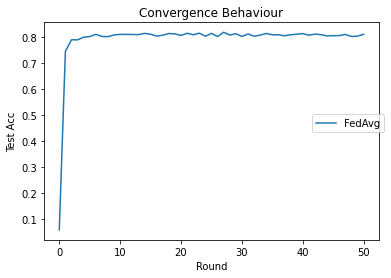

In [56]:
plot_convergence_behaviour(test_accs)

In [57]:
ultimate_aggr_model_y_preds = y_preds[-1]

In [58]:
aggr_model_precision_recall_fscore = precision_recall_fscore(y_test, ultimate_aggr_model_y_preds)

In [59]:
get_utility_measure_on_distributions(aggr_model_precision_recall_fscore, avg_local_model_precision_recall_fscore)

Distribution Precision       Recall       F1-score      
                 Aggr. Local  Aggr. Local    Aggr. Local
iid               0.62  0.56    0.7  0.63     0.65  0.59

## [Federated Optimization Problem](https://arxiv.org/pdf/1602.05629.pdf)

The optimization problem implicit in federated learning is known as the federated optimization problem, drawing a contrast to the distributed optimization problem. The key properties that differentiate federated optimization is unbalancedness (different clients can hold different amounts of data) and that the IID assumption, $\forall k.\mathbb{E}_{\mathcal{P}_k}[F_k(w)] = f(w)$, does not hold. That is to say that $F_k$ could be an arbitrarily bad approximation to $f$.

Here we focus on horizontal federated learning, where the clients share the same feature space but different sample space (in contrast to vertical federated learning, where the clients have different feature and sample spaces).

An [existing study](https://arxiv.org/pdf/1912.04977.pdf) gives a taxonomy of non-IID data distribution cases. Consider the local data distribution $P(x_i, y_i)$. We can rewrite $P(x_i, y_i)$ as $P(x_i | y_i)P(y_i)$ and $P(y_i | x_i)P(x_i)$ so that we can more precisely show the differences between cases. The study gives 5 different non-IID cases:

(1) label distribution skew (i.e., $P(y_i)$ is different among clients)

(2) feature distribution skew (i.e., $P(x_i)$ is different among clients) 

(3) same labels but different features (i.e., $P(x_i|y_i)$ is different among clients) 

(4) same features but different labels (i.e., $P(y_i|x_i)$ is different among
clients)

(5) quantity skew (i.e., $P(x_i, y_i)$ is the same but the amount of data is different among clients) 

Here, (3) is mainly related to vertical FL (the clients share the same sample IDs but different features). (4) is not applicable in most FL studies, which assume there is a common knowledge $P(y|x)$ among the clients to learn. (2) can be simulated on a dataset by adding different levels of noise to different partitions. In computer vision, these transformations can be done on the fly, using data generators e.g. for Gaussian noise. However, [this isn't the case with NLP](https://neptune.ai/blog/data-augmentation-nlp) due to the grammatical structure of the text; a new carefully augmented dataset must be generated beforehand.

Thus, we consider (5) quantity skew and (1) label distribution skew as possible non-IID data distribution cases.

# Quantity Skew

The size of the local dataset, $|{\mathcal{P}}_k|$, varies across clients. Although, the iid assumption still holds. We use a Dirichlet distribution to allocate different amounts of data samples to each client. We sample $q ∼ Dir_N (β)$, and allocate a $q_j$ proportion of the total data samples to ${\mathcal{P}}_j$ . The distribution parameter, $β>0$, can be used to control the degree of imbalance. The smaller $β$ is, the more imbalanced the distribution.

This scenario is relevant as in the real world some users/organisations will generate much more data than others, leading to varying amounts of local training data.

In [60]:
# Overrides to global experiment config
DATA_PARTITIONING_STRATEGY = "iid-quantity-skew"

In [61]:
# Split train set into NUMBER_OF_CLIENTS partitions.
partitioned_train_set = get_partitions(X_train, y_train.to_numpy())

In [62]:
get_label_freqs(partitioned_train_set)

,y_train,client0,client1,client2,client3,client4,client5,client6,client7,client8,client9,client10,client11,client12,client13,client14,client15,client16,client17,client18,client19
1,17270,1302,1006,840,663,767,1167,515,783,908,454,1088,500,910,965,1361,827,976,737,620,881
2,3747,289,239,191,121,153,260,109,144,249,97,233,101,191,247,280,152,195,149,169,178
0,1287,103,78,67,51,44,88,47,64,66,36,86,38,56,77,81,62,74,68,46,55


In [63]:
get_label_freqs(partitioned_train_set, relative=True)

,y_train,client0,client1,client2,client3,client4,client5,client6,client7,client8,client9,client10,client11,client12,client13,client14,client15,client16,client17,client18,client19
1,0.774301,0.768595,0.760393,0.765027,0.794012,0.795643,0.770297,0.767511,0.790111,0.742437,0.773424,0.773276,0.782473,0.786517,0.748642,0.790360,0.794428,0.783936,0.772537,0.742515,0.790844
2,0.167997,0.170602,0.180650,0.173953,0.144910,0.158714,0.171617,0.162444,0.145308,0.203598,0.165247,0.165601,0.158059,0.165082,0.191621,0.162602,0.146013,0.156627,0.156184,0.202395,0.159785
0,0.057703,0.060803,0.058957,0.061020,0.061078,0.045643,0.058086,0.070045,0.064581,0.053966,0.061329,0.061123,0.059468,0.048401,0.059736,0.047038,0.059558,0.059438,0.071279,0.055090,0.049372


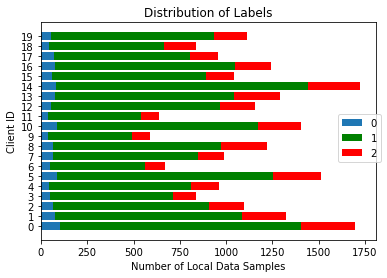

In [64]:
plot_distribution_of_labels(partitioned_train_set)

In [65]:
# Evaluate local models trained on local data
local_models_y_preds = evaluate_local_models(partitioned_train_set)

In [66]:
precision_recall_fscores_of_local_models = get_precision_recall_fscores_of_local_models(y_test, local_models_y_preds)

In [67]:
avg_local_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_models)

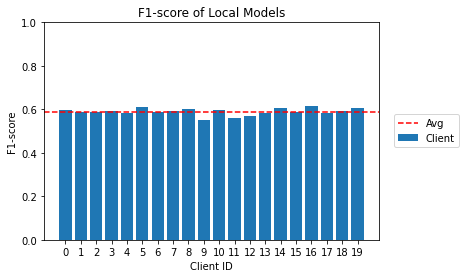

In [68]:
plot_performance_of_local_models(precision_recall_fscores_of_local_models, avg_local_model_precision_recall_fscore)

In [69]:
print_measures_of_dispersion(precision_recall_fscores_of_local_models)

Variance of F1-score across local models: 0.0002508497046083585
Standard Deviation of F1-score across local models: 0.01583823552698843


In [70]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set)

INFO flower 2022-02-12 23:10:07,057 | app.py:80 | Flower server running (insecure, 50 rounds)
INFO flower 2022-02-12 23:10:07,061 | server.py:118 | Initializing global parameters
INFO flower 2022-02-12 23:10:07,063 | server.py:304 | Requesting initial parameters from one random client


initializing Client0 with pid 6346


DEBUG flower 2022-02-12 23:10:09,076 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:09,078 | connection.py:36 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-02-12 23:10:09,080 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:10:09,081 | app.py:61 | Opened (insecure) gRPC connection
INFO flower 2022-02-12 23:10:09,085 | server.py:307 | Received initial parameters from one random client
INFO flower 2022-02-12 23:10:09,087 | server.py:120 | Evaluating initial parameters


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.06      1.00      0.11       143
           1       0.00      0.00      0.00      1920
           2       0.00      0.00      0.00       416

    accuracy                           0.06      2479
   macro avg       0.02      0.33      0.04      2479
weighted avg       0.00      0.06      0.01      2479

Calculating probability estimates
Probability estimates: [[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 ...
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:09,195 | server.py:127 | initial parameters (loss, other metrics): 1.0986122886681096, {'accuracy': 0.057684550221863654}
INFO flower 2022-02-12 23:10:09,200 | server.py:133 | FL starting


initializing Client1 with pid 6415


DEBUG flower 2022-02-12 23:10:10,092 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:10,094 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:10:10,095 | app.py:61 | Opened (insecure) gRPC connection


initializing Client2 with pid 6435


DEBUG flower 2022-02-12 23:10:11,108 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:11,111 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:10:11,110 | app.py:61 | Opened (insecure) gRPC connection


initializing Client3 with pid 6455


DEBUG flower 2022-02-12 23:10:12,136 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:12,139 | connection.py:36 | ChannelConnectivity.CONNECTING
INFO flower 2022-02-12 23:10:12,141 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:10:12,143 | connection.py:36 | ChannelConnectivity.READY


initializing Client4 with pid 6477


DEBUG flower 2022-02-12 23:10:13,151 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:13,153 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:10:13,154 | app.py:61 | Opened (insecure) gRPC connection


initializing Client5 with pid 6497


DEBUG flower 2022-02-12 23:10:14,174 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:14,177 | connection.py:36 | ChannelConnectivity.CONNECTING
INFO flower 2022-02-12 23:10:14,179 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:10:14,180 | connection.py:36 | ChannelConnectivity.READY


initializing Client6 with pid 6521


DEBUG flower 2022-02-12 23:10:15,190 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:15,192 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:10:15,192 | app.py:61 | Opened (insecure) gRPC connection


initializing Client7 with pid 6541


DEBUG flower 2022-02-12 23:10:16,207 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:16,210 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:10:16,211 | app.py:61 | Opened (insecure) gRPC connection


initializing Client8 with pid 6563


DEBUG flower 2022-02-12 23:10:17,225 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:17,228 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:10:17,229 | app.py:61 | Opened (insecure) gRPC connection


initializing Client9 with pid 6584


DEBUG flower 2022-02-12 23:10:18,241 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:18,243 | connection.py:36 | ChannelConnectivity.CONNECTING
INFO flower 2022-02-12 23:10:18,244 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:10:18,246 | connection.py:36 | ChannelConnectivity.READY


initializing Client10 with pid 6606


DEBUG flower 2022-02-12 23:10:19,259 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:19,261 | connection.py:36 | ChannelConnectivity.CONNECTING
INFO flower 2022-02-12 23:10:19,262 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:10:19,263 | connection.py:36 | ChannelConnectivity.READY


initializing Client11 with pid 6628


DEBUG flower 2022-02-12 23:10:20,273 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:10:20,277 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:10:20,277 | connection.py:36 | ChannelConnectivity.READY


initializing Client12 with pid 6649


DEBUG flower 2022-02-12 23:10:21,292 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:21,294 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:10:21,295 | app.py:61 | Opened (insecure) gRPC connection


initializing Client13 with pid 6669


DEBUG flower 2022-02-12 23:10:22,318 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:10:22,322 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:10:22,323 | connection.py:36 | ChannelConnectivity.READY


initializing Client14 with pid 6689


DEBUG flower 2022-02-12 23:10:23,336 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:10:23,338 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:10:23,339 | connection.py:36 | ChannelConnectivity.READY


initializing Client15 with pid 6709


DEBUG flower 2022-02-12 23:10:24,351 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:10:24,353 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:10:24,355 | connection.py:36 | ChannelConnectivity.READY


initializing Client16 with pid 6729


DEBUG flower 2022-02-12 23:10:25,368 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:10:25,370 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:10:25,371 | connection.py:36 | ChannelConnectivity.READY


initializing Client17 with pid 6749


DEBUG flower 2022-02-12 23:10:26,386 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:10:26,389 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:10:26,390 | connection.py:36 | ChannelConnectivity.READY


initializing Client18 with pid 6770


DEBUG flower 2022-02-12 23:10:27,405 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:27,408 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:10:27,407 | app.py:61 | Opened (insecure) gRPC connection


initializing Client19 with pid 6791


DEBUG flower 2022-02-12 23:10:28,421 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:10:28,423 | connection.py:36 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-02-12 23:10:28,424 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)
INFO flower 2022-02-12 23:10:28,424 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:10:28,425 | connection.py:36 | ChannelConnectivity.READY


Client2 with pid 6435 is sampled in rnd 1
Client18 with pid 6770 is sampled in rnd 1
Client8 with pid 6563 is sampled in rnd 1
Client3 with pid 6455 is sampled in rnd 1
Client15 with pid 6709 is sampled in rnd 1
Client12 with pid 6649 is sampled in rnd 1
Client7 with pid 6541 is sampled in rnd 1
Client13 with pid 6669 is sampled in rnd 1
Client10 with pid 6606 is sampled in rnd 1
Client6 with pid 6521 is sampled in rnd 1
Client16 with pid 6729 is sampled in rnd 1
Client1 with pid 6415 is sampled in rnd 1
Client14 with pid 6689 is sampled in rnd 1
Client0 with pid 6346 is sampled in rnd 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finish

DEBUG flower 2022-02-12 23:10:29,762 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.26      0.48      0.33       143
           1       0.92      0.78      0.84      1920
           2       0.53      0.75      0.62       416

    accuracy                           0.75      2479
   macro avg       0.57      0.67      0.60      2479
weighted avg       0.81      0.75      0.77      2479

Calculating probability estimates
Probability estimates: [[0.30018961 0.60400359 0.0958068 ]
 [0.00231654 0.00178042 0.99590304]
 [0.10480562 0.76692162 0.12827276]
 ...
 [0.05700204 0.83148223 0.11151573]
 [0.12422422 0.70378183 0.17199395]
 [0.07627895 0.82532283 0.09839822]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:29,917 | server.py:154 | fit progress: (1, 0.64484104193668, {'accuracy': 0.754739814441307}, 20.712536421000095)
INFO flower 2022-02-12 23:10:29,922 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:29,927 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 6649 is sampled in rnd 2
Client13 with pid 6669 is sampled in rnd 2
Client0 with pid 6346 is sampled in rnd 2
Client14 with pid 6689 is sampled in rnd 2
Client8 with pid 6563 is sampled in rnd 2
Client19 with pid 6791 is sampled in rnd 2
Client11 with pid 6628 is sampled in rnd 2
Client3 with pid 6455 is sampled in rnd 2
Client1 with pid 6415 is sampled in rnd 2
Client9 with pid 6584 is sampled in rnd 2
Client5 with pid 6497 is sampled in rnd 2
Client17 with pid 6749 is sampled in rnd 2
Client15 with pid 6709 is sampled in rnd 2
Client7 with pid 6541 is sampled in rnd 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finish

DEBUG flower 2022-02-12 23:10:31,385 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.45      0.39       143
           1       0.93      0.82      0.87      1920
           2       0.57      0.82      0.67       416

    accuracy                           0.80      2479
   macro avg       0.61      0.70      0.64      2479
weighted avg       0.83      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[0.13865097 0.76504254 0.09630649]
 [0.00160459 0.00457347 0.99382194]
 [0.13569267 0.74117293 0.12313439]
 ...
 [0.06377894 0.83195012 0.10427094]
 [0.14542064 0.64975775 0.20482161]
 [0.05608509 0.83504453 0.10887038]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:31,509 | server.py:154 | fit progress: (2, 0.5611155847444659, {'accuracy': 0.7966922146026624}, 22.304710430000114)
INFO flower 2022-02-12 23:10:31,516 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:31,520 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 6346 is sampled in rnd 3
Client17 with pid 6749 is sampled in rnd 3
Client12 with pid 6649 is sampled in rnd 3
Client6 with pid 6521 is sampled in rnd 3
Client13 with pid 6669 is sampled in rnd 3
Client11 with pid 6628 is sampled in rnd 3
Client8 with pid 6563 is sampled in rnd 3
Client18 with pid 6770 is sampled in rnd 3
Client3 with pid 6455 is sampled in rnd 3
Client7 with pid 6541 is sampled in rnd 3
Client10 with pid 6606 is sampled in rnd 3
Client19 with pid 6791 is sampled in rnd 3
Client14 with pid 6689 is sampled in rnd 3
Client2 with pid 6435 is sampled in rnd 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finis

DEBUG flower 2022-02-12 23:10:32,961 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.31      0.45      0.36       143
           1       0.94      0.80      0.86      1920
           2       0.56      0.84      0.67       416

    accuracy                           0.79      2479
   macro avg       0.60      0.70      0.63      2479
weighted avg       0.84      0.79      0.80      2479

Calculating probability estimates
Probability estimates: [[0.07015061 0.84802267 0.08182672]
 [0.00190459 0.00229868 0.99579673]
 [0.11266625 0.78451965 0.1028141 ]
 ...
 [0.05348318 0.86679735 0.07971947]
 [0.12377397 0.70828301 0.16794301]
 [0.04849595 0.85732639 0.09417766]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:33,102 | server.py:154 | fit progress: (3, 0.5730999890978847, {'accuracy': 0.7874142799515934}, 23.897967358000187)
INFO flower 2022-02-12 23:10:33,116 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:33,127 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 6541 is sampled in rnd 4
Client19 with pid 6791 is sampled in rnd 4
Client9 with pid 6584 is sampled in rnd 4
Client0 with pid 6346 is sampled in rnd 4
Client14 with pid 6689 is sampled in rnd 4
Client6 with pid 6521 is sampled in rnd 4
Client13 with pid 6669 is sampled in rnd 4
Client8 with pid 6563 is sampled in rnd 4
Client10 with pid 6606 is sampled in rnd 4
Client1 with pid 6415 is sampled in rnd 4
Client2 with pid 6435 is sampled in rnd 4
Client4 with pid 6477 is sampled in rnd 4
Client11 with pid 6628 is sampled in rnd 4
Client5 with pid 6497 is sampled in rnd 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished

DEBUG flower 2022-02-12 23:10:34,531 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.43      0.37       143
           1       0.93      0.82      0.87      1920
           2       0.58      0.83      0.68       416

    accuracy                           0.80      2479
   macro avg       0.61      0.70      0.64      2479
weighted avg       0.84      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[0.13770019 0.77893351 0.08336629]
 [0.00132067 0.00515254 0.99352679]
 [0.10381946 0.7997147  0.09646584]
 ...
 [0.05940672 0.85465227 0.08594101]
 [0.11814661 0.68331479 0.1985386 ]
 [0.05549091 0.85283531 0.09167378]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:34,680 | server.py:154 | fit progress: (4, 0.5429466800621219, {'accuracy': 0.8011294876966518}, 25.476223537000124)
INFO flower 2022-02-12 23:10:34,683 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:34,689 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 6606 is sampled in rnd 5
Client16 with pid 6729 is sampled in rnd 5
Client18 with pid 6770 is sampled in rnd 5
Client6 with pid 6521 is sampled in rnd 5
Client13 with pid 6669 is sampled in rnd 5
Client4 with pid 6477 is sampled in rnd 5
Client7 with pid 6541 is sampled in rnd 5
Client9 with pid 6584 is sampled in rnd 5
Client14 with pid 6689 is sampled in rnd 5
Client8 with pid 6563 is sampled in rnd 5
Client15 with pid 6709 is sampled in rnd 5
Client0 with pid 6346 is sampled in rnd 5
Client11 with pid 6628 is sampled in rnd 5
Client1 with pid 6415 is sampled in rnd 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finish

DEBUG flower 2022-02-12 23:10:36,089 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.45      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.85      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.06478082 0.85578817 0.07943101]
 [0.00144197 0.00352356 0.99503447]
 [0.08939448 0.83262424 0.07798127]
 ...
 [0.05866467 0.8689995  0.07233584]
 [0.09306229 0.72985199 0.17708572]
 [0.05334823 0.84849486 0.09815691]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:36,226 | server.py:154 | fit progress: (5, 0.5365390129776444, {'accuracy': 0.809197256958451}, 27.022409716000084)
INFO flower 2022-02-12 23:10:36,231 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:36,236 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 6669 is sampled in rnd 6
Client12 with pid 6649 is sampled in rnd 6
Client5 with pid 6497 is sampled in rnd 6
Client11 with pid 6628 is sampled in rnd 6
Client16 with pid 6729 is sampled in rnd 6
Client1 with pid 6415 is sampled in rnd 6
Client7 with pid 6541 is sampled in rnd 6
Client10 with pid 6606 is sampled in rnd 6
Client8 with pid 6563 is sampled in rnd 6
Client14 with pid 6689 is sampled in rnd 6
Client2 with pid 6435 is sampled in rnd 6
Client15 with pid 6709 is sampled in rnd 6
Client6 with pid 6521 is sampled in rnd 6
Client9 with pid 6584 is sampled in rnd 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finish

DEBUG flower 2022-02-12 23:10:37,657 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.45      0.38       143
           1       0.94      0.82      0.88      1920
           2       0.59      0.85      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.09641943 0.8237587  0.07982187]
 [0.00121206 0.00511516 0.99367277]
 [0.09551623 0.83947704 0.06500673]
 ...
 [0.05350127 0.88766816 0.05883056]
 [0.09863783 0.75571396 0.14564821]
 [0.04747024 0.87931412 0.07321564]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:37,795 | server.py:154 | fit progress: (6, 0.5260464681164304, {'accuracy': 0.8067769261799113}, 28.590779151000106)
INFO flower 2022-02-12 23:10:37,800 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:37,803 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 6709 is sampled in rnd 7
Client19 with pid 6791 is sampled in rnd 7
Client0 with pid 6346 is sampled in rnd 7
Client1 with pid 6415 is sampled in rnd 7
Client9 with pid 6584 is sampled in rnd 7
Client11 with pid 6628 is sampled in rnd 7
Client13 with pid 6669 is sampled in rnd 7
Client17 with pid 6749 is sampled in rnd 7
Client12 with pid 6649 is sampled in rnd 7
Client14 with pid 6689 is sampled in rnd 7
Client6 with pid 6521 is sampled in rnd 7
Client2 with pid 6435 is sampled in rnd 7
Client8 with pid 6563 is sampled in rnd 7
Client4 with pid 6477 is sampled in rnd 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finish

DEBUG flower 2022-02-12 23:10:39,304 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.47      0.39       143
           1       0.94      0.82      0.87      1920
           2       0.57      0.84      0.68       416

    accuracy                           0.80      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.84      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[0.10811838 0.79070936 0.10117226]
 [0.00230443 0.00471423 0.99298134]
 [0.0708033  0.86224498 0.06695172]
 ...
 [0.05173149 0.88214657 0.06612195]
 [0.0913053  0.72781975 0.18087496]
 [0.04256263 0.88252367 0.07491371]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:39,453 | server.py:154 | fit progress: (7, 0.5357842183671613, {'accuracy': 0.800322710770472}, 30.248485370000026)
INFO flower 2022-02-12 23:10:39,457 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:39,461 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 6346 is sampled in rnd 8
Client7 with pid 6541 is sampled in rnd 8
Client6 with pid 6521 is sampled in rnd 8
Client19 with pid 6791 is sampled in rnd 8
Client12 with pid 6649 is sampled in rnd 8
Client8 with pid 6563 is sampled in rnd 8
Client5 with pid 6497 is sampled in rnd 8
Client9 with pid 6584 is sampled in rnd 8
Client13 with pid 6669 is sampled in rnd 8
Client16 with pid 6729 is sampled in rnd 8
Client4 with pid 6477 is sampled in rnd 8
Client14 with pid 6689 is sampled in rnd 8
Client18 with pid 6770 is sampled in rnd 8
Client3 with pid 6455 is sampled in rnd 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finishe

DEBUG flower 2022-02-12 23:10:40,970 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.45      0.38       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.0561828  0.86426133 0.07955588]
 [0.00111603 0.00427976 0.99460421]
 [0.07522177 0.8636462  0.06113203]
 ...
 [0.04730297 0.90038299 0.05231404]
 [0.08180695 0.76703547 0.15115757]
 [0.03648122 0.88499926 0.07851952]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:41,118 | server.py:154 | fit progress: (8, 0.5239260181055151, {'accuracy': 0.8087938684953611}, 31.914281168000116)
INFO flower 2022-02-12 23:10:41,120 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:41,124 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 6729 is sampled in rnd 9
Client4 with pid 6477 is sampled in rnd 9
Client19 with pid 6791 is sampled in rnd 9
Client6 with pid 6521 is sampled in rnd 9
Client13 with pid 6669 is sampled in rnd 9
Client0 with pid 6346 is sampled in rnd 9
Client7 with pid 6541 is sampled in rnd 9
Client5 with pid 6497 is sampled in rnd 9
Client9 with pid 6584 is sampled in rnd 9
Client8 with pid 6563 is sampled in rnd 9
Client3 with pid 6455 is sampled in rnd 9
Client10 with pid 6606 is sampled in rnd 9
Client17 with pid 6749 is sampled in rnd 9
Client11 with pid 6628 is sampled in rnd 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finishe

DEBUG flower 2022-02-12 23:10:42,464 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.49      0.40       143
           1       0.95      0.82      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.72      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.12370472 0.78485029 0.09144499]
 [0.00140066 0.00466027 0.99393907]
 [0.07269891 0.86359224 0.06370885]
 ...
 [0.05802144 0.88083942 0.06113914]
 [0.10600314 0.71982464 0.17417221]
 [0.04938748 0.85575288 0.09485964]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:42,595 | server.py:154 | fit progress: (9, 0.5354223512591619, {'accuracy': 0.8051633723275514}, 33.390540052999995)
INFO flower 2022-02-12 23:10:42,596 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:42,598 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 6791 is sampled in rnd 10
Client13 with pid 6669 is sampled in rnd 10
Client0 with pid 6346 is sampled in rnd 10
Client10 with pid 6606 is sampled in rnd 10
Client11 with pid 6628 is sampled in rnd 10
Client16 with pid 6729 is sampled in rnd 10
Client9 with pid 6584 is sampled in rnd 10
Client7 with pid 6541 is sampled in rnd 10
Client3 with pid 6455 is sampled in rnd 10
Client15 with pid 6709 is sampled in rnd 10
Client2 with pid 6435 is sampled in rnd 10
Client8 with pid 6563 is sampled in rnd 10
Client18 with pid 6770 is sampled in rnd 10
Client6 with pid 6521 is sampled in rnd 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished f

DEBUG flower 2022-02-12 23:10:43,976 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.48      0.40       143
           1       0.94      0.82      0.88      1920
           2       0.59      0.84      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.09886404 0.80711919 0.09401676]
 [0.00168012 0.00501461 0.99330527]
 [0.0654041  0.87719042 0.05740548]
 ...
 [0.05943102 0.88427472 0.05629426]
 [0.10870042 0.72420008 0.16709951]
 [0.05142393 0.85789247 0.09068361]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:44,113 | server.py:154 | fit progress: (10, 0.522302131374751, {'accuracy': 0.8071803146430012}, 34.90888235500006)
INFO flower 2022-02-12 23:10:44,122 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:44,130 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 6435 is sampled in rnd 11
Client17 with pid 6749 is sampled in rnd 11
Client8 with pid 6563 is sampled in rnd 11
Client1 with pid 6415 is sampled in rnd 11
Client19 with pid 6791 is sampled in rnd 11
Client16 with pid 6729 is sampled in rnd 11
Client13 with pid 6669 is sampled in rnd 11
Client0 with pid 6346 is sampled in rnd 11
Client7 with pid 6541 is sampled in rnd 11
Client12 with pid 6649 is sampled in rnd 11
Client4 with pid 6477 is sampled in rnd 11
Client3 with pid 6455 is sampled in rnd 11
Client9 with pid 6584 is sampled in rnd 11
Client10 with pid 6606 is sampled in rnd 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished fo

DEBUG flower 2022-02-12 23:10:45,558 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.46      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.60      0.85      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.09431381 0.79685132 0.10883487]
 [0.00129606 0.00509176 0.99361218]
 [0.06511279 0.8691769  0.06571031]
 ...
 [0.05399036 0.88833521 0.05767443]
 [0.11539073 0.70035353 0.18425574]
 [0.04241625 0.85975107 0.09783268]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:45,699 | server.py:154 | fit progress: (11, 0.5205934891734918, {'accuracy': 0.809600645421541}, 36.494437285000004)
INFO flower 2022-02-12 23:10:45,704 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:45,709 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 6791 is sampled in rnd 12
Client5 with pid 6497 is sampled in rnd 12
Client11 with pid 6628 is sampled in rnd 12
Client9 with pid 6584 is sampled in rnd 12
Client2 with pid 6435 is sampled in rnd 12
Client15 with pid 6709 is sampled in rnd 12
Client14 with pid 6689 is sampled in rnd 12
Client4 with pid 6477 is sampled in rnd 12
Client8 with pid 6563 is sampled in rnd 12
Client13 with pid 6669 is sampled in rnd 12
Client12 with pid 6649 is sampled in rnd 12
Client16 with pid 6729 is sampled in rnd 12
Client7 with pid 6541 is sampled in rnd 12
Client18 with pid 6770 is sampled in rnd 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished 

DEBUG flower 2022-02-12 23:10:47,136 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.42      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.58      0.87      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.08215934 0.82751665 0.09032402]
 [0.00221266 0.00551298 0.99227436]
 [0.0666246  0.87196622 0.06140918]
 ...
 [0.05541945 0.89156397 0.05301658]
 [0.08632821 0.74974308 0.16392871]
 [0.04317742 0.87726961 0.07955297]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:47,280 | server.py:154 | fit progress: (12, 0.5187770267726695, {'accuracy': 0.8116175877369908}, 38.07579313200017)
INFO flower 2022-02-12 23:10:47,288 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:47,295 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 6606 is sampled in rnd 13
Client15 with pid 6709 is sampled in rnd 13
Client18 with pid 6770 is sampled in rnd 13
Client3 with pid 6455 is sampled in rnd 13
Client0 with pid 6346 is sampled in rnd 13
Client5 with pid 6497 is sampled in rnd 13
Client6 with pid 6521 is sampled in rnd 13
Client4 with pid 6477 is sampled in rnd 13
Client13 with pid 6669 is sampled in rnd 13
Client16 with pid 6729 is sampled in rnd 13
Client14 with pid 6689 is sampled in rnd 13
Client1 with pid 6415 is sampled in rnd 13
Client9 with pid 6584 is sampled in rnd 13
Client12 with pid 6649 is sampled in rnd 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished f

DEBUG flower 2022-02-12 23:10:48,776 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.45      0.39       143
           1       0.94      0.82      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.06182876 0.83893158 0.09923967]
 [0.00117418 0.00455257 0.99427325]
 [0.07888649 0.863216   0.05789751]
 ...
 [0.05856413 0.88372341 0.05771246]
 [0.09127262 0.74274962 0.16597776]
 [0.04731358 0.87078281 0.08190361]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:48,903 | server.py:154 | fit progress: (13, 0.5209023465616275, {'accuracy': 0.8087938684953611}, 39.69871451400013)
INFO flower 2022-02-12 23:10:48,904 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:48,905 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 6729 is sampled in rnd 14
Client6 with pid 6521 is sampled in rnd 14
Client0 with pid 6346 is sampled in rnd 14
Client13 with pid 6669 is sampled in rnd 14
Client7 with pid 6541 is sampled in rnd 14
Client19 with pid 6791 is sampled in rnd 14
Client18 with pid 6770 is sampled in rnd 14
Client2 with pid 6435 is sampled in rnd 14
Client14 with pid 6689 is sampled in rnd 14
Client12 with pid 6649 is sampled in rnd 14
Client15 with pid 6709 is sampled in rnd 14
Client8 with pid 6563 is sampled in rnd 14
Client17 with pid 6749 is sampled in rnd 14
Client4 with pid 6477 is sampled in rnd 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished 

DEBUG flower 2022-02-12 23:10:50,355 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.46      0.40       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.72      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.09866145 0.82024103 0.08109751]
 [0.00262048 0.00568814 0.99169138]
 [0.06422288 0.86584225 0.06993486]
 ...
 [0.05375427 0.88683918 0.05940655]
 [0.08635766 0.74466965 0.1689727 ]
 [0.04368909 0.87891232 0.07739859]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:50,485 | server.py:154 | fit progress: (14, 0.5262984443667914, {'accuracy': 0.8108108108108109}, 41.28096400300001)
INFO flower 2022-02-12 23:10:50,488 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:50,499 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 6541 is sampled in rnd 15
Client16 with pid 6729 is sampled in rnd 15
Client14 with pid 6689 is sampled in rnd 15
Client0 with pid 6346 is sampled in rnd 15
Client19 with pid 6791 is sampled in rnd 15
Client6 with pid 6521 is sampled in rnd 15
Client10 with pid 6606 is sampled in rnd 15
Client9 with pid 6584 is sampled in rnd 15
Client5 with pid 6497 is sampled in rnd 15
Client13 with pid 6669 is sampled in rnd 15
Client17 with pid 6749 is sampled in rnd 15
Client15 with pid 6709 is sampled in rnd 15
Client4 with pid 6477 is sampled in rnd 15
Client1 with pid 6415 is sampled in rnd 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished f

DEBUG flower 2022-02-12 23:10:51,936 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.45      0.40       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.07872499 0.81045028 0.11082473]
 [0.00123493 0.00504257 0.9937225 ]
 [0.07169905 0.87540366 0.05289729]
 ...
 [0.06253955 0.88488412 0.05257633]
 [0.09249812 0.75493342 0.15256846]
 [0.04565513 0.87234109 0.08200378]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:52,068 | server.py:154 | fit progress: (15, 0.5166573211341582, {'accuracy': 0.8140379185155304}, 42.86392740200017)
INFO flower 2022-02-12 23:10:52,069 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:52,077 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 6521 is sampled in rnd 16
Client1 with pid 6415 is sampled in rnd 16
Client9 with pid 6584 is sampled in rnd 16
Client2 with pid 6435 is sampled in rnd 16
Client16 with pid 6729 is sampled in rnd 16
Client4 with pid 6477 is sampled in rnd 16
Client11 with pid 6628 is sampled in rnd 16
Client15 with pid 6709 is sampled in rnd 16
Client17 with pid 6749 is sampled in rnd 16
Client14 with pid 6689 is sampled in rnd 16
Client0 with pid 6346 is sampled in rnd 16
Client19 with pid 6791 is sampled in rnd 16
Client12 with pid 6649 is sampled in rnd 16
Client13 with pid 6669 is sampled in rnd 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished 

DEBUG flower 2022-02-12 23:10:53,475 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.45      0.40       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.12058243 0.77710513 0.10231244]
 [0.00299513 0.00499286 0.99201201]
 [0.05785017 0.87990686 0.06224297]
 ...
 [0.05423425 0.89019938 0.05556638]
 [0.09253528 0.74374635 0.16371837]
 [0.03930569 0.89359865 0.06709566]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:53,631 | server.py:154 | fit progress: (16, 0.5205803634022478, {'accuracy': 0.809600645421541}, 44.4271011740002)
INFO flower 2022-02-12 23:10:53,635 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:53,640 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 6749 is sampled in rnd 17
Client6 with pid 6521 is sampled in rnd 17
Client14 with pid 6689 is sampled in rnd 17
Client5 with pid 6497 is sampled in rnd 17
Client1 with pid 6415 is sampled in rnd 17
Client13 with pid 6669 is sampled in rnd 17
Client16 with pid 6729 is sampled in rnd 17
Client11 with pid 6628 is sampled in rnd 17
Client12 with pid 6649 is sampled in rnd 17
Client9 with pid 6584 is sampled in rnd 17
Client8 with pid 6563 is sampled in rnd 17
Client19 with pid 6791 is sampled in rnd 17
Client0 with pid 6346 is sampled in rnd 17
Client18 with pid 6770 is sampled in rnd 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished 

DEBUG flower 2022-02-12 23:10:54,996 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.38      0.44      0.41       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.82      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.82      0.82      2479

Calculating probability estimates
Probability estimates: [[8.31523475e-02 8.33830624e-01 8.30170280e-02]
 [9.62804867e-04 3.02954382e-03 9.96007651e-01]
 [6.48038445e-02 8.73437893e-01 6.17582627e-02]
 ...
 [5.10332185e-02 9.01301656e-01 4.76651252e-02]
 [7.78752390e-02 7.76550303e-01 1.45574458e-01]
 [4.57760746e-02 8.84234370e-01 6.99895553e-02]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finish

INFO flower 2022-02-12 23:10:55,128 | server.py:154 | fit progress: (17, 0.5126091397531782, {'accuracy': 0.8152480839048003}, 45.924054839000064)
INFO flower 2022-02-12 23:10:55,131 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:55,144 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 6628 is sampled in rnd 18
Client6 with pid 6521 is sampled in rnd 18
Client13 with pid 6669 is sampled in rnd 18
Client3 with pid 6455 is sampled in rnd 18
Client17 with pid 6749 is sampled in rnd 18
Client7 with pid 6541 is sampled in rnd 18
Client1 with pid 6415 is sampled in rnd 18
Client10 with pid 6606 is sampled in rnd 18
Client8 with pid 6563 is sampled in rnd 18
Client15 with pid 6709 is sampled in rnd 18
Client0 with pid 6346 is sampled in rnd 18
Client4 with pid 6477 is sampled in rnd 18
Client2 with pid 6435 is sampled in rnd 18
Client14 with pid 6689 is sampled in rnd 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished fo

DEBUG flower 2022-02-12 23:10:56,556 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.48      0.40       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.85      0.69       416

    accuracy                           0.81      2479
   macro avg       0.63      0.72      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.09333157 0.81895069 0.08771774]
 [0.00259899 0.00564526 0.99175575]
 [0.07484687 0.85348243 0.07167071]
 ...
 [0.05231646 0.87285213 0.07483141]
 [0.10204942 0.70696998 0.1909806 ]
 [0.04754547 0.8706677  0.08178683]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:56,705 | server.py:154 | fit progress: (18, 0.5264104767487577, {'accuracy': 0.8079870915691811}, 47.501410205000184)
INFO flower 2022-02-12 23:10:56,708 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:56,713 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 6791 is sampled in rnd 19
Client12 with pid 6649 is sampled in rnd 19
Client9 with pid 6584 is sampled in rnd 19
Client5 with pid 6497 is sampled in rnd 19
Client0 with pid 6346 is sampled in rnd 19
Client13 with pid 6669 is sampled in rnd 19
Client3 with pid 6455 is sampled in rnd 19
Client15 with pid 6709 is sampled in rnd 19
Client17 with pid 6749 is sampled in rnd 19
Client2 with pid 6435 is sampled in rnd 19
Client18 with pid 6770 is sampled in rnd 19
Client14 with pid 6689 is sampled in rnd 19
Client6 with pid 6521 is sampled in rnd 19
Client10 with pid 6606 is sampled in rnd 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished 

DEBUG flower 2022-02-12 23:10:58,203 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.43      0.39       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.87      0.69       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.06954083 0.8347312  0.09572796]
 [0.00110475 0.00370284 0.99519241]
 [0.07048826 0.86457451 0.06493724]
 ...
 [0.05433917 0.88669978 0.05896104]
 [0.10544348 0.74519687 0.14935964]
 [0.03825555 0.8958926  0.06585185]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:58,347 | server.py:154 | fit progress: (19, 0.5180493834690718, {'accuracy': 0.809600645421541}, 49.143331967999984)
INFO flower 2022-02-12 23:10:58,350 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:58,355 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 6455 is sampled in rnd 20
Client17 with pid 6749 is sampled in rnd 20
Client8 with pid 6563 is sampled in rnd 20
Client12 with pid 6649 is sampled in rnd 20
Client19 with pid 6791 is sampled in rnd 20
Client18 with pid 6770 is sampled in rnd 20
Client11 with pid 6628 is sampled in rnd 20
Client1 with pid 6415 is sampled in rnd 20
Client15 with pid 6709 is sampled in rnd 20
Client0 with pid 6346 is sampled in rnd 20
Client16 with pid 6729 is sampled in rnd 20
Client2 with pid 6435 is sampled in rnd 20
Client13 with pid 6669 is sampled in rnd 20
Client9 with pid 6584 is sampled in rnd 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished 

DEBUG flower 2022-02-12 23:10:59,741 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.45      0.38       143
           1       0.94      0.82      0.87      1920
           2       0.58      0.86      0.69       416

    accuracy                           0.80      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.84      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.13803487 0.75822865 0.10373648]
 [0.0025379  0.00451486 0.99294724]
 [0.06884635 0.86048636 0.0706673 ]
 ...
 [0.0560848  0.88440221 0.05951299]
 [0.09660741 0.7219426  0.18144999]
 [0.04497723 0.87531034 0.07971243]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:10:59,869 | server.py:154 | fit progress: (20, 0.5295796096484858, {'accuracy': 0.8027430415490117}, 50.665222459000006)
INFO flower 2022-02-12 23:10:59,872 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:10:59,882 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 6521 is sampled in rnd 21
Client17 with pid 6749 is sampled in rnd 21
Client5 with pid 6497 is sampled in rnd 21
Client10 with pid 6606 is sampled in rnd 21
Client14 with pid 6689 is sampled in rnd 21
Client8 with pid 6563 is sampled in rnd 21
Client13 with pid 6669 is sampled in rnd 21
Client19 with pid 6791 is sampled in rnd 21
Client1 with pid 6415 is sampled in rnd 21
Client4 with pid 6477 is sampled in rnd 21
Client3 with pid 6455 is sampled in rnd 21
Client7 with pid 6541 is sampled in rnd 21
Client2 with pid 6435 is sampled in rnd 21
Client16 with pid 6729 is sampled in rnd 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished fo

DEBUG flower 2022-02-12 23:11:01,340 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.45      0.40       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.06363851 0.8531804  0.08318108]
 [0.00165623 0.00483537 0.9935084 ]
 [0.07523595 0.85997579 0.06478825]
 ...
 [0.05171259 0.89389133 0.05439608]
 [0.09458322 0.74458742 0.16082936]
 [0.03974254 0.87747795 0.08277951]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:01,485 | server.py:154 | fit progress: (21, 0.5197822316637141, {'accuracy': 0.8140379185155304}, 52.280834226000025)
INFO flower 2022-02-12 23:11:01,490 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:01,493 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 6749 is sampled in rnd 22
Client3 with pid 6455 is sampled in rnd 22
Client10 with pid 6606 is sampled in rnd 22
Client1 with pid 6415 is sampled in rnd 22
Client13 with pid 6669 is sampled in rnd 22
Client16 with pid 6729 is sampled in rnd 22
Client12 with pid 6649 is sampled in rnd 22
Client2 with pid 6435 is sampled in rnd 22
Client6 with pid 6521 is sampled in rnd 22
Client11 with pid 6628 is sampled in rnd 22
Client5 with pid 6497 is sampled in rnd 22
Client14 with pid 6689 is sampled in rnd 22
Client15 with pid 6709 is sampled in rnd 22
Client0 with pid 6346 is sampled in rnd 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished 

DEBUG flower 2022-02-12 23:11:02,943 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.46      0.40       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.87      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.72      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.08280203 0.82105214 0.09614582]
 [0.00196656 0.0053702  0.99266324]
 [0.07731763 0.85845947 0.0642229 ]
 ...
 [0.05227914 0.88692597 0.06079489]
 [0.09721017 0.74393301 0.15885682]
 [0.04478833 0.88062141 0.07459025]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:03,078 | server.py:154 | fit progress: (22, 0.5218441225325106, {'accuracy': 0.8132311415893505}, 53.87400118599999)
INFO flower 2022-02-12 23:11:03,083 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:03,088 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 6749 is sampled in rnd 23
Client7 with pid 6541 is sampled in rnd 23
Client18 with pid 6770 is sampled in rnd 23
Client2 with pid 6435 is sampled in rnd 23
Client5 with pid 6497 is sampled in rnd 23
Client8 with pid 6563 is sampled in rnd 23
Client4 with pid 6477 is sampled in rnd 23
Client9 with pid 6584 is sampled in rnd 23
Client15 with pid 6709 is sampled in rnd 23
Client1 with pid 6415 is sampled in rnd 23
Client19 with pid 6791 is sampled in rnd 23
Client13 with pid 6669 is sampled in rnd 23
Client10 with pid 6606 is sampled in rnd 23
Client6 with pid 6521 is sampled in rnd 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished fo

DEBUG flower 2022-02-12 23:11:04,436 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.50      0.42       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.85      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.73      0.67      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.17514648 0.71871426 0.10613926]
 [0.0016785  0.00443247 0.99388903]
 [0.07098539 0.87183323 0.05718137]
 ...
 [0.06032619 0.88463429 0.05503952]
 [0.10712058 0.72852884 0.16435059]
 [0.04558697 0.87640469 0.07800835]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:04,598 | server.py:154 | fit progress: (23, 0.5254882999822904, {'accuracy': 0.8116175877369908}, 55.393957811000064)
INFO flower 2022-02-12 23:11:04,600 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:04,609 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 6415 is sampled in rnd 24
Client9 with pid 6584 is sampled in rnd 24
Client17 with pid 6749 is sampled in rnd 24
Client19 with pid 6791 is sampled in rnd 24
Client12 with pid 6649 is sampled in rnd 24
Client6 with pid 6521 is sampled in rnd 24
Client16 with pid 6729 is sampled in rnd 24
Client0 with pid 6346 is sampled in rnd 24
Client2 with pid 6435 is sampled in rnd 24
Client3 with pid 6455 is sampled in rnd 24
Client10 with pid 6606 is sampled in rnd 24
Client14 with pid 6689 is sampled in rnd 24
Client15 with pid 6709 is sampled in rnd 24
Client11 with pid 6628 is sampled in rnd 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished 

DEBUG flower 2022-02-12 23:11:06,052 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.44      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.04757865 0.8512502  0.10117115]
 [0.00199712 0.00436068 0.99364219]
 [0.0782281  0.86132999 0.06044191]
 ...
 [0.05444644 0.89054348 0.05501008]
 [0.12088246 0.71501751 0.16410003]
 [0.03466382 0.89940291 0.06593327]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:06,191 | server.py:154 | fit progress: (24, 0.5200838348158137, {'accuracy': 0.8108108108108109}, 56.987007231999996)
INFO flower 2022-02-12 23:11:06,200 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:06,206 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client5 with pid 6497 is sampled in rnd 25
Client7 with pid 6541 is sampled in rnd 25
Client14 with pid 6689 is sampled in rnd 25
Client18 with pid 6770 is sampled in rnd 25
Client3 with pid 6455 is sampled in rnd 25
Client6 with pid 6521 is sampled in rnd 25
Client19 with pid 6791 is sampled in rnd 25
Client12 with pid 6649 is sampled in rnd 25
Client8 with pid 6563 is sampled in rnd 25
Client4 with pid 6477 is sampled in rnd 25
Client11 with pid 6628 is sampled in rnd 25
Client10 with pid 6606 is sampled in rnd 25
Client17 with pid 6749 is sampled in rnd 25
Client2 with pid 6435 is sampled in rnd 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished f

DEBUG flower 2022-02-12 23:11:07,563 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.44      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.08873904 0.83054563 0.08071533]
 [0.00221993 0.00583387 0.99194619]
 [0.06663225 0.85433377 0.07903399]
 ...
 [0.04346298 0.89479191 0.0617451 ]
 [0.09508199 0.72898448 0.17593353]
 [0.03669112 0.88713625 0.07617263]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:07,726 | server.py:154 | fit progress: (25, 0.5178634638015888, {'accuracy': 0.8104074223477209}, 58.522098614000015)
INFO flower 2022-02-12 23:11:07,731 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:07,737 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 6521 is sampled in rnd 26
Client3 with pid 6455 is sampled in rnd 26
Client0 with pid 6346 is sampled in rnd 26
Client12 with pid 6649 is sampled in rnd 26
Client1 with pid 6415 is sampled in rnd 26
Client15 with pid 6709 is sampled in rnd 26
Client10 with pid 6606 is sampled in rnd 26
Client11 with pid 6628 is sampled in rnd 26
Client9 with pid 6584 is sampled in rnd 26
Client4 with pid 6477 is sampled in rnd 26
Client5 with pid 6497 is sampled in rnd 26
Client18 with pid 6770 is sampled in rnd 26
Client7 with pid 6541 is sampled in rnd 26
Client2 with pid 6435 is sampled in rnd 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for

DEBUG flower 2022-02-12 23:11:09,061 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.44      0.38       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.08563322 0.79996967 0.11439711]
 [0.00159928 0.00464067 0.99376005]
 [0.08446206 0.85322301 0.06231494]
 ...
 [0.05681402 0.87387826 0.06930771]
 [0.1168634  0.70379132 0.17934528]
 [0.04310148 0.87072784 0.08617069]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:09,196 | server.py:154 | fit progress: (26, 0.5193684911748594, {'accuracy': 0.809600645421541}, 59.99208141000008)
INFO flower 2022-02-12 23:11:09,202 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:09,207 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 6649 is sampled in rnd 27
Client2 with pid 6435 is sampled in rnd 27
Client10 with pid 6606 is sampled in rnd 27
Client18 with pid 6770 is sampled in rnd 27
Client14 with pid 6689 is sampled in rnd 27
Client4 with pid 6477 is sampled in rnd 27
Client1 with pid 6415 is sampled in rnd 27
Client3 with pid 6455 is sampled in rnd 27
Client9 with pid 6584 is sampled in rnd 27
Client8 with pid 6563 is sampled in rnd 27
Client7 with pid 6541 is sampled in rnd 27
Client5 with pid 6497 is sampled in rnd 27
Client13 with pid 6669 is sampled in rnd 27
Client15 with pid 6709 is sampled in rnd 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished fo

DEBUG flower 2022-02-12 23:11:10,574 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.42      0.38       143
           1       0.94      0.84      0.89      1920
           2       0.60      0.86      0.70       416

    accuracy                           0.82      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.82      0.83      2479

Calculating probability estimates
Probability estimates: [[0.08944084 0.80791397 0.10264518]
 [0.00143609 0.00473524 0.99382867]
 [0.07100224 0.86915328 0.05984448]
 ...
 [0.04566106 0.9014248  0.05291414]
 [0.10229904 0.74032304 0.15737792]
 [0.04726969 0.88010442 0.07262589]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:10,702 | server.py:154 | fit progress: (27, 0.5110188025345793, {'accuracy': 0.8168616377571601}, 61.498351942)
INFO flower 2022-02-12 23:11:10,710 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:10,714 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 6749 is sampled in rnd 28
Client6 with pid 6521 is sampled in rnd 28
Client9 with pid 6584 is sampled in rnd 28
Client18 with pid 6770 is sampled in rnd 28
Client7 with pid 6541 is sampled in rnd 28
Client5 with pid 6497 is sampled in rnd 28
Client1 with pid 6415 is sampled in rnd 28
Client13 with pid 6669 is sampled in rnd 28
Client15 with pid 6709 is sampled in rnd 28
Client4 with pid 6477 is sampled in rnd 28
Client11 with pid 6628 is sampled in rnd 28
Client14 with pid 6689 is sampled in rnd 28
Client3 with pid 6455 is sampled in rnd 28
Client10 with pid 6606 is sampled in rnd 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished f

DEBUG flower 2022-02-12 23:11:12,087 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.37      0.43      0.40       143
           1       0.94      0.84      0.89      1920
           2       0.59      0.88      0.71       416

    accuracy                           0.82      2479
   macro avg       0.64      0.71      0.66      2479
weighted avg       0.85      0.82      0.83      2479

Calculating probability estimates
Probability estimates: [[0.08027182 0.80846841 0.11125977]
 [0.00157467 0.00400539 0.99441994]
 [0.08077861 0.86450136 0.05472003]
 ...
 [0.05236714 0.88965091 0.05798195]
 [0.09639232 0.75741753 0.14619015]
 [0.04716069 0.87980088 0.07303843]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:12,226 | server.py:154 | fit progress: (28, 0.5157153043910231, {'accuracy': 0.8188785800726099}, 63.022347282000055)
INFO flower 2022-02-12 23:11:12,232 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:12,241 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 6584 is sampled in rnd 29
Client5 with pid 6497 is sampled in rnd 29
Client10 with pid 6606 is sampled in rnd 29
Client13 with pid 6669 is sampled in rnd 29
Client17 with pid 6749 is sampled in rnd 29
Client12 with pid 6649 is sampled in rnd 29
Client1 with pid 6415 is sampled in rnd 29
Client19 with pid 6791 is sampled in rnd 29
Client4 with pid 6477 is sampled in rnd 29
Client3 with pid 6455 is sampled in rnd 29
Client16 with pid 6729 is sampled in rnd 29
Client18 with pid 6770 is sampled in rnd 29
Client8 with pid 6563 is sampled in rnd 29
Client7 with pid 6541 is sampled in rnd 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished f

DEBUG flower 2022-02-12 23:11:13,603 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.45      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.60      0.87      0.71       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.08520661 0.80251835 0.11227504]
 [0.00112333 0.00379166 0.99508501]
 [0.0795358  0.85232201 0.06814218]
 ...
 [0.05179173 0.89893496 0.04927331]
 [0.10707605 0.7240738  0.16885015]
 [0.04362968 0.87510402 0.0812663 ]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:13,760 | server.py:154 | fit progress: (29, 0.5173847707294554, {'accuracy': 0.8132311415893505}, 64.55545689900009)
INFO flower 2022-02-12 23:11:13,769 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:13,770 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 6346 is sampled in rnd 30
Client12 with pid 6649 is sampled in rnd 30
Client7 with pid 6541 is sampled in rnd 30
Client19 with pid 6791 is sampled in rnd 30
Client8 with pid 6563 is sampled in rnd 30
Client1 with pid 6415 is sampled in rnd 30
Client11 with pid 6628 is sampled in rnd 30
Client2 with pid 6435 is sampled in rnd 30
Client16 with pid 6729 is sampled in rnd 30
Client4 with pid 6477 is sampled in rnd 30
Client18 with pid 6770 is sampled in rnd 30
Client14 with pid 6689 is sampled in rnd 30
Client9 with pid 6584 is sampled in rnd 30
Client6 with pid 6521 is sampled in rnd 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished fo

DEBUG flower 2022-02-12 23:11:15,188 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.45      0.40       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.86      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.0485582  0.81864699 0.13279481]
 [0.00191749 0.00379012 0.99429239]
 [0.07686841 0.86576909 0.05736249]
 ...
 [0.05448823 0.88330358 0.06220818]
 [0.10270806 0.71753322 0.17975872]
 [0.05027225 0.85685246 0.09287529]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:15,307 | server.py:154 | fit progress: (30, 0.5240557203470585, {'accuracy': 0.8067769261799113}, 66.10340710600008)
INFO flower 2022-02-12 23:11:15,315 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:15,320 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 6628 is sampled in rnd 31
Client15 with pid 6709 is sampled in rnd 31
Client4 with pid 6477 is sampled in rnd 31
Client18 with pid 6770 is sampled in rnd 31
Client3 with pid 6455 is sampled in rnd 31
Client8 with pid 6563 is sampled in rnd 31
Client12 with pid 6649 is sampled in rnd 31
Client13 with pid 6669 is sampled in rnd 31
Client5 with pid 6497 is sampled in rnd 31
Client1 with pid 6415 is sampled in rnd 31
Client14 with pid 6689 is sampled in rnd 31
Client2 with pid 6435 is sampled in rnd 31
Client9 with pid 6584 is sampled in rnd 31
Client6 with pid 6521 is sampled in rnd 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished fo

DEBUG flower 2022-02-12 23:11:16,762 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.45      0.40       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.87      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.72      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.15067435 0.73893418 0.11039147]
 [0.00197761 0.0057327  0.99228969]
 [0.06685483 0.87598316 0.057162  ]
 ...
 [0.04837106 0.89300643 0.05862251]
 [0.08394786 0.75935572 0.15669642]
 [0.05201917 0.87502619 0.07295464]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:16,905 | server.py:154 | fit progress: (31, 0.5208001042754222, {'accuracy': 0.8132311415893505}, 67.70080179700017)
INFO flower 2022-02-12 23:11:16,911 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:16,918 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 6477 is sampled in rnd 32
Client10 with pid 6606 is sampled in rnd 32
Client9 with pid 6584 is sampled in rnd 32
Client19 with pid 6791 is sampled in rnd 32
Client11 with pid 6628 is sampled in rnd 32
Client16 with pid 6729 is sampled in rnd 32
Client18 with pid 6770 is sampled in rnd 32
Client3 with pid 6455 is sampled in rnd 32
Client2 with pid 6435 is sampled in rnd 32
Client8 with pid 6563 is sampled in rnd 32
Client15 with pid 6709 is sampled in rnd 32
Client17 with pid 6749 is sampled in rnd 32
Client0 with pid 6346 is sampled in rnd 32
Client6 with pid 6521 is sampled in rnd 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished f

DEBUG flower 2022-02-12 23:11:18,288 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.31      0.45      0.37       143
           1       0.94      0.81      0.87      1920
           2       0.58      0.87      0.70       416

    accuracy                           0.80      2479
   macro avg       0.61      0.71      0.65      2479
weighted avg       0.85      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.08566029 0.82363848 0.09070123]
 [0.0020666  0.00433138 0.99360203]
 [0.07933633 0.8605141  0.06014957]
 ...
 [0.06371686 0.87417094 0.0621122 ]
 [0.1329041  0.68357823 0.18351767]
 [0.04586339 0.86034974 0.09378688]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:18,405 | server.py:154 | fit progress: (32, 0.5395660987809733, {'accuracy': 0.8011294876966518}, 69.20053111700008)
INFO flower 2022-02-12 23:11:18,407 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:18,410 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 6606 is sampled in rnd 33
Client17 with pid 6749 is sampled in rnd 33
Client6 with pid 6521 is sampled in rnd 33
Client5 with pid 6497 is sampled in rnd 33
Client9 with pid 6584 is sampled in rnd 33
Client18 with pid 6770 is sampled in rnd 33
Client8 with pid 6563 is sampled in rnd 33
Client0 with pid 6346 is sampled in rnd 33
Client2 with pid 6435 is sampled in rnd 33
Client19 with pid 6791 is sampled in rnd 33
Client3 with pid 6455 is sampled in rnd 33
Client4 with pid 6477 is sampled in rnd 33
Client1 with pid 6415 is sampled in rnd 33
Client16 with pid 6729 is sampled in rnd 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for

DEBUG flower 2022-02-12 23:11:19,832 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.43      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.82      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.82      0.83      2479

Calculating probability estimates
Probability estimates: [[0.07368801 0.830175   0.09613699]
 [0.00133219 0.00508752 0.99358029]
 [0.06645916 0.87259215 0.0609487 ]
 ...
 [0.05065697 0.89395623 0.05538681]
 [0.09774225 0.73248863 0.16976912]
 [0.03885555 0.86670412 0.09444033]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:19,983 | server.py:154 | fit progress: (33, 0.513972859864833, {'accuracy': 0.8156514723678903}, 70.7793962400001)
INFO flower 2022-02-12 23:11:19,993 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:19,998 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 6689 is sampled in rnd 34
Client13 with pid 6669 is sampled in rnd 34
Client18 with pid 6770 is sampled in rnd 34
Client8 with pid 6563 is sampled in rnd 34
Client19 with pid 6791 is sampled in rnd 34
Client17 with pid 6749 is sampled in rnd 34
Client7 with pid 6541 is sampled in rnd 34
Client5 with pid 6497 is sampled in rnd 34
Client0 with pid 6346 is sampled in rnd 34
Client6 with pid 6521 is sampled in rnd 34
Client4 with pid 6477 is sampled in rnd 34
Client2 with pid 6435 is sampled in rnd 34
Client3 with pid 6455 is sampled in rnd 34
Client16 with pid 6729 is sampled in rnd 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished fo

DEBUG flower 2022-02-12 23:11:21,405 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.45      0.40       143
           1       0.94      0.83      0.88      1920
           2       0.58      0.86      0.69       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.07434504 0.85260284 0.07305212]
 [0.00232532 0.00490137 0.99277331]
 [0.07087977 0.86297326 0.06614697]
 ...
 [0.05054231 0.89079698 0.05866071]
 [0.08774218 0.74967412 0.1625837 ]
 [0.04024853 0.86627198 0.09347949]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:21,516 | server.py:154 | fit progress: (34, 0.5279551777732174, {'accuracy': 0.809600645421541}, 72.31193237700018)
INFO flower 2022-02-12 23:11:21,519 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:21,525 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 6346 is sampled in rnd 35
Client13 with pid 6669 is sampled in rnd 35
Client19 with pid 6791 is sampled in rnd 35
Client1 with pid 6415 is sampled in rnd 35
Client11 with pid 6628 is sampled in rnd 35
Client9 with pid 6584 is sampled in rnd 35
Client14 with pid 6689 is sampled in rnd 35
Client2 with pid 6435 is sampled in rnd 35
Client18 with pid 6770 is sampled in rnd 35
Client15 with pid 6709 is sampled in rnd 35
Client4 with pid 6477 is sampled in rnd 35
Client12 with pid 6649 is sampled in rnd 35
Client6 with pid 6521 is sampled in rnd 35
Client8 with pid 6563 is sampled in rnd 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished f

DEBUG flower 2022-02-12 23:11:22,892 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.45      0.38       143
           1       0.94      0.82      0.88      1920
           2       0.57      0.86      0.69       416

    accuracy                           0.80      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.11516505 0.74741474 0.1374202 ]
 [0.00129455 0.00442898 0.99427647]
 [0.07100521 0.87827358 0.05072121]
 ...
 [0.06677182 0.87550378 0.0577244 ]
 [0.10301564 0.73169076 0.16529361]
 [0.05384871 0.85689045 0.08926084]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:23,039 | server.py:154 | fit progress: (35, 0.5343453680940228, {'accuracy': 0.8023396530859217}, 73.83482438200008)
INFO flower 2022-02-12 23:11:23,043 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:23,048 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 6649 is sampled in rnd 36
Client5 with pid 6497 is sampled in rnd 36
Client2 with pid 6435 is sampled in rnd 36
Client7 with pid 6541 is sampled in rnd 36
Client17 with pid 6749 is sampled in rnd 36
Client0 with pid 6346 is sampled in rnd 36
Client15 with pid 6709 is sampled in rnd 36
Client8 with pid 6563 is sampled in rnd 36
Client18 with pid 6770 is sampled in rnd 36
Client19 with pid 6791 is sampled in rnd 36
Client16 with pid 6729 is sampled in rnd 36
Client3 with pid 6455 is sampled in rnd 36
Client10 with pid 6606 is sampled in rnd 36
Client13 with pid 6669 is sampled in rnd 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished 

DEBUG flower 2022-02-12 23:11:24,543 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.48      0.39       143
           1       0.94      0.82      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.80      2479
   macro avg       0.62      0.72      0.65      2479
weighted avg       0.85      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.13152728 0.78132946 0.08714326]
 [0.00189667 0.00479414 0.99330919]
 [0.06994731 0.86159644 0.06845625]
 ...
 [0.05415906 0.88776841 0.05807253]
 [0.09380103 0.7330667  0.17313227]
 [0.04143843 0.86716944 0.09139214]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:24,681 | server.py:154 | fit progress: (36, 0.5321040188267802, {'accuracy': 0.8039532069382815}, 75.4770242730001)
INFO flower 2022-02-12 23:11:24,689 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:24,694 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 6709 is sampled in rnd 37
Client19 with pid 6791 is sampled in rnd 37
Client7 with pid 6541 is sampled in rnd 37
Client13 with pid 6669 is sampled in rnd 37
Client10 with pid 6606 is sampled in rnd 37
Client9 with pid 6584 is sampled in rnd 37
Client8 with pid 6563 is sampled in rnd 37
Client11 with pid 6628 is sampled in rnd 37
Client18 with pid 6770 is sampled in rnd 37
Client3 with pid 6455 is sampled in rnd 37
Client4 with pid 6477 is sampled in rnd 37
Client0 with pid 6346 is sampled in rnd 37
Client1 with pid 6415 is sampled in rnd 37
Client6 with pid 6521 is sampled in rnd 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished fo

DEBUG flower 2022-02-12 23:11:26,096 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.45      0.39       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.87      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.10514749 0.77901421 0.11583829]
 [0.00134749 0.00495491 0.9936976 ]
 [0.07222569 0.86666833 0.06110598]
 ...
 [0.06809828 0.86573133 0.0661704 ]
 [0.11123719 0.68432026 0.20444256]
 [0.04599621 0.86180785 0.09219594]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:26,234 | server.py:154 | fit progress: (37, 0.5278500497257582, {'accuracy': 0.8075837031060912}, 77.03036082500012)
INFO flower 2022-02-12 23:11:26,237 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:26,239 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 6729 is sampled in rnd 38
Client11 with pid 6628 is sampled in rnd 38
Client5 with pid 6497 is sampled in rnd 38
Client6 with pid 6521 is sampled in rnd 38
Client19 with pid 6791 is sampled in rnd 38
Client4 with pid 6477 is sampled in rnd 38
Client14 with pid 6689 is sampled in rnd 38
Client18 with pid 6770 is sampled in rnd 38
Client13 with pid 6669 is sampled in rnd 38
Client8 with pid 6563 is sampled in rnd 38
Client2 with pid 6435 is sampled in rnd 38
Client7 with pid 6541 is sampled in rnd 38
Client12 with pid 6649 is sampled in rnd 38
Client17 with pid 6749 is sampled in rnd 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished 

DEBUG flower 2022-02-12 23:11:27,613 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.44      0.39       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.86      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.0905472  0.82920111 0.08025169]
 [0.00243215 0.00576781 0.99180004]
 [0.0669478  0.8696224  0.0634298 ]
 ...
 [0.04992043 0.89535063 0.05472893]
 [0.07476235 0.76738828 0.15784937]
 [0.03998181 0.87933531 0.08068288]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:27,754 | server.py:154 | fit progress: (38, 0.5224287908863806, {'accuracy': 0.8075837031060912}, 78.55008107399999)
INFO flower 2022-02-12 23:11:27,760 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:27,764 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 6435 is sampled in rnd 39
Client3 with pid 6455 is sampled in rnd 39
Client16 with pid 6729 is sampled in rnd 39
Client12 with pid 6649 is sampled in rnd 39
Client5 with pid 6497 is sampled in rnd 39
Client19 with pid 6791 is sampled in rnd 39
Client6 with pid 6521 is sampled in rnd 39
Client4 with pid 6477 is sampled in rnd 39
Client9 with pid 6584 is sampled in rnd 39
Client0 with pid 6346 is sampled in rnd 39
Client18 with pid 6770 is sampled in rnd 39
Client17 with pid 6749 is sampled in rnd 39
Client7 with pid 6541 is sampled in rnd 39
Client15 with pid 6709 is sampled in rnd 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished fo

DEBUG flower 2022-02-12 23:11:29,127 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.45      0.38       143
           1       0.94      0.82      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.09082367 0.81271744 0.09645889]
 [0.00198412 0.00456201 0.99345386]
 [0.0799632  0.86124668 0.05879012]
 ...
 [0.06614355 0.87602163 0.05783482]
 [0.11313772 0.70973177 0.17713051]
 [0.04240099 0.86630274 0.09129627]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:29,250 | server.py:154 | fit progress: (39, 0.5242529824456913, {'accuracy': 0.8067769261799113}, 80.04587539900012)
INFO flower 2022-02-12 23:11:29,257 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:29,267 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 6628 is sampled in rnd 40
Client12 with pid 6649 is sampled in rnd 40
Client16 with pid 6729 is sampled in rnd 40
Client5 with pid 6497 is sampled in rnd 40
Client1 with pid 6415 is sampled in rnd 40
Client4 with pid 6477 is sampled in rnd 40
Client15 with pid 6709 is sampled in rnd 40
Client18 with pid 6770 is sampled in rnd 40
Client8 with pid 6563 is sampled in rnd 40
Client10 with pid 6606 is sampled in rnd 40
Client13 with pid 6669 is sampled in rnd 40
Client19 with pid 6791 is sampled in rnd 40
Client9 with pid 6584 is sampled in rnd 40
Client7 with pid 6541 is sampled in rnd 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished 

DEBUG flower 2022-02-12 23:11:30,681 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.45      0.38       143
           1       0.94      0.82      0.88      1920
           2       0.59      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.12972494 0.75186726 0.11840781]
 [0.0013983  0.00484673 0.99375497]
 [0.07500244 0.86495124 0.06004632]
 ...
 [0.05993097 0.88620261 0.05386642]
 [0.09188041 0.72361137 0.18450822]
 [0.0460135  0.86293087 0.09105562]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:30,841 | server.py:154 | fit progress: (40, 0.5220493727364934, {'accuracy': 0.8087938684953611}, 81.63668913700008)
INFO flower 2022-02-12 23:11:30,846 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:30,852 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 6435 is sampled in rnd 41
Client14 with pid 6689 is sampled in rnd 41
Client7 with pid 6541 is sampled in rnd 41
Client19 with pid 6791 is sampled in rnd 41
Client6 with pid 6521 is sampled in rnd 41
Client12 with pid 6649 is sampled in rnd 41
Client15 with pid 6709 is sampled in rnd 41
Client18 with pid 6770 is sampled in rnd 41
Client13 with pid 6669 is sampled in rnd 41
Client5 with pid 6497 is sampled in rnd 41
Client16 with pid 6729 is sampled in rnd 41
Client11 with pid 6628 is sampled in rnd 41
Client9 with pid 6584 is sampled in rnd 41
Client1 with pid 6415 is sampled in rnd 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished 

DEBUG flower 2022-02-12 23:11:32,219 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.43      0.39       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.86      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.84      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.10431902 0.78940521 0.10627577]
 [0.00292257 0.00443283 0.9926446 ]
 [0.06781645 0.87851965 0.0536639 ]
 ...
 [0.05527229 0.89175482 0.05297289]
 [0.07122899 0.76867967 0.16009134]
 [0.0455064  0.88029428 0.07419932]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:32,382 | server.py:154 | fit progress: (41, 0.5211318915430391, {'accuracy': 0.8071803146430012}, 83.17762667900001)
INFO flower 2022-02-12 23:11:32,387 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:32,389 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 6455 is sampled in rnd 42
Client17 with pid 6749 is sampled in rnd 42
Client19 with pid 6791 is sampled in rnd 42
Client10 with pid 6606 is sampled in rnd 42
Client16 with pid 6729 is sampled in rnd 42
Client13 with pid 6669 is sampled in rnd 42
Client6 with pid 6521 is sampled in rnd 42
Client15 with pid 6709 is sampled in rnd 42
Client0 with pid 6346 is sampled in rnd 42
Client8 with pid 6563 is sampled in rnd 42
Client18 with pid 6770 is sampled in rnd 42
Client4 with pid 6477 is sampled in rnd 42
Client11 with pid 6628 is sampled in rnd 42
Client12 with pid 6649 is sampled in rnd 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished

DEBUG flower 2022-02-12 23:11:33,728 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.45      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.87      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.12478936 0.77028211 0.10492853]
 [0.00128546 0.00462008 0.99409446]
 [0.06529651 0.87291726 0.06178623]
 ...
 [0.05558047 0.88890398 0.05551555]
 [0.10163081 0.71152675 0.18684244]
 [0.04713629 0.85142154 0.10144217]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:33,867 | server.py:154 | fit progress: (42, 0.5176011215899127, {'accuracy': 0.8124243646631706}, 84.66288392199999)
INFO flower 2022-02-12 23:11:33,869 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:33,878 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 6770 is sampled in rnd 43
Client14 with pid 6689 is sampled in rnd 43
Client17 with pid 6749 is sampled in rnd 43
Client7 with pid 6541 is sampled in rnd 43
Client0 with pid 6346 is sampled in rnd 43
Client13 with pid 6669 is sampled in rnd 43
Client4 with pid 6477 is sampled in rnd 43
Client3 with pid 6455 is sampled in rnd 43
Client2 with pid 6435 is sampled in rnd 43
Client19 with pid 6791 is sampled in rnd 43
Client11 with pid 6628 is sampled in rnd 43
Client8 with pid 6563 is sampled in rnd 43
Client9 with pid 6584 is sampled in rnd 43
Client12 with pid 6649 is sampled in rnd 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished f

DEBUG flower 2022-02-12 23:11:35,243 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.43      0.37       143
           1       0.94      0.82      0.88      1920
           2       0.58      0.86      0.69       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.06859231 0.82641456 0.10499314]
 [0.00177981 0.00435614 0.99386405]
 [0.06842272 0.87222203 0.05935525]
 ...
 [0.04726019 0.89420927 0.05853054]
 [0.09868648 0.73942829 0.16188524]
 [0.04176602 0.868473   0.08976097]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:35,391 | server.py:154 | fit progress: (43, 0.5222991984024932, {'accuracy': 0.8055667607906414}, 86.18668440200008)
INFO flower 2022-02-12 23:11:35,394 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:35,403 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 6770 is sampled in rnd 44
Client9 with pid 6584 is sampled in rnd 44
Client5 with pid 6497 is sampled in rnd 44
Client14 with pid 6689 is sampled in rnd 44
Client8 with pid 6563 is sampled in rnd 44
Client17 with pid 6749 is sampled in rnd 44
Client15 with pid 6709 is sampled in rnd 44
Client6 with pid 6521 is sampled in rnd 44
Client7 with pid 6541 is sampled in rnd 44
Client3 with pid 6455 is sampled in rnd 44
Client1 with pid 6415 is sampled in rnd 44
Client11 with pid 6628 is sampled in rnd 44
Client19 with pid 6791 is sampled in rnd 44
Client2 with pid 6435 is sampled in rnd 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished fo

DEBUG flower 2022-02-12 23:11:36,758 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.38      0.42      0.40       143
           1       0.94      0.84      0.89      1920
           2       0.58      0.86      0.70       416

    accuracy                           0.82      2479
   macro avg       0.64      0.71      0.66      2479
weighted avg       0.85      0.82      0.83      2479

Calculating probability estimates
Probability estimates: [[0.09487416 0.79553345 0.10959239]
 [0.00176857 0.00441356 0.99381788]
 [0.06719119 0.87881531 0.0539935 ]
 ...
 [0.04724283 0.89983688 0.05292029]
 [0.08132403 0.77332309 0.14535288]
 [0.04272442 0.88237462 0.07490096]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:36,909 | server.py:154 | fit progress: (44, 0.5110923433627541, {'accuracy': 0.8176684146833401}, 87.704639842)
INFO flower 2022-02-12 23:11:36,910 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:36,915 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 6455 is sampled in rnd 45
Client19 with pid 6791 is sampled in rnd 45
Client0 with pid 6346 is sampled in rnd 45
Client9 with pid 6584 is sampled in rnd 45
Client18 with pid 6770 is sampled in rnd 45
Client10 with pid 6606 is sampled in rnd 45
Client12 with pid 6649 is sampled in rnd 45
Client11 with pid 6628 is sampled in rnd 45
Client14 with pid 6689 is sampled in rnd 45
Client8 with pid 6563 is sampled in rnd 45
Client2 with pid 6435 is sampled in rnd 45
Client1 with pid 6415 is sampled in rnd 45
Client5 with pid 6497 is sampled in rnd 45
Client4 with pid 6477 is sampled in rnd 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished fo

DEBUG flower 2022-02-12 23:11:38,348 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.43      0.37       143
           1       0.94      0.82      0.87      1920
           2       0.57      0.87      0.69       416

    accuracy                           0.80      2479
   macro avg       0.61      0.70      0.64      2479
weighted avg       0.84      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[6.54335645e-02 8.12298643e-01 1.22267793e-01]
 [9.88618691e-04 3.62268046e-03 9.95388701e-01]
 [7.52780059e-02 8.61263360e-01 6.34586337e-02]
 ...
 [4.51282533e-02 8.93280119e-01 6.15916276e-02]
 [9.69363635e-02 7.14700749e-01 1.88362887e-01]
 [4.80852611e-02 8.61641764e-01 9.02729746e-02]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finish

INFO flower 2022-02-12 23:11:38,490 | server.py:154 | fit progress: (45, 0.5255723069857898, {'accuracy': 0.8015328761597418}, 89.2856520790001)
INFO flower 2022-02-12 23:11:38,495 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:38,500 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 6584 is sampled in rnd 46
Client16 with pid 6729 is sampled in rnd 46
Client13 with pid 6669 is sampled in rnd 46
Client11 with pid 6628 is sampled in rnd 46
Client0 with pid 6346 is sampled in rnd 46
Client10 with pid 6606 is sampled in rnd 46
Client1 with pid 6415 is sampled in rnd 46
Client7 with pid 6541 is sampled in rnd 46
Client17 with pid 6749 is sampled in rnd 46
Client12 with pid 6649 is sampled in rnd 46
Client5 with pid 6497 is sampled in rnd 46
Client4 with pid 6477 is sampled in rnd 46
Client6 with pid 6521 is sampled in rnd 46
Client2 with pid 6435 is sampled in rnd 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished fo

DEBUG flower 2022-02-12 23:11:39,849 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.45      0.38       143
           1       0.94      0.82      0.88      1920
           2       0.59      0.85      0.70       416

    accuracy                           0.80      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.13258058 0.75519178 0.11222763]
 [0.00162756 0.0044734  0.99389904]
 [0.07946947 0.86079942 0.05973111]
 ...
 [0.05628079 0.88200291 0.0617163 ]
 [0.09779494 0.72678372 0.17542133]
 [0.04851761 0.8647905  0.08669189]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:40,020 | server.py:154 | fit progress: (46, 0.5257801924621669, {'accuracy': 0.8047599838644615}, 90.81587617000014)
INFO flower 2022-02-12 23:11:40,025 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:40,029 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 6770 is sampled in rnd 47
Client15 with pid 6709 is sampled in rnd 47
Client3 with pid 6455 is sampled in rnd 47
Client12 with pid 6649 is sampled in rnd 47
Client17 with pid 6749 is sampled in rnd 47
Client16 with pid 6729 is sampled in rnd 47
Client8 with pid 6563 is sampled in rnd 47
Client4 with pid 6477 is sampled in rnd 47
Client0 with pid 6346 is sampled in rnd 47
Client10 with pid 6606 is sampled in rnd 47
Client9 with pid 6584 is sampled in rnd 47
Client13 with pid 6669 is sampled in rnd 47
Client14 with pid 6689 is sampled in rnd 47
Client7 with pid 6541 is sampled in rnd 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished 

DEBUG flower 2022-02-12 23:11:41,512 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.45      0.38       143
           1       0.94      0.82      0.88      1920
           2       0.60      0.86      0.70       416

    accuracy                           0.81      2479
   macro avg       0.62      0.71      0.65      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.05237664 0.86709321 0.08053015]
 [0.00138866 0.00446333 0.99414801]
 [0.08093494 0.85707398 0.06199108]
 ...
 [0.05637897 0.88776677 0.05585425]
 [0.11964543 0.73189854 0.14845603]
 [0.04888608 0.87821078 0.07290314]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:41,653 | server.py:154 | fit progress: (47, 0.5230471705627572, {'accuracy': 0.8079870915691811}, 92.44898085400018)
INFO flower 2022-02-12 23:11:41,656 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:41,662 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 6791 is sampled in rnd 48
Client13 with pid 6669 is sampled in rnd 48
Client9 with pid 6584 is sampled in rnd 48
Client16 with pid 6729 is sampled in rnd 48
Client5 with pid 6497 is sampled in rnd 48
Client7 with pid 6541 is sampled in rnd 48
Client18 with pid 6770 is sampled in rnd 48
Client10 with pid 6606 is sampled in rnd 48
Client8 with pid 6563 is sampled in rnd 48
Client3 with pid 6455 is sampled in rnd 48
Client15 with pid 6709 is sampled in rnd 48
Client11 with pid 6628 is sampled in rnd 48
Client0 with pid 6346 is sampled in rnd 48
Client17 with pid 6749 is sampled in rnd 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished 

DEBUG flower 2022-02-12 23:11:43,075 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.48      0.40       143
           1       0.95      0.82      0.88      1920
           2       0.58      0.87      0.69       416

    accuracy                           0.80      2479
   macro avg       0.62      0.72      0.66      2479
weighted avg       0.85      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.11285669 0.80384794 0.08329537]
 [0.00107095 0.00422668 0.99470238]
 [0.07561852 0.85385793 0.07052354]
 ...
 [0.05160102 0.88642338 0.0619756 ]
 [0.0974704  0.73793533 0.16459427]
 [0.04081821 0.86994176 0.08924002]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:43,245 | server.py:154 | fit progress: (48, 0.5303691408804763, {'accuracy': 0.8047599838644615}, 94.04126527000017)
INFO flower 2022-02-12 23:11:43,255 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:43,265 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 6649 is sampled in rnd 49
Client13 with pid 6669 is sampled in rnd 49
Client18 with pid 6770 is sampled in rnd 49
Client19 with pid 6791 is sampled in rnd 49
Client10 with pid 6606 is sampled in rnd 49
Client17 with pid 6749 is sampled in rnd 49
Client9 with pid 6584 is sampled in rnd 49
Client14 with pid 6689 is sampled in rnd 49
Client11 with pid 6628 is sampled in rnd 49
Client7 with pid 6541 is sampled in rnd 49
Client1 with pid 6415 is sampled in rnd 49
Client3 with pid 6455 is sampled in rnd 49
Client4 with pid 6477 is sampled in rnd 49
Client5 with pid 6497 is sampled in rnd 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished 

DEBUG flower 2022-02-12 23:11:44,619 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.42      0.38       143
           1       0.94      0.83      0.88      1920
           2       0.59      0.87      0.70       416

    accuracy                           0.81      2479
   macro avg       0.63      0.71      0.66      2479
weighted avg       0.85      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.04964136 0.83089739 0.11946125]
 [0.00136088 0.00418407 0.99445505]
 [0.08815866 0.84770751 0.06413382]
 ...
 [0.04784744 0.89336829 0.05878427]
 [0.1105076  0.73202513 0.15746727]
 [0.04600943 0.87228972 0.08170085]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:44,762 | server.py:154 | fit progress: (49, 0.5155080442028578, {'accuracy': 0.8140379185155304}, 95.55841724700008)
INFO flower 2022-02-12 23:11:44,766 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:11:44,767 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 6477 is sampled in rnd 50
Client13 with pid 6669 is sampled in rnd 50
Client12 with pid 6649 is sampled in rnd 50
Client0 with pid 6346 is sampled in rnd 50
Client18 with pid 6770 is sampled in rnd 50
Client8 with pid 6563 is sampled in rnd 50
Client16 with pid 6729 is sampled in rnd 50
Client2 with pid 6435 is sampled in rnd 50
Client1 with pid 6415 is sampled in rnd 50
Client9 with pid 6584 is sampled in rnd 50
Client19 with pid 6791 is sampled in rnd 50
Client5 with pid 6497 is sampled in rnd 50
Client17 with pid 6749 is sampled in rnd 50
Client6 with pid 6521 is sampled in rnd 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished fo

DEBUG flower 2022-02-12 23:11:46,163 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.47      0.39       143
           1       0.94      0.82      0.87      1920
           2       0.58      0.86      0.70       416

    accuracy                           0.80      2479
   macro avg       0.62      0.72      0.65      2479
weighted avg       0.85      0.80      0.82      2479

Calculating probability estimates
Probability estimates: [[0.12170623 0.75850414 0.11978962]
 [0.00169206 0.00350816 0.99479978]
 [0.07783647 0.86336733 0.0587962 ]
 ...
 [0.05597551 0.88450694 0.05951755]
 [0.09098593 0.74104754 0.16796652]
 [0.04580286 0.86839781 0.08579933]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:11:46,310 | server.py:154 | fit progress: (50, 0.5302958662085008, {'accuracy': 0.8039532069382815}, 97.1058173570002)
INFO flower 2022-02-12 23:11:46,311 | server.py:199 | evaluate_round: no clients selected, cancel
INFO flower 2022-02-12 23:11:46,312 | server.py:172 | FL finished in 97.10838141400018
INFO flower 2022-02-12 23:11:46,318 | app.py:119 | app_fit: losses_distributed []
INFO flower 2022-02-12 23:11:46,325 | app.py:120 | app_fit: metrics_distributed {}
INFO flower 2022-02-12 23:11:46,329 | app.py:121 | app_fit: losses_centralized [(0, 1.0986122886681096), (1, 0.64484104193668), (2, 0.5611155847444659), (3, 0.5730999890978847), (4, 0.5429466800621219), (5, 0.5365390129776444), (6, 0.5260464681164304), (7, 0.5357842183671613), (8, 0.5239260181055151), (9, 0.5354223512591619), (10, 0.522302131374751), (11, 0.5205934891734918), (12, 0.5187770267726695), (13, 0.5209023465616275), (14, 0.5262984443667914), (15, 0.5166573211341582), (16, 0.520580363402247

In [71]:
y_preds = sim_results["y_preds"]
test_accs = sim_results["test_accs"]

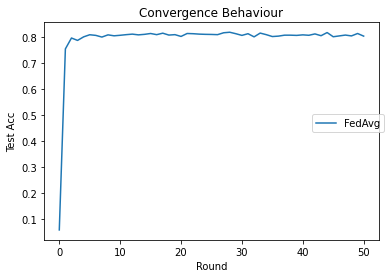

In [72]:
plot_convergence_behaviour(test_accs)

In [73]:
ultimate_aggr_model_y_preds = y_preds[-1]

In [74]:
aggr_model_precision_recall_fscore = precision_recall_fscore(y_test, ultimate_aggr_model_y_preds)

In [75]:
get_utility_measure_on_distributions(aggr_model_precision_recall_fscore, avg_local_model_precision_recall_fscore)

Distribution      Precision       Recall       F1-score      
                      Aggr. Local  Aggr. Local    Aggr. Local
iid-quantity-skew      0.62  0.57   0.72  0.63     0.65  0.59

# Label Distribution Skew: Distribution-based label imbalance

Each client is allocated a proportion of the samples of each label according to a Dirichlet distribution. Dirichlet distribution [is an appropriate
choice](https://arxiv.org/pdf/2102.02079.pdf) to simulate imbalanced data distributions in the real-world. Specifically, we sample $p_k ∼ Dir_N(β)$ and allocate a $p_{k,j}$ proportion of the instances of class $k$ to client $j$. This partitioning strategy has been used to simulate real world data distributions in many recent FL studies, see [here](https://www.ijcai.org/proceedings/2021/0205.pdf), [here](https://proceedings.neurips.cc/paper/2020/file/18df51b97ccd68128e994804f3eccc87-Paper.pdf), [here](https://arxiv.org/pdf/2002.06440.pdf) and [here](https://proceedings.neurips.cc/paper/2020/file/564127c03caab942e503ee6f810f54fd-Paper.pdf).

In [76]:
# Overrides to global experiment config
DATA_PARTITIONING_STRATEGY = "noniid-distribution-based-label-imbalance"

In [77]:
# Split train set into NUMBER_OF_CLIENTS partitions.
partitioned_train_set = get_partitions(X_train, y_train.to_numpy())

In [78]:
get_label_freqs(partitioned_train_set)

,y_train,client0,client1,client2,client3,client4,client5,client6,client7,client8,client9,client10,client11,client12,client13,client14,client15,client16,client17,client18,client19
0,1287,46,100,80,34,98,55,45,50,103,70,55,83,56,58,98,51,51,42,52,60
1,17270,580,452,782,996,813,642,948,654,1783,1074,1168,951,955,767,702,479,789,757,792,1186
2,3747,142,272,247,165,304,196,249,317,0,0,0,261,238,248,214,158,211,230,294,1


In [79]:
get_label_freqs(partitioned_train_set, relative=True)

,y_train,client0,client1,client2,client3,client4,client5,client6,client7,client8,client9,client10,client11,client12,client13,client14,client15,client16,client17,client18,client19
0,0.057703,0.059896,0.121359,0.072137,0.028452,0.080658,0.061590,0.036232,0.048972,0.054613,0.061189,0.044971,0.064093,0.044836,0.054054,0.096647,0.074128,0.048525,0.040816,0.045694,0.048115
1,0.774301,0.755208,0.548544,0.705140,0.833473,0.669136,0.718925,0.763285,0.640548,0.945387,0.938811,0.955029,0.734363,0.764612,0.714818,0.692308,0.696221,0.750714,0.735666,0.695958,0.951083
2,0.167997,0.184896,0.330097,0.222723,0.138075,0.250206,0.219485,0.200483,0.310480,0.000000,0.000000,0.000000,0.201544,0.190552,0.231128,0.211045,0.229651,0.200761,0.223518,0.258348,0.000802


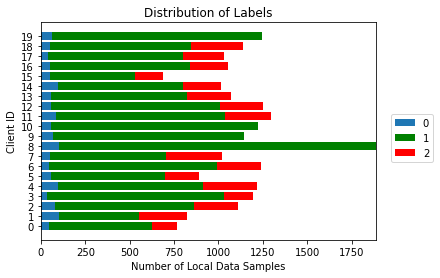

In [80]:
plot_distribution_of_labels(partitioned_train_set)

In [81]:
# Evaluate local models trained on local data
local_models_y_preds = evaluate_local_models(partitioned_train_set)

In [82]:
precision_recall_fscores_of_local_models = get_precision_recall_fscores_of_local_models(y_test, local_models_y_preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

There is no way that a local models can learn labels that they haven't seen. Therefore, the classification scores for the labels missing in the local training set are zeroed out. This pulls down the average scores. Ideally, in ML the train set and test set are sampled from the same underlying distribution. In order to compare utlity of local models with that of the aggregate model, we can't make this assumption.

In [83]:
avg_local_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_models)

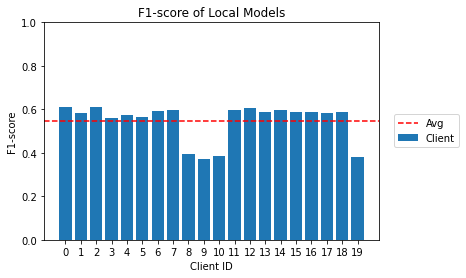

In [84]:
plot_performance_of_local_models(precision_recall_fscores_of_local_models, avg_local_model_precision_recall_fscore)

In [85]:
print_measures_of_dispersion(precision_recall_fscores_of_local_models)

Variance of F1-score across local models: 0.007066917513985985
Standard Deviation of F1-score across local models: 0.08406496008436562


In [86]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set)

INFO flower 2022-02-12 23:12:11,321 | app.py:80 | Flower server running (insecure, 50 rounds)
INFO flower 2022-02-12 23:12:11,324 | server.py:118 | Initializing global parameters
INFO flower 2022-02-12 23:12:11,326 | server.py:304 | Requesting initial parameters from one random client


initializing Client0 with pid 12258


DEBUG flower 2022-02-12 23:12:13,348 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:12:13,350 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:12:13,351 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:12:13,357 | server.py:307 | Received initial parameters from one random client
INFO flower 2022-02-12 23:12:13,360 | server.py:120 | Evaluating initial parameters


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.06      1.00      0.11       143
           1       0.00      0.00      0.00      1920
           2       0.00      0.00      0.00       416

    accuracy                           0.06      2479
   macro avg       0.02      0.33      0.04      2479
weighted avg       0.00      0.06      0.01      2479

Calculating probability estimates
Probability estimates: [[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 ...
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:13,502 | server.py:127 | initial parameters (loss, other metrics): 1.0986122886681096, {'accuracy': 0.057684550221863654}
INFO flower 2022-02-12 23:12:13,510 | server.py:133 | FL starting


initializing Client1 with pid 12325


DEBUG flower 2022-02-12 23:12:14,363 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:12:14,365 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:12:14,366 | connection.py:36 | ChannelConnectivity.READY


initializing Client2 with pid 12347


DEBUG flower 2022-02-12 23:12:15,387 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:12:15,389 | connection.py:36 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-02-12 23:12:15,391 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:12:15,392 | app.py:61 | Opened (insecure) gRPC connection


initializing Client3 with pid 12369


DEBUG flower 2022-02-12 23:12:16,409 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:12:16,411 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:12:16,411 | app.py:61 | Opened (insecure) gRPC connection


initializing Client4 with pid 12389


DEBUG flower 2022-02-12 23:12:17,428 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:12:17,431 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:12:17,431 | app.py:61 | Opened (insecure) gRPC connection


initializing Client5 with pid 12409


DEBUG flower 2022-02-12 23:12:18,443 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:12:18,445 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:12:18,446 | connection.py:36 | ChannelConnectivity.READY


initializing Client6 with pid 12429


DEBUG flower 2022-02-12 23:12:19,460 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:12:19,462 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:12:19,462 | connection.py:36 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-02-12 23:12:19,465 | connection.py:36 | ChannelConnectivity.READY


initializing Client7 with pid 12453


DEBUG flower 2022-02-12 23:12:20,485 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:12:20,487 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:12:20,488 | connection.py:36 | ChannelConnectivity.READY


initializing Client8 with pid 12473


DEBUG flower 2022-02-12 23:12:21,508 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:12:21,511 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:12:21,511 | app.py:61 | Opened (insecure) gRPC connection


initializing Client9 with pid 12493


DEBUG flower 2022-02-12 23:12:22,530 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:12:22,533 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:12:22,534 | app.py:61 | Opened (insecure) gRPC connection


initializing Client10 with pid 12513


DEBUG flower 2022-02-12 23:12:23,554 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:12:23,557 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:12:23,557 | connection.py:36 | ChannelConnectivity.READY


initializing Client11 with pid 12533


DEBUG flower 2022-02-12 23:12:24,569 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:12:24,571 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:12:24,573 | connection.py:36 | ChannelConnectivity.READY


initializing Client12 with pid 12554


DEBUG flower 2022-02-12 23:12:25,587 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:12:25,590 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:12:25,591 | connection.py:36 | ChannelConnectivity.READY


initializing Client13 with pid 12574


DEBUG flower 2022-02-12 23:12:26,614 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:12:26,617 | connection.py:36 | ChannelConnectivity.CONNECTING
INFO flower 2022-02-12 23:12:26,618 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:12:26,619 | connection.py:36 | ChannelConnectivity.READY


initializing Client14 with pid 12596


DEBUG flower 2022-02-12 23:12:27,629 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:12:27,631 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:12:27,631 | connection.py:36 | ChannelConnectivity.READY


initializing Client15 with pid 12616


DEBUG flower 2022-02-12 23:12:28,644 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:12:28,645 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:12:28,646 | connection.py:36 | ChannelConnectivity.READY


initializing Client16 with pid 12636


DEBUG flower 2022-02-12 23:12:29,661 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:12:29,663 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:12:29,665 | connection.py:36 | ChannelConnectivity.READY


initializing Client17 with pid 12658


DEBUG flower 2022-02-12 23:12:30,679 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:12:30,681 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:12:30,682 | app.py:61 | Opened (insecure) gRPC connection


initializing Client18 with pid 12678


DEBUG flower 2022-02-12 23:12:31,698 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:12:31,700 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:12:31,701 | connection.py:36 | ChannelConnectivity.READY


initializing Client19 with pid 12698


DEBUG flower 2022-02-12 23:12:32,716 | connection.py:36 | ChannelConnectivity.IDLE
DEBUG flower 2022-02-12 23:12:32,717 | connection.py:36 | ChannelConnectivity.READY
DEBUG flower 2022-02-12 23:12:32,718 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)
INFO flower 2022-02-12 23:12:32,718 | app.py:61 | Opened (insecure) gRPC connection


Client2 with pid 12347 is sampled in rnd 1
Client8 with pid 12473 is sampled in rnd 1
Client15 with pid 12616 is sampled in rnd 1
Client13 with pid 12574 is sampled in rnd 1
Client18 with pid 12678 is sampled in rnd 1
Client10 with pid 12513 is sampled in rnd 1
Client12 with pid 12554 is sampled in rnd 1
Client7 with pid 12453 is sampled in rnd 1
Client6 with pid 12429 is sampled in rnd 1
Client1 with pid 12325 is sampled in rnd 1
Client3 with pid 12369 is sampled in rnd 1
Client14 with pid 12596 is sampled in rnd 1
Client16 with pid 12636 is sampled in rnd 1
Client0 with pid 12258 is sampled in rnd 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
Training finished for round 1
T

DEBUG flower 2022-02-12 23:12:33,835 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.29      0.48      0.36       143
           1       0.92      0.76      0.83      1920
           2       0.50      0.78      0.61       416

    accuracy                           0.75      2479
   macro avg       0.57      0.68      0.60      2479
weighted avg       0.81      0.75      0.77      2479

Calculating probability estimates
Probability estimates: [[0.31358809 0.57606902 0.11034289]
 [0.00504904 0.00615668 0.98879429]
 [0.13704259 0.6899781  0.17297931]
 ...
 [0.09195509 0.75483863 0.15320629]
 [0.16420558 0.61851635 0.21727807]
 [0.09557573 0.76945292 0.13497135]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:33,975 | server.py:154 | fit progress: (1, 0.670926458091591, {'accuracy': 0.7503025413473174}, 20.45946495399994)
INFO flower 2022-02-12 23:12:33,979 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:33,987 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 12554 is sampled in rnd 2
Client13 with pid 12574 is sampled in rnd 2
Client0 with pid 12258 is sampled in rnd 2
Client8 with pid 12473 is sampled in rnd 2
Client14 with pid 12596 is sampled in rnd 2
Client11 with pid 12533 is sampled in rnd 2
Client19 with pid 12698 is sampled in rnd 2
Client3 with pid 12369 is sampled in rnd 2
Client9 with pid 12493 is sampled in rnd 2
Client1 with pid 12325 is sampled in rnd 2
Client5 with pid 12409 is sampled in rnd 2
Client17 with pid 12658 is sampled in rnd 2
Client15 with pid 12616 is sampled in rnd 2
Client7 with pid 12453 is sampled in rnd 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
Training finished for round 2
T

DEBUG flower 2022-02-12 23:12:35,222 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.45      0.37       143
           1       0.86      0.91      0.89      1920
           2       0.74      0.45      0.56       416

    accuracy                           0.81      2479
   macro avg       0.64      0.61      0.61      2479
weighted avg       0.81      0.81      0.80      2479

Calculating probability estimates
Probability estimates: [[0.16782144 0.76528029 0.06689827]
 [0.01318255 0.02262087 0.96419657]
 [0.1847327  0.70496744 0.11029986]
 ...
 [0.09746542 0.81746888 0.0850657 ]
 [0.19051236 0.65402076 0.15546688]
 [0.09492515 0.82967324 0.07540161]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:35,380 | server.py:154 | fit progress: (2, 0.5593567512108506, {'accuracy': 0.8059701492537313}, 21.86458096399997)
INFO flower 2022-02-12 23:12:35,385 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:35,391 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 12258 is sampled in rnd 3
Client17 with pid 12658 is sampled in rnd 3
Client6 with pid 12429 is sampled in rnd 3
Client12 with pid 12554 is sampled in rnd 3
Client13 with pid 12574 is sampled in rnd 3
Client8 with pid 12473 is sampled in rnd 3
Client10 with pid 12513 is sampled in rnd 3
Client7 with pid 12453 is sampled in rnd 3
Client11 with pid 12533 is sampled in rnd 3
Client3 with pid 12369 is sampled in rnd 3
Client18 with pid 12678 is sampled in rnd 3
Client19 with pid 12698 is sampled in rnd 3
Client14 with pid 12596 is sampled in rnd 3
Client2 with pid 12347 is sampled in rnd 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3
Training finished for round 3


DEBUG flower 2022-02-12 23:12:36,642 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.48      0.39       143
           1       0.90      0.88      0.89      1920
           2       0.68      0.64      0.66       416

    accuracy                           0.81      2479
   macro avg       0.63      0.67      0.64      2479
weighted avg       0.83      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.13100517 0.78940958 0.07958525]
 [0.00716121 0.01433959 0.9784992 ]
 [0.15921448 0.73334265 0.10744287]
 ...
 [0.09438516 0.82158332 0.08403152]
 [0.18344826 0.66324279 0.15330895]
 [0.08403742 0.84258366 0.07337893]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:36,798 | server.py:154 | fit progress: (3, 0.5593342113550381, {'accuracy': 0.8128277531262605}, 23.28258704299992)
INFO flower 2022-02-12 23:12:36,808 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:36,814 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 12453 is sampled in rnd 4
Client19 with pid 12698 is sampled in rnd 4
Client14 with pid 12596 is sampled in rnd 4
Client9 with pid 12493 is sampled in rnd 4
Client6 with pid 12429 is sampled in rnd 4
Client0 with pid 12258 is sampled in rnd 4
Client13 with pid 12574 is sampled in rnd 4
Client8 with pid 12473 is sampled in rnd 4
Client10 with pid 12513 is sampled in rnd 4
Client2 with pid 12347 is sampled in rnd 4
Client1 with pid 12325 is sampled in rnd 4
Client4 with pid 12389 is sampled in rnd 4
Client11 with pid 12533 is sampled in rnd 4
Client5 with pid 12409 is sampled in rnd 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Training finished for round 4
Tra

DEBUG flower 2022-02-12 23:12:38,027 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.31      0.50      0.38       143
           1       0.88      0.89      0.89      1920
           2       0.75      0.56      0.64       416

    accuracy                           0.81      2479
   macro avg       0.65      0.65      0.63      2479
weighted avg       0.83      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.1617323  0.72013123 0.11813647]
 [0.01621339 0.03315396 0.95063265]
 [0.17182797 0.71778674 0.11038528]
 ...
 [0.08715513 0.82319042 0.08965445]
 [0.17749204 0.66141789 0.16109007]
 [0.07594582 0.81738231 0.10667187]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:38,153 | server.py:154 | fit progress: (4, 0.5866987857970308, {'accuracy': 0.8116175877369908}, 24.63758605299995)
INFO flower 2022-02-12 23:12:38,160 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:38,166 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 12513 is sampled in rnd 5
Client18 with pid 12678 is sampled in rnd 5
Client13 with pid 12574 is sampled in rnd 5
Client6 with pid 12429 is sampled in rnd 5
Client14 with pid 12596 is sampled in rnd 5
Client4 with pid 12389 is sampled in rnd 5
Client9 with pid 12493 is sampled in rnd 5
Client7 with pid 12453 is sampled in rnd 5
Client16 with pid 12636 is sampled in rnd 5
Client8 with pid 12473 is sampled in rnd 5
Client15 with pid 12616 is sampled in rnd 5
Client0 with pid 12258 is sampled in rnd 5
Client11 with pid 12533 is sampled in rnd 5
Client1 with pid 12325 is sampled in rnd 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
Training finished for round 5
T

DEBUG flower 2022-02-12 23:12:39,368 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.31      0.47      0.37       143
           1       0.94      0.79      0.86      1920
           2       0.55      0.84      0.66       416

    accuracy                           0.78      2479
   macro avg       0.60      0.70      0.63      2479
weighted avg       0.84      0.78      0.80      2479

Calculating probability estimates
Probability estimates: [[0.18698436 0.65431949 0.15869615]
 [0.00748614 0.01557526 0.9769386 ]
 [0.16122789 0.68096088 0.15781122]
 ...
 [0.09691855 0.75686449 0.14621697]
 [0.16582649 0.58491771 0.2492558 ]
 [0.07885088 0.74907823 0.17207088]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:39,497 | server.py:154 | fit progress: (5, 0.630831864256289, {'accuracy': 0.781766841468334}, 25.98165657000004)
INFO flower 2022-02-12 23:12:39,499 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:39,504 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 12554 is sampled in rnd 6
Client5 with pid 12409 is sampled in rnd 6
Client13 with pid 12574 is sampled in rnd 6
Client11 with pid 12533 is sampled in rnd 6
Client16 with pid 12636 is sampled in rnd 6
Client1 with pid 12325 is sampled in rnd 6
Client7 with pid 12453 is sampled in rnd 6
Client10 with pid 12513 is sampled in rnd 6
Client8 with pid 12473 is sampled in rnd 6
Client14 with pid 12596 is sampled in rnd 6
Client2 with pid 12347 is sampled in rnd 6
Client6 with pid 12429 is sampled in rnd 6
Client15 with pid 12616 is sampled in rnd 6
Client9 with pid 12493 is sampled in rnd 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
Training finished for round 6
T

DEBUG flower 2022-02-12 23:12:40,684 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.39      0.36       143
           1       0.94      0.81      0.87      1920
           2       0.55      0.85      0.67       416

    accuracy                           0.80      2479
   macro avg       0.61      0.69      0.63      2479
weighted avg       0.84      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[0.13978913 0.64472334 0.21548752]
 [0.007132   0.02140309 0.97146492]
 [0.16421132 0.66548308 0.1703056 ]
 ...
 [0.10005027 0.76141934 0.13853039]
 [0.15706838 0.61107125 0.23186036]
 [0.0626529  0.78357416 0.15377293]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:40,807 | server.py:154 | fit progress: (6, 0.6012612714850514, {'accuracy': 0.7958854376764825}, 27.29158376500004)
INFO flower 2022-02-12 23:12:40,810 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:40,814 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 12616 is sampled in rnd 7
Client0 with pid 12258 is sampled in rnd 7
Client19 with pid 12698 is sampled in rnd 7
Client13 with pid 12574 is sampled in rnd 7
Client1 with pid 12325 is sampled in rnd 7
Client9 with pid 12493 is sampled in rnd 7
Client11 with pid 12533 is sampled in rnd 7
Client17 with pid 12658 is sampled in rnd 7
Client12 with pid 12554 is sampled in rnd 7
Client14 with pid 12596 is sampled in rnd 7
Client6 with pid 12429 is sampled in rnd 7
Client2 with pid 12347 is sampled in rnd 7
Client8 with pid 12473 is sampled in rnd 7
Client4 with pid 12389 is sampled in rnd 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
Training finished for round 7
T

DEBUG flower 2022-02-12 23:12:42,151 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.48      0.38       143
           1       0.90      0.87      0.89      1920
           2       0.67      0.67      0.67       416

    accuracy                           0.81      2479
   macro avg       0.63      0.67      0.65      2479
weighted avg       0.83      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.14107698 0.72721637 0.13170666]
 [0.00691521 0.01493532 0.97814947]
 [0.13592898 0.77381251 0.09025851]
 ...
 [0.08184916 0.83504602 0.08310482]
 [0.15680778 0.69106948 0.15212274]
 [0.07002198 0.8395914  0.09038662]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:42,290 | server.py:154 | fit progress: (7, 0.5551090918544254, {'accuracy': 0.8136345300524405}, 28.774459295000042)
INFO flower 2022-02-12 23:12:42,294 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:42,298 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 12453 is sampled in rnd 8
Client6 with pid 12429 is sampled in rnd 8
Client19 with pid 12698 is sampled in rnd 8
Client12 with pid 12554 is sampled in rnd 8
Client0 with pid 12258 is sampled in rnd 8
Client5 with pid 12409 is sampled in rnd 8
Client8 with pid 12473 is sampled in rnd 8
Client9 with pid 12493 is sampled in rnd 8
Client13 with pid 12574 is sampled in rnd 8
Client16 with pid 12636 is sampled in rnd 8
Client4 with pid 12389 is sampled in rnd 8
Client14 with pid 12596 is sampled in rnd 8
Client18 with pid 12678 is sampled in rnd 8
Client3 with pid 12369 is sampled in rnd 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Training finished for round 8
Tr

DEBUG flower 2022-02-12 23:12:43,508 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.48      0.39       143
           1       0.87      0.91      0.89      1920
           2       0.75      0.51      0.61       416

    accuracy                           0.82      2479
   macro avg       0.65      0.63      0.63      2479
weighted avg       0.82      0.82      0.81      2479

Calculating probability estimates
Probability estimates: [[0.09483897 0.81902512 0.08613591]
 [0.01183386 0.0355469  0.95261924]
 [0.15784447 0.75138723 0.0907683 ]
 ...
 [0.09652898 0.82732259 0.07614843]
 [0.15764531 0.68438323 0.15797146]
 [0.06415444 0.86025011 0.07559544]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:43,651 | server.py:154 | fit progress: (8, 0.5379565396548045, {'accuracy': 0.8156514723678903}, 30.135586214000114)
INFO flower 2022-02-12 23:12:43,653 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:43,657 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 12636 is sampled in rnd 9
Client4 with pid 12389 is sampled in rnd 9
Client19 with pid 12698 is sampled in rnd 9
Client6 with pid 12429 is sampled in rnd 9
Client13 with pid 12574 is sampled in rnd 9
Client0 with pid 12258 is sampled in rnd 9
Client7 with pid 12453 is sampled in rnd 9
Client5 with pid 12409 is sampled in rnd 9
Client8 with pid 12473 is sampled in rnd 9
Client3 with pid 12369 is sampled in rnd 9
Client10 with pid 12513 is sampled in rnd 9
Client9 with pid 12493 is sampled in rnd 9
Client17 with pid 12658 is sampled in rnd 9
Client11 with pid 12533 is sampled in rnd 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Training finished for round 9
Tr

DEBUG flower 2022-02-12 23:12:44,933 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.47      0.39       143
           1       0.84      0.93      0.88      1920
           2       0.79      0.31      0.45       416

    accuracy                           0.80      2479
   macro avg       0.66      0.57      0.57      2479
weighted avg       0.80      0.80      0.78      2479

Calculating probability estimates
Probability estimates: [[0.10994547 0.8393817  0.05067283]
 [0.01538069 0.03631417 0.94830514]
 [0.17144071 0.76248735 0.06607194]
 ...
 [0.08096466 0.86644332 0.05259203]
 [0.15708154 0.73407849 0.10883997]
 [0.07586027 0.86818813 0.0559516 ]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:45,085 | server.py:154 | fit progress: (9, 0.5534964327988472, {'accuracy': 0.7970956030657523}, 31.56925043000001)
INFO flower 2022-02-12 23:12:45,096 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:45,102 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 12533 is sampled in rnd 10
Client13 with pid 12574 is sampled in rnd 10
Client19 with pid 12698 is sampled in rnd 10
Client0 with pid 12258 is sampled in rnd 10
Client10 with pid 12513 is sampled in rnd 10
Training finished for round 10
Client7 with pid 12453 is sampled in rnd 10
Client9 with pid 12493 is sampled in rnd 10
Client3 with pid 12369 is sampled in rnd 10
Client16 with pid 12636 is sampled in rnd 10
Client15 with pid 12616 is sampled in rnd 10
Client2 with pid 12347 is sampled in rnd 10
Client8 with pid 12473 is sampled in rnd 10
Client18 with pid 12678 is sampled in rnd 10
Client6 with pid 12429 is sampled in rnd 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Training finished for round 10
Train

DEBUG flower 2022-02-12 23:12:46,329 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.47      0.39       143
           1       0.83      0.93      0.88      1920
           2       0.83      0.25      0.39       416

    accuracy                           0.79      2479
   macro avg       0.66      0.55      0.55      2479
weighted avg       0.80      0.79      0.77      2479

Calculating probability estimates
Probability estimates: [[0.11331469 0.86325928 0.02342602]
 [0.01643123 0.04629277 0.937276  ]
 [0.18773222 0.73141374 0.08085404]
 ...
 [0.10635793 0.84165439 0.05198768]
 [0.19225133 0.68698206 0.12076661]
 [0.06836871 0.87822758 0.05340371]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:46,464 | server.py:154 | fit progress: (10, 0.5677207682263766, {'accuracy': 0.7910447761194029}, 32.94826646999991)
INFO flower 2022-02-12 23:12:46,472 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:46,475 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 12347 is sampled in rnd 11
Client17 with pid 12658 is sampled in rnd 11
Client1 with pid 12325 is sampled in rnd 11
Client8 with pid 12473 is sampled in rnd 11
Client16 with pid 12636 is sampled in rnd 11
Client13 with pid 12574 is sampled in rnd 11
Client19 with pid 12698 is sampled in rnd 11
Client0 with pid 12258 is sampled in rnd 11
Client12 with pid 12554 is sampled in rnd 11
Client7 with pid 12453 is sampled in rnd 11
Client4 with pid 12389 is sampled in rnd 11
Client3 with pid 12369 is sampled in rnd 11
Client9 with pid 12493 is sampled in rnd 11
Client10 with pid 12513 is sampled in rnd 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Training finished for round 11
Traini

DEBUG flower 2022-02-12 23:12:47,754 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.45      0.38       143
           1       0.88      0.90      0.89      1920
           2       0.72      0.55      0.62       416

    accuracy                           0.82      2479
   macro avg       0.64      0.63      0.63      2479
weighted avg       0.82      0.82      0.82      2479

Calculating probability estimates
Probability estimates: [[0.11037563 0.75851099 0.13111338]
 [0.02680108 0.03209747 0.94110145]
 [0.17812587 0.72364156 0.09823257]
 ...
 [0.09020209 0.82484295 0.08495496]
 [0.19270585 0.66618119 0.14111296]
 [0.09649811 0.80254366 0.10095823]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:47,904 | server.py:154 | fit progress: (11, 0.5673729115825441, {'accuracy': 0.8156514723678903}, 34.38803209799994)
INFO flower 2022-02-12 23:12:47,910 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:47,915 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 12698 is sampled in rnd 12
Client5 with pid 12409 is sampled in rnd 12
Client9 with pid 12493 is sampled in rnd 12
Client14 with pid 12596 is sampled in rnd 12
Client15 with pid 12616 is sampled in rnd 12
Client2 with pid 12347 is sampled in rnd 12
Client11 with pid 12533 is sampled in rnd 12
Client4 with pid 12389 is sampled in rnd 12
Client8 with pid 12473 is sampled in rnd 12
Client12 with pid 12554 is sampled in rnd 12
Client13 with pid 12574 is sampled in rnd 12
Client16 with pid 12636 is sampled in rnd 12
Client7 with pid 12453 is sampled in rnd 12
Client18 with pid 12678 is sampled in rnd 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Training finished for round 12
Trai

DEBUG flower 2022-02-12 23:12:49,224 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.31      0.48      0.38       143
           1       0.87      0.91      0.89      1920
           2       0.78      0.47      0.58       416

    accuracy                           0.81      2479
   macro avg       0.65      0.62      0.62      2479
weighted avg       0.82      0.81      0.81      2479

Calculating probability estimates
Probability estimates: [[0.10999881 0.82665736 0.06334382]
 [0.01193085 0.023503   0.96456615]
 [0.14290057 0.78028609 0.07681334]
 ...
 [0.08096792 0.87111607 0.04791601]
 [0.16804065 0.72430752 0.10765183]
 [0.05374597 0.89081957 0.05543446]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:49,363 | server.py:154 | fit progress: (12, 0.5327658688212719, {'accuracy': 0.8087938684953611}, 35.84761589200002)
INFO flower 2022-02-12 23:12:49,367 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:49,371 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client10 with pid 12513 is sampled in rnd 13
Client18 with pid 12678 is sampled in rnd 13
Client15 with pid 12616 is sampled in rnd 13
Training finished for round 13
Client3 with pid 12369 is sampled in rnd 13
Client6 with pid 12429 is sampled in rnd 13
Client4 with pid 12389 is sampled in rnd 13
Client16 with pid 12636 is sampled in rnd 13
Client5 with pid 12409 is sampled in rnd 13
Client13 with pid 12574 is sampled in rnd 13
Client0 with pid 12258 is sampled in rnd 13
Client14 with pid 12596 is sampled in rnd 13
Client1 with pid 12325 is sampled in rnd 13
Client9 with pid 12493 is sampled in rnd 13
Client12 with pid 12554 is sampled in rnd 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Training finished for round 13
Train

DEBUG flower 2022-02-12 23:12:50,604 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.43      0.40       143
           1       0.94      0.82      0.87      1920
           2       0.55      0.84      0.67       416

    accuracy                           0.80      2479
   macro avg       0.62      0.70      0.64      2479
weighted avg       0.84      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[0.10365531 0.77714354 0.11920114]
 [0.00734536 0.01259614 0.9800585 ]
 [0.11684623 0.74559447 0.1375593 ]
 ...
 [0.06796958 0.81690589 0.11512454]
 [0.09905209 0.68926589 0.21168202]
 [0.0570982  0.83373057 0.10917122]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:50,728 | server.py:154 | fit progress: (13, 0.5808606468166481, {'accuracy': 0.7979023799919323}, 37.21172916199998)
INFO flower 2022-02-12 23:12:50,729 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:50,732 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client16 with pid 12636 is sampled in rnd 14
Client13 with pid 12574 is sampled in rnd 14
Client7 with pid 12453 is sampled in rnd 14
Client19 with pid 12698 is sampled in rnd 14
Client18 with pid 12678 is sampled in rnd 14
Client2 with pid 12347 is sampled in rnd 14
Client6 with pid 12429 is sampled in rnd 14
Client0 with pid 12258 is sampled in rnd 14
Client14 with pid 12596 is sampled in rnd 14
Client12 with pid 12554 is sampled in rnd 14
Client15 with pid 12616 is sampled in rnd 14
Client8 with pid 12473 is sampled in rnd 14
Client17 with pid 12658 is sampled in rnd 14
Client4 with pid 12389 is sampled in rnd 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Training finished for round 14
Trai

DEBUG flower 2022-02-12 23:12:52,044 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.44      0.38       143
           1       0.91      0.87      0.89      1920
           2       0.67      0.70      0.69       416

    accuracy                           0.82      2479
   macro avg       0.63      0.67      0.65      2479
weighted avg       0.83      0.82      0.83      2479

Calculating probability estimates
Probability estimates: [[0.07389736 0.78135835 0.14474428]
 [0.00733995 0.01751287 0.97514718]
 [0.12598163 0.79369033 0.08032804]
 ...
 [0.07880655 0.84854364 0.0726498 ]
 [0.14731793 0.70805731 0.14462475]
 [0.04930173 0.86759445 0.08310381]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:52,186 | server.py:154 | fit progress: (14, 0.5275068869920987, {'accuracy': 0.8196853569987899}, 38.670540830999926)
INFO flower 2022-02-12 23:12:52,189 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:52,193 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 12453 is sampled in rnd 15
Client16 with pid 12636 is sampled in rnd 15
Client14 with pid 12596 is sampled in rnd 15
Client0 with pid 12258 is sampled in rnd 15
Client6 with pid 12429 is sampled in rnd 15
Client19 with pid 12698 is sampled in rnd 15
Client10 with pid 12513 is sampled in rnd 15
Client9 with pid 12493 is sampled in rnd 15
Client5 with pid 12409 is sampled in rnd 15
Client13 with pid 12574 is sampled in rnd 15
Client17 with pid 12658 is sampled in rnd 15
Client15 with pid 12616 is sampled in rnd 15
Client4 with pid 12389 is sampled in rnd 15
Client1 with pid 12325 is sampled in rnd 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Training finished for round 15
Train

DEBUG flower 2022-02-12 23:12:53,383 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.31      0.50      0.38       143
           1       0.90      0.88      0.89      1920
           2       0.71      0.63      0.67       416

    accuracy                           0.82      2479
   macro avg       0.64      0.67      0.65      2479
weighted avg       0.83      0.82      0.82      2479

Calculating probability estimates
Probability estimates: [[0.08332011 0.79148589 0.125194  ]
 [0.01011523 0.01871775 0.97116701]
 [0.14311163 0.78486518 0.07202319]
 ...
 [0.07206458 0.85835136 0.06958406]
 [0.14354574 0.7189085  0.13754576]
 [0.05952669 0.84529463 0.09517868]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:53,524 | server.py:154 | fit progress: (15, 0.555080653477336, {'accuracy': 0.8152480839048003}, 40.008057476999966)
INFO flower 2022-02-12 23:12:53,533 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:53,534 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 12429 is sampled in rnd 16
Client1 with pid 12325 is sampled in rnd 16
Client9 with pid 12493 is sampled in rnd 16
Client2 with pid 12347 is sampled in rnd 16
Client16 with pid 12636 is sampled in rnd 16
Client4 with pid 12389 is sampled in rnd 16
Client11 with pid 12533 is sampled in rnd 16
Client14 with pid 12596 is sampled in rnd 16
Client15 with pid 12616 is sampled in rnd 16
Client19 with pid 12698 is sampled in rnd 16
Client17 with pid 12658 is sampled in rnd 16
Client13 with pid 12574 is sampled in rnd 16
Client12 with pid 12554 is sampled in rnd 16
Client0 with pid 12258 is sampled in rnd 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Training finished for round 16
Trai

DEBUG flower 2022-02-12 23:12:54,820 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.48      0.39       143
           1       0.89      0.90      0.89      1920
           2       0.76      0.59      0.67       416

    accuracy                           0.83      2479
   macro avg       0.66      0.66      0.65      2479
weighted avg       0.83      0.83      0.83      2479

Calculating probability estimates
Probability estimates: [[0.12296915 0.82600268 0.05102817]
 [0.00448525 0.01450069 0.98101406]
 [0.11162435 0.81283449 0.07554115]
 ...
 [0.06886147 0.88285037 0.04828815]
 [0.12652763 0.74267075 0.13080162]
 [0.03954635 0.91277241 0.04768123]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:54,988 | server.py:154 | fit progress: (16, 0.5086528116177879, {'accuracy': 0.8257361839451391}, 41.47257870499993)
INFO flower 2022-02-12 23:12:55,001 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:55,009 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 12325 is sampled in rnd 17
Client17 with pid 12658 is sampled in rnd 17
Client6 with pid 12429 is sampled in rnd 17
Client14 with pid 12596 is sampled in rnd 17
Client5 with pid 12409 is sampled in rnd 17
Client13 with pid 12574 is sampled in rnd 17
Client16 with pid 12636 is sampled in rnd 17
Client12 with pid 12554 is sampled in rnd 17
Client11 with pid 12533 is sampled in rnd 17
Client9 with pid 12493 is sampled in rnd 17
Client8 with pid 12473 is sampled in rnd 17
Client0 with pid 12258 is sampled in rnd 17
Client19 with pid 12698 is sampled in rnd 17
Client18 with pid 12678 is sampled in rnd 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Training finished for round 17
Trai

DEBUG flower 2022-02-12 23:12:56,318 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.31      0.52      0.38       143
           1       0.86      0.91      0.89      1920
           2       0.77      0.38      0.51       416

    accuracy                           0.80      2479
   macro avg       0.65      0.60      0.59      2479
weighted avg       0.82      0.80      0.80      2479

Calculating probability estimates
Probability estimates: [[0.12759708 0.79155971 0.08084321]
 [0.01097265 0.03358243 0.95544492]
 [0.16657277 0.78931703 0.04411019]
 ...
 [0.11221152 0.84296747 0.04482101]
 [0.17526953 0.71937023 0.10536024]
 [0.06871613 0.88133046 0.04995342]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:56,451 | server.py:154 | fit progress: (17, 0.5436045591058782, {'accuracy': 0.8011294876966518}, 42.93526165000003)
INFO flower 2022-02-12 23:12:56,454 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:56,459 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 12533 is sampled in rnd 18
Client3 with pid 12369 is sampled in rnd 18
Client6 with pid 12429 is sampled in rnd 18
Client17 with pid 12658 is sampled in rnd 18
Client7 with pid 12453 is sampled in rnd 18
Client13 with pid 12574 is sampled in rnd 18
Client10 with pid 12513 is sampled in rnd 18
Client1 with pid 12325 is sampled in rnd 18
Client15 with pid 12616 is sampled in rnd 18
Client4 with pid 12389 is sampled in rnd 18
Client8 with pid 12473 is sampled in rnd 18
Client14 with pid 12596 is sampled in rnd 18
Client0 with pid 12258 is sampled in rnd 18
Client2 with pid 12347 is sampled in rnd 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Training finished for round 18
Traini

DEBUG flower 2022-02-12 23:12:57,767 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.42      0.38       143
           1       0.93      0.82      0.87      1920
           2       0.56      0.83      0.67       416

    accuracy                           0.80      2479
   macro avg       0.62      0.69      0.64      2479
weighted avg       0.84      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[0.13014711 0.72863878 0.14121411]
 [0.00487835 0.01116166 0.98395999]
 [0.11177787 0.75112381 0.13709831]
 ...
 [0.05543128 0.83652432 0.10804441]
 [0.12581329 0.69612653 0.17806018]
 [0.06299292 0.82888534 0.10812174]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:57,897 | server.py:154 | fit progress: (18, 0.585488691761513, {'accuracy': 0.800726099233562}, 44.38155964900011)
INFO flower 2022-02-12 23:12:57,899 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:57,902 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 12698 is sampled in rnd 19
Client12 with pid 12554 is sampled in rnd 19
Client9 with pid 12493 is sampled in rnd 19
Client0 with pid 12258 is sampled in rnd 19
Client5 with pid 12409 is sampled in rnd 19
Client3 with pid 12369 is sampled in rnd 19
Client13 with pid 12574 is sampled in rnd 19
Client15 with pid 12616 is sampled in rnd 19
Client17 with pid 12658 is sampled in rnd 19
Client18 with pid 12678 is sampled in rnd 19
Client2 with pid 12347 is sampled in rnd 19
Client6 with pid 12429 is sampled in rnd 19
Client14 with pid 12596 is sampled in rnd 19
Client10 with pid 12513 is sampled in rnd 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Training finished for round 19
Trai

DEBUG flower 2022-02-12 23:12:59,163 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.37      0.43      0.40       143
           1       0.89      0.90      0.90      1920
           2       0.68      0.62      0.65       416

    accuracy                           0.83      2479
   macro avg       0.65      0.65      0.65      2479
weighted avg       0.83      0.83      0.83      2479

Calculating probability estimates
Probability estimates: [[0.08035257 0.80684362 0.11280381]
 [0.00686825 0.01649945 0.97663231]
 [0.1243306  0.80264393 0.07302547]
 ...
 [0.08660023 0.84424249 0.06915728]
 [0.1513434  0.7165752  0.1320814 ]
 [0.06229949 0.87238376 0.06531675]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:12:59,299 | server.py:154 | fit progress: (19, 0.5125720770001294, {'accuracy': 0.8265429608713191}, 45.78347273600002)
INFO flower 2022-02-12 23:12:59,305 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:12:59,311 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 12369 is sampled in rnd 20
Client12 with pid 12554 is sampled in rnd 20
Client17 with pid 12658 is sampled in rnd 20
Client11 with pid 12533 is sampled in rnd 20
Client15 with pid 12616 is sampled in rnd 20
Client18 with pid 12678 is sampled in rnd 20
Client8 with pid 12473 is sampled in rnd 20
Client19 with pid 12698 is sampled in rnd 20
Client1 with pid 12325 is sampled in rnd 20
Client0 with pid 12258 is sampled in rnd 20
Client16 with pid 12636 is sampled in rnd 20
Client2 with pid 12347 is sampled in rnd 20
Client13 with pid 12574 is sampled in rnd 20
Client9 with pid 12493 is sampled in rnd 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Training finished for round 20
Trai

DEBUG flower 2022-02-12 23:13:00,574 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.52      0.40       143
           1       0.88      0.90      0.89      1920
           2       0.76      0.50      0.61       416

    accuracy                           0.81      2479
   macro avg       0.66      0.64      0.63      2479
weighted avg       0.83      0.81      0.81      2479

Calculating probability estimates
Probability estimates: [[0.1304434  0.76879763 0.10075897]
 [0.01202629 0.02249822 0.96547549]
 [0.17290388 0.75117969 0.07591643]
 ...
 [0.10616426 0.82607309 0.06776265]
 [0.19029129 0.66847339 0.14123532]
 [0.07628225 0.85201207 0.07170568]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:00,752 | server.py:154 | fit progress: (20, 0.5426459811217824, {'accuracy': 0.8140379185155304}, 47.23643522399993)
INFO flower 2022-02-12 23:13:00,762 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:00,771 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 12658 is sampled in rnd 21
Client6 with pid 12429 is sampled in rnd 21
Client8 with pid 12473 is sampled in rnd 21
Client14 with pid 12596 is sampled in rnd 21
Client19 with pid 12698 is sampled in rnd 21
Client5 with pid 12409 is sampled in rnd 21
Client10 with pid 12513 is sampled in rnd 21
Client1 with pid 12325 is sampled in rnd 21
Client4 with pid 12389 is sampled in rnd 21
Client13 with pid 12574 is sampled in rnd 21
Client3 with pid 12369 is sampled in rnd 21
Client2 with pid 12347 is sampled in rnd 21
Client7 with pid 12453 is sampled in rnd 21
Client16 with pid 12636 is sampled in rnd 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Training finished for round 21
Traini

DEBUG flower 2022-02-12 23:13:02,053 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.47      0.38       143
           1       0.85      0.92      0.88      1920
           2       0.79      0.36      0.50       416

    accuracy                           0.80      2479
   macro avg       0.65      0.58      0.59      2479
weighted avg       0.81      0.80      0.79      2479

Calculating probability estimates
Probability estimates: [[0.10874674 0.83753291 0.05372036]
 [0.00999328 0.03257664 0.95743008]
 [0.15387351 0.78782341 0.05830308]
 ...
 [0.07498185 0.88132732 0.04369083]
 [0.17346456 0.73425963 0.0922758 ]
 [0.0895644  0.85427511 0.05616049]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:02,189 | server.py:154 | fit progress: (21, 0.5412335466001765, {'accuracy': 0.7991125453812021}, 48.67344593500002)
INFO flower 2022-02-12 23:13:02,195 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:02,201 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 12658 is sampled in rnd 22
Client3 with pid 12369 is sampled in rnd 22
Client10 with pid 12513 is sampled in rnd 22
Client1 with pid 12325 is sampled in rnd 22
Client13 with pid 12574 is sampled in rnd 22
Client16 with pid 12636 is sampled in rnd 22
Client6 with pid 12429 is sampled in rnd 22
Client12 with pid 12554 is sampled in rnd 22
Client2 with pid 12347 is sampled in rnd 22
Client11 with pid 12533 is sampled in rnd 22
Client5 with pid 12409 is sampled in rnd 22
Client14 with pid 12596 is sampled in rnd 22
Client15 with pid 12616 is sampled in rnd 22
Client0 with pid 12258 is sampled in rnd 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Training finished for round 22
Trai

DEBUG flower 2022-02-12 23:13:03,510 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.43      0.38       143
           1       0.93      0.81      0.87      1920
           2       0.55      0.84      0.67       416

    accuracy                           0.80      2479
   macro avg       0.61      0.69      0.64      2479
weighted avg       0.84      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[0.09489684 0.79099386 0.1141093 ]
 [0.00319226 0.00729929 0.98950845]
 [0.13163354 0.75242439 0.11594208]
 ...
 [0.07277722 0.8273246  0.09989818]
 [0.12571026 0.6747143  0.19957544]
 [0.05081195 0.85709255 0.0920955 ]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:03,676 | server.py:154 | fit progress: (22, 0.5648235680999335, {'accuracy': 0.7962888261395724}, 50.16059852000012)
INFO flower 2022-02-12 23:13:03,680 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:03,690 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 12678 is sampled in rnd 23
Client17 with pid 12658 is sampled in rnd 23
Client7 with pid 12453 is sampled in rnd 23
Client2 with pid 12347 is sampled in rnd 23
Client8 with pid 12473 is sampled in rnd 23
Client5 with pid 12409 is sampled in rnd 23
Client4 with pid 12389 is sampled in rnd 23
Client15 with pid 12616 is sampled in rnd 23
Client9 with pid 12493 is sampled in rnd 23
Client1 with pid 12325 is sampled in rnd 23
Client19 with pid 12698 is sampled in rnd 23
Client13 with pid 12574 is sampled in rnd 23
Client6 with pid 12429 is sampled in rnd 23
Client10 with pid 12513 is sampled in rnd 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Training finished for round 23
Traini

DEBUG flower 2022-02-12 23:13:04,940 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.53      0.40       143
           1       0.84      0.92      0.88      1920
           2       0.83      0.25      0.39       416

    accuracy                           0.79      2479
   macro avg       0.66      0.57      0.55      2479
weighted avg       0.81      0.79      0.77      2479

Calculating probability estimates
Probability estimates: [[0.18225294 0.77812968 0.03961738]
 [0.01814324 0.05360738 0.92824938]
 [0.15607996 0.76948101 0.07443903]
 ...
 [0.10711424 0.84045289 0.05243287]
 [0.19231629 0.70270219 0.10498152]
 [0.11188504 0.83187425 0.05624071]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:05,089 | server.py:154 | fit progress: (23, 0.5928373083567222, {'accuracy': 0.7870108914885035}, 51.573233945000084)
INFO flower 2022-02-12 23:13:05,093 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:05,100 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client1 with pid 12325 is sampled in rnd 24
Client9 with pid 12493 is sampled in rnd 24
Client0 with pid 12258 is sampled in rnd 24
Client2 with pid 12347 is sampled in rnd 24
Client6 with pid 12429 is sampled in rnd 24
Client19 with pid 12698 is sampled in rnd 24
Client12 with pid 12554 is sampled in rnd 24
Client3 with pid 12369 is sampled in rnd 24
Client10 with pid 12513 is sampled in rnd 24
Client17 with pid 12658 is sampled in rnd 24
Client16 with pid 12636 is sampled in rnd 24
Client14 with pid 12596 is sampled in rnd 24
Client15 with pid 12616 is sampled in rnd 24
Client11 with pid 12533 is sampled in rnd 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Training finished for round 24
Trai

DEBUG flower 2022-02-12 23:13:06,352 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.31      0.51      0.38       143
           1       0.88      0.89      0.89      1920
           2       0.76      0.56      0.64       416

    accuracy                           0.81      2479
   macro avg       0.65      0.65      0.64      2479
weighted avg       0.83      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.14324144 0.81101184 0.04574671]
 [0.01122909 0.01890311 0.9698678 ]
 [0.143334   0.77495154 0.08171446]
 ...
 [0.08393683 0.85419803 0.06186513]
 [0.14190876 0.72287469 0.13521655]
 [0.05999966 0.88609364 0.05390669]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:06,493 | server.py:154 | fit progress: (24, 0.5438826973519308, {'accuracy': 0.8124243646631706}, 52.97731444500005)
INFO flower 2022-02-12 23:13:06,498 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:06,504 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 12596 is sampled in rnd 25
Client5 with pid 12409 is sampled in rnd 25
Client7 with pid 12453 is sampled in rnd 25
Client6 with pid 12429 is sampled in rnd 25
Client12 with pid 12554 is sampled in rnd 25
Client18 with pid 12678 is sampled in rnd 25
Client3 with pid 12369 is sampled in rnd 25
Client19 with pid 12698 is sampled in rnd 25
Client8 with pid 12473 is sampled in rnd 25
Client4 with pid 12389 is sampled in rnd 25
Client11 with pid 12533 is sampled in rnd 25
Client17 with pid 12658 is sampled in rnd 25
Client10 with pid 12513 is sampled in rnd 25
Client2 with pid 12347 is sampled in rnd 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Training finished for round 25
Train

DEBUG flower 2022-02-12 23:13:07,779 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.46      0.38       143
           1       0.88      0.91      0.89      1920
           2       0.76      0.52      0.62       416

    accuracy                           0.82      2479
   macro avg       0.65      0.63      0.63      2479
weighted avg       0.83      0.82      0.82      2479

Calculating probability estimates
Probability estimates: [[0.12450525 0.7948837  0.08061105]
 [0.00626994 0.02593877 0.9677913 ]
 [0.14550453 0.77315949 0.08133598]
 ...
 [0.08831526 0.8548135  0.05687124]
 [0.16813126 0.7180643  0.11380444]
 [0.07061511 0.86638855 0.06299635]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:07,932 | server.py:154 | fit progress: (25, 0.5308630503076522, {'accuracy': 0.81807180314643}, 54.41577247600003)
INFO flower 2022-02-12 23:13:07,935 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:07,937 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client6 with pid 12429 is sampled in rnd 26
Client3 with pid 12369 is sampled in rnd 26
Client1 with pid 12325 is sampled in rnd 26
Client10 with pid 12513 is sampled in rnd 26
Client0 with pid 12258 is sampled in rnd 26
Client15 with pid 12616 is sampled in rnd 26
Client11 with pid 12533 is sampled in rnd 26
Client4 with pid 12389 is sampled in rnd 26
Client12 with pid 12554 is sampled in rnd 26
Client9 with pid 12493 is sampled in rnd 26
Client7 with pid 12453 is sampled in rnd 26
Client5 with pid 12409 is sampled in rnd 26
Client18 with pid 12678 is sampled in rnd 26
Client2 with pid 12347 is sampled in rnd 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Training finished for round 26
Trainin

DEBUG flower 2022-02-12 23:13:09,171 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.41      0.36       143
           1       0.94      0.81      0.87      1920
           2       0.55      0.85      0.67       416

    accuracy                           0.80      2479
   macro avg       0.61      0.69      0.63      2479
weighted avg       0.84      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[0.10015252 0.7678741  0.13197338]
 [0.00497528 0.00893357 0.98609115]
 [0.10591944 0.75909588 0.13498468]
 ...
 [0.06184415 0.82624156 0.11191429]
 [0.10756412 0.69753088 0.194905  ]
 [0.04443781 0.85100847 0.10455372]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:09,324 | server.py:154 | fit progress: (26, 0.5714168255748491, {'accuracy': 0.7950786607503025}, 55.80771858899993)
INFO flower 2022-02-12 23:13:09,326 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:09,333 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 12554 is sampled in rnd 27
Client10 with pid 12513 is sampled in rnd 27
Client14 with pid 12596 is sampled in rnd 27
Client2 with pid 12347 is sampled in rnd 27
Client1 with pid 12325 is sampled in rnd 27
Client18 with pid 12678 is sampled in rnd 27
Client3 with pid 12369 is sampled in rnd 27
Client4 with pid 12389 is sampled in rnd 27
Client8 with pid 12473 is sampled in rnd 27
Client9 with pid 12493 is sampled in rnd 27
Client7 with pid 12453 is sampled in rnd 27
Client5 with pid 12409 is sampled in rnd 27
Client13 with pid 12574 is sampled in rnd 27
Client15 with pid 12616 is sampled in rnd 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Training finished for round 27
Traini

DEBUG flower 2022-02-12 23:13:10,537 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.43      0.39       143
           1       0.94      0.81      0.87      1920
           2       0.54      0.86      0.67       416

    accuracy                           0.79      2479
   macro avg       0.61      0.70      0.64      2479
weighted avg       0.84      0.79      0.81      2479

Calculating probability estimates
Probability estimates: [[0.13498077 0.68688512 0.17813411]
 [0.01416115 0.02584721 0.95999163]
 [0.13385865 0.69230416 0.17383719]
 ...
 [0.0978888  0.76957194 0.13253926]
 [0.16664321 0.63949977 0.19385702]
 [0.11687164 0.74247182 0.14065654]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:10,674 | server.py:154 | fit progress: (27, 0.6221669970316948, {'accuracy': 0.7930617184348527}, 57.1582164460001)
INFO flower 2022-02-12 23:13:10,679 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:10,683 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 12658 is sampled in rnd 28
Client6 with pid 12429 is sampled in rnd 28
Client7 with pid 12453 is sampled in rnd 28
Client5 with pid 12409 is sampled in rnd 28
Client18 with pid 12678 is sampled in rnd 28
Client9 with pid 12493 is sampled in rnd 28
Client1 with pid 12325 is sampled in rnd 28
Client13 with pid 12574 is sampled in rnd 28
Client4 with pid 12389 is sampled in rnd 28
Client15 with pid 12616 is sampled in rnd 28
Client11 with pid 12533 is sampled in rnd 28
Client14 with pid 12596 is sampled in rnd 28
Client3 with pid 12369 is sampled in rnd 28
Client10 with pid 12513 is sampled in rnd 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Training finished for round 28
Train

DEBUG flower 2022-02-12 23:13:11,905 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.43      0.37       143
           1       0.93      0.81      0.87      1920
           2       0.55      0.81      0.66       416

    accuracy                           0.79      2479
   macro avg       0.60      0.68      0.63      2479
weighted avg       0.83      0.79      0.80      2479

Calculating probability estimates
Probability estimates: [[0.10863696 0.76149788 0.12986516]
 [0.00333252 0.00692014 0.98974734]
 [0.11980956 0.75698297 0.12320747]
 ...
 [0.04831588 0.8415323  0.11015182]
 [0.11293591 0.70521174 0.18185235]
 [0.0551831  0.84327414 0.10154276]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:12,055 | server.py:154 | fit progress: (28, 0.5796779302837174, {'accuracy': 0.790641387656313}, 58.539412297000126)
INFO flower 2022-02-12 23:13:12,058 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:12,064 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 12493 is sampled in rnd 29
Client1 with pid 12325 is sampled in rnd 29
Client10 with pid 12513 is sampled in rnd 29
Client5 with pid 12409 is sampled in rnd 29
Client17 with pid 12658 is sampled in rnd 29
Client13 with pid 12574 is sampled in rnd 29
Client12 with pid 12554 is sampled in rnd 29
Client4 with pid 12389 is sampled in rnd 29
Client19 with pid 12698 is sampled in rnd 29
Client3 with pid 12369 is sampled in rnd 29
Client16 with pid 12636 is sampled in rnd 29
Client18 with pid 12678 is sampled in rnd 29
Client8 with pid 12473 is sampled in rnd 29
Client7 with pid 12453 is sampled in rnd 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Training finished for round 29
Train

DEBUG flower 2022-02-12 23:13:13,324 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.47      0.39       143
           1       0.85      0.93      0.88      1920
           2       0.82      0.33      0.47       416

    accuracy                           0.80      2479
   macro avg       0.66      0.58      0.58      2479
weighted avg       0.81      0.80      0.79      2479

Calculating probability estimates
Probability estimates: [[0.14257518 0.80447421 0.0529506 ]
 [0.0227485  0.04798837 0.92926313]
 [0.16763053 0.75196592 0.08040355]
 ...
 [0.09610452 0.83890754 0.06498795]
 [0.18023099 0.69600772 0.12376129]
 [0.1169337  0.82039273 0.06267358]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:13,476 | server.py:154 | fit progress: (29, 0.5594790127580938, {'accuracy': 0.8015328761597418}, 59.960205820000056)
INFO flower 2022-02-12 23:13:13,492 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:13,501 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client7 with pid 12453 is sampled in rnd 30
Client0 with pid 12258 is sampled in rnd 30
Client12 with pid 12554 is sampled in rnd 30
Client19 with pid 12698 is sampled in rnd 30
Client4 with pid 12389 is sampled in rnd 30
Client2 with pid 12347 is sampled in rnd 30
Client8 with pid 12473 is sampled in rnd 30
Client1 with pid 12325 is sampled in rnd 30
Client11 with pid 12533 is sampled in rnd 30
Client16 with pid 12636 is sampled in rnd 30
Client18 with pid 12678 is sampled in rnd 30
Client9 with pid 12493 is sampled in rnd 30
Client14 with pid 12596 is sampled in rnd 30
Client6 with pid 12429 is sampled in rnd 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Training finished for round 30
Traini

DEBUG flower 2022-02-12 23:13:14,796 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.30      0.53      0.38       143
           1       0.89      0.88      0.88      1920
           2       0.73      0.58      0.64       416

    accuracy                           0.81      2479
   macro avg       0.64      0.66      0.64      2479
weighted avg       0.83      0.81      0.81      2479

Calculating probability estimates
Probability estimates: [[0.11563329 0.8214737  0.06289301]
 [0.00915596 0.0184769  0.97236713]
 [0.15849105 0.75364988 0.08785907]
 ...
 [0.0857306  0.84700247 0.06726693]
 [0.14672453 0.70554864 0.14772683]
 [0.05404914 0.86583924 0.08011161]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:14,925 | server.py:154 | fit progress: (30, 0.5618251359836425, {'accuracy': 0.8055667607906414}, 61.40963254999997)
INFO flower 2022-02-12 23:13:14,929 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:14,934 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 12533 is sampled in rnd 31
Client15 with pid 12616 is sampled in rnd 31
Client3 with pid 12369 is sampled in rnd 31
Client8 with pid 12473 is sampled in rnd 31
Client4 with pid 12389 is sampled in rnd 31
Client12 with pid 12554 is sampled in rnd 31
Client18 with pid 12678 is sampled in rnd 31
Client13 with pid 12574 is sampled in rnd 31
Client5 with pid 12409 is sampled in rnd 31
Client1 with pid 12325 is sampled in rnd 31
Client14 with pid 12596 is sampled in rnd 31
Client9 with pid 12493 is sampled in rnd 31
Training finished for round 31
Client2 with pid 12347 is sampled in rnd 31
Client6 with pid 12429 is sampled in rnd 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Training finished for round 31
Traini

DEBUG flower 2022-02-12 23:13:16,225 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.40      0.36       143
           1       0.93      0.82      0.87      1920
           2       0.56      0.84      0.67       416

    accuracy                           0.80      2479
   macro avg       0.61      0.68      0.64      2479
weighted avg       0.84      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[0.18032637 0.67173076 0.14794287]
 [0.00581764 0.01593159 0.97825077]
 [0.13471577 0.71301079 0.15227344]
 ...
 [0.08784829 0.79737549 0.11477622]
 [0.14190923 0.67597812 0.18211265]
 [0.07800632 0.81472507 0.10726861]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:16,353 | server.py:154 | fit progress: (31, 0.5865656995069817, {'accuracy': 0.7983057684550222}, 62.83754927399991)
INFO flower 2022-02-12 23:13:16,364 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:16,376 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client4 with pid 12389 is sampled in rnd 32
Client19 with pid 12698 is sampled in rnd 32
Client10 with pid 12513 is sampled in rnd 32
Client9 with pid 12493 is sampled in rnd 32
Client3 with pid 12369 is sampled in rnd 32
Client11 with pid 12533 is sampled in rnd 32
Client16 with pid 12636 is sampled in rnd 32
Client2 with pid 12347 is sampled in rnd 32
Client8 with pid 12473 is sampled in rnd 32
Client15 with pid 12616 is sampled in rnd 32
Client18 with pid 12678 is sampled in rnd 32
Client17 with pid 12658 is sampled in rnd 32
Client0 with pid 12258 is sampled in rnd 32
Client6 with pid 12429 is sampled in rnd 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Training finished for round 32
Train

DEBUG flower 2022-02-12 23:13:17,584 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.43      0.37       143
           1       0.89      0.89      0.89      1920
           2       0.70      0.61      0.65       416

    accuracy                           0.82      2479
   macro avg       0.64      0.65      0.64      2479
weighted avg       0.83      0.82      0.82      2479

Calculating probability estimates
Probability estimates: [[0.10061531 0.80203483 0.09734986]
 [0.01202648 0.02586573 0.96210779]
 [0.17424899 0.73400645 0.09174456]
 ...
 [0.09414323 0.81669713 0.08915964]
 [0.15378707 0.69538788 0.15082504]
 [0.06073975 0.84984149 0.08941876]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:17,737 | server.py:154 | fit progress: (32, 0.5561448574482981, {'accuracy': 0.8188785800726099}, 64.22127579400012)
INFO flower 2022-02-12 23:13:17,744 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:17,752 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client17 with pid 12658 is sampled in rnd 33
Client10 with pid 12513 is sampled in rnd 33
Client6 with pid 12429 is sampled in rnd 33
Client5 with pid 12409 is sampled in rnd 33
Client9 with pid 12493 is sampled in rnd 33
Client18 with pid 12678 is sampled in rnd 33
Client8 with pid 12473 is sampled in rnd 33
Client0 with pid 12258 is sampled in rnd 33
Client2 with pid 12347 is sampled in rnd 33
Client19 with pid 12698 is sampled in rnd 33
Client4 with pid 12389 is sampled in rnd 33
Client3 with pid 12369 is sampled in rnd 33
Client16 with pid 12636 is sampled in rnd 33
Client1 with pid 12325 is sampled in rnd 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Training finished for round 33
Trainin

DEBUG flower 2022-02-12 23:13:18,987 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.30      0.51      0.38       143
           1       0.83      0.93      0.88      1920
           2       0.84      0.19      0.32       416

    accuracy                           0.78      2479
   macro avg       0.66      0.54      0.52      2479
weighted avg       0.80      0.78      0.75      2479

Calculating probability estimates
Probability estimates: [[0.21821215 0.74322063 0.03856722]
 [0.02173722 0.04698384 0.93127894]
 [0.1628398  0.79352345 0.04363675]
 ...
 [0.11860167 0.84198413 0.03941419]
 [0.18856623 0.73729682 0.07413695]
 [0.10562299 0.8463473  0.04802971]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:19,158 | server.py:154 | fit progress: (33, 0.5872937128322729, {'accuracy': 0.7793465106897943}, 65.6422420849999)
INFO flower 2022-02-12 23:13:19,170 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:19,173 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 12596 is sampled in rnd 34
Client17 with pid 12658 is sampled in rnd 34
Client13 with pid 12574 is sampled in rnd 34
Client8 with pid 12473 is sampled in rnd 34
Client19 with pid 12698 is sampled in rnd 34
Client18 with pid 12678 is sampled in rnd 34
Client7 with pid 12453 is sampled in rnd 34
Client16 with pid 12636 is sampled in rnd 34
Client0 with pid 12258 is sampled in rnd 34
Client6 with pid 12429 is sampled in rnd 34
Client5 with pid 12409 is sampled in rnd 34
Client2 with pid 12347 is sampled in rnd 34
Client4 with pid 12389 is sampled in rnd 34
Client3 with pid 12369 is sampled in rnd 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Training finished for round 34
Traini

DEBUG flower 2022-02-12 23:13:20,492 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.48      0.41       143
           1       0.85      0.92      0.88      1920
           2       0.79      0.37      0.50       416

    accuracy                           0.80      2479
   macro avg       0.66      0.59      0.60      2479
weighted avg       0.81      0.80      0.79      2479

Calculating probability estimates
Probability estimates: [[0.09561485 0.86164631 0.04273884]
 [0.01182672 0.01861219 0.9695611 ]
 [0.11388594 0.83118963 0.05492443]
 ...
 [0.06274767 0.89800922 0.0392431 ]
 [0.13939107 0.77217988 0.08842905]
 [0.06851562 0.88486426 0.04662011]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:20,623 | server.py:154 | fit progress: (34, 0.5248141646613395, {'accuracy': 0.8047599838644615}, 67.10668036800007)
INFO flower 2022-02-12 23:13:20,625 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:20,632 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 12574 is sampled in rnd 35
Client0 with pid 12258 is sampled in rnd 35
Client19 with pid 12698 is sampled in rnd 35
Client1 with pid 12325 is sampled in rnd 35
Client11 with pid 12533 is sampled in rnd 35
Client9 with pid 12493 is sampled in rnd 35
Client2 with pid 12347 is sampled in rnd 35
Client14 with pid 12596 is sampled in rnd 35
Client18 with pid 12678 is sampled in rnd 35
Client4 with pid 12389 is sampled in rnd 35
Client15 with pid 12616 is sampled in rnd 35
Training finished for round 35
Client12 with pid 12554 is sampled in rnd 35
Client6 with pid 12429 is sampled in rnd 35
Client8 with pid 12473 is sampled in rnd 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Training finished for round 35
Train

DEBUG flower 2022-02-12 23:13:21,932 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.50      0.39       143
           1       0.90      0.88      0.89      1920
           2       0.69      0.62      0.65       416

    accuracy                           0.81      2479
   macro avg       0.64      0.67      0.64      2479
weighted avg       0.83      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.18111618 0.68155302 0.1373308 ]
 [0.00722957 0.01951245 0.97325798]
 [0.15035107 0.77130542 0.07834352]
 ...
 [0.1022656  0.82482928 0.07290512]
 [0.1656676  0.68813718 0.14619523]
 [0.06034612 0.83936039 0.10029349]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:22,100 | server.py:154 | fit progress: (35, 0.5486408248129656, {'accuracy': 0.8132311415893505}, 68.58388014899992)
INFO flower 2022-02-12 23:13:22,108 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:22,109 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client5 with pid 12409 is sampled in rnd 36
Client12 with pid 12554 is sampled in rnd 36
Client2 with pid 12347 is sampled in rnd 36
Client7 with pid 12453 is sampled in rnd 36
Client15 with pid 12616 is sampled in rnd 36
Client0 with pid 12258 is sampled in rnd 36
Client17 with pid 12658 is sampled in rnd 36
Client8 with pid 12473 is sampled in rnd 36
Client18 with pid 12678 is sampled in rnd 36
Client19 with pid 12698 is sampled in rnd 36
Client16 with pid 12636 is sampled in rnd 36
Client3 with pid 12369 is sampled in rnd 36
Client10 with pid 12513 is sampled in rnd 36
Client13 with pid 12574 is sampled in rnd 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Training finished for round 36
Trai

DEBUG flower 2022-02-12 23:13:23,312 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.49      0.39       143
           1       0.84      0.93      0.88      1920
           2       0.80      0.30      0.43       416

    accuracy                           0.80      2479
   macro avg       0.66      0.57      0.57      2479
weighted avg       0.81      0.80      0.78      2479

Calculating probability estimates
Probability estimates: [[0.07841771 0.87219811 0.04938418]
 [0.02337304 0.03764716 0.93897979]
 [0.15252992 0.7846067  0.06286338]
 ...
 [0.10359205 0.85014948 0.04625847]
 [0.17993215 0.72142587 0.09864199]
 [0.07299838 0.88291927 0.04408235]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:23,446 | server.py:154 | fit progress: (36, 0.542404393158001, {'accuracy': 0.7950786607503025}, 69.9300861270001)
INFO flower 2022-02-12 23:13:23,451 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:23,457 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 12698 is sampled in rnd 37
Client15 with pid 12616 is sampled in rnd 37
Client7 with pid 12453 is sampled in rnd 37
Client10 with pid 12513 is sampled in rnd 37
Client13 with pid 12574 is sampled in rnd 37
Client8 with pid 12473 is sampled in rnd 37
Client9 with pid 12493 is sampled in rnd 37
Training finished for round 37
Client11 with pid 12533 is sampled in rnd 37
Client18 with pid 12678 is sampled in rnd 37
Client4 with pid 12389 is sampled in rnd 37
Training finished for round 37
Client3 with pid 12369 is sampled in rnd 37
Client0 with pid 12258 is sampled in rnd 37
Client1 with pid 12325 is sampled in rnd 37
Client6 with pid 12429 is sampled in rnd 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Training finished for round 37
Traini

DEBUG flower 2022-02-12 23:13:24,662 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.46      0.39       143
           1       0.88      0.91      0.89      1920
           2       0.74      0.54      0.62       416

    accuracy                           0.82      2479
   macro avg       0.65      0.63      0.64      2479
weighted avg       0.82      0.82      0.82      2479

Calculating probability estimates
Probability estimates: [[0.14983862 0.77272758 0.0774338 ]
 [0.00943443 0.02307036 0.96749521]
 [0.15977755 0.75106198 0.08916048]
 ...
 [0.07195166 0.85125103 0.07679731]
 [0.14538346 0.70326595 0.15135059]
 [0.06448786 0.85051365 0.08499848]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:24,797 | server.py:154 | fit progress: (37, 0.5472435923595766, {'accuracy': 0.81807180314643}, 71.28137480800001)
INFO flower 2022-02-12 23:13:24,803 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:24,815 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client11 with pid 12533 is sampled in rnd 38
Client16 with pid 12636 is sampled in rnd 38
Client5 with pid 12409 is sampled in rnd 38
Client19 with pid 12698 is sampled in rnd 38
Client6 with pid 12429 is sampled in rnd 38
Client4 with pid 12389 is sampled in rnd 38
Client18 with pid 12678 is sampled in rnd 38
Client14 with pid 12596 is sampled in rnd 38
Client13 with pid 12574 is sampled in rnd 38
Client8 with pid 12473 is sampled in rnd 38
Client17 with pid 12658 is sampled in rnd 38
Client2 with pid 12347 is sampled in rnd 38
Client7 with pid 12453 is sampled in rnd 38
Client12 with pid 12554 is sampled in rnd 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Training finished for round 38
Trai

DEBUG flower 2022-02-12 23:13:26,152 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.31      0.45      0.37       143
           1       0.90      0.88      0.89      1920
           2       0.67      0.63      0.65       416

    accuracy                           0.81      2479
   macro avg       0.63      0.65      0.63      2479
weighted avg       0.82      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.07812975 0.75673249 0.16513776]
 [0.00430026 0.01202053 0.98367921]
 [0.14030669 0.80120495 0.05848837]
 ...
 [0.0736998  0.87636339 0.04993681]
 [0.16269806 0.72691588 0.11038606]
 [0.04060962 0.89379317 0.06559721]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:26,298 | server.py:154 | fit progress: (38, 0.5230853179574475, {'accuracy': 0.8112141992739008}, 72.78253011900006)
INFO flower 2022-02-12 23:13:26,308 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:26,317 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client2 with pid 12347 is sampled in rnd 39
Client3 with pid 12369 is sampled in rnd 39
Client16 with pid 12636 is sampled in rnd 39
Client5 with pid 12409 is sampled in rnd 39
Client12 with pid 12554 is sampled in rnd 39
Client4 with pid 12389 is sampled in rnd 39
Client6 with pid 12429 is sampled in rnd 39
Client19 with pid 12698 is sampled in rnd 39
Client18 with pid 12678 is sampled in rnd 39
Client9 with pid 12493 is sampled in rnd 39
Client0 with pid 12258 is sampled in rnd 39
Client17 with pid 12658 is sampled in rnd 39
Client15 with pid 12616 is sampled in rnd 39
Client7 with pid 12453 is sampled in rnd 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Training finished for round 39
Traini

DEBUG flower 2022-02-12 23:13:27,588 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.48      0.40       143
           1       0.85      0.93      0.89      1920
           2       0.79      0.37      0.50       416

    accuracy                           0.81      2479
   macro avg       0.67      0.59      0.60      2479
weighted avg       0.81      0.81      0.80      2479

Calculating probability estimates
Probability estimates: [[0.07614955 0.88081537 0.04303508]
 [0.01190622 0.02353589 0.96455789]
 [0.11438198 0.83323289 0.05238513]
 ...
 [0.07031969 0.88877336 0.04090695]
 [0.13096579 0.77843616 0.09059806]
 [0.04986035 0.90475199 0.04538766]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:27,729 | server.py:154 | fit progress: (39, 0.5144360331908245, {'accuracy': 0.8075837031060912}, 74.21340319599994)
INFO flower 2022-02-12 23:13:27,735 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:27,745 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client12 with pid 12554 is sampled in rnd 40
Client11 with pid 12533 is sampled in rnd 40
Client16 with pid 12636 is sampled in rnd 40
Client1 with pid 12325 is sampled in rnd 40
Client8 with pid 12473 is sampled in rnd 40
Client5 with pid 12409 is sampled in rnd 40
Client15 with pid 12616 is sampled in rnd 40
Client4 with pid 12389 is sampled in rnd 40
Client10 with pid 12513 is sampled in rnd 40
Client18 with pid 12678 is sampled in rnd 40
Client13 with pid 12574 is sampled in rnd 40
Client19 with pid 12698 is sampled in rnd 40
Client9 with pid 12493 is sampled in rnd 40
Client7 with pid 12453 is sampled in rnd 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Training finished for round 40
Trai

DEBUG flower 2022-02-12 23:13:28,942 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.52      0.39       143
           1       0.87      0.91      0.89      1920
           2       0.78      0.44      0.56       416

    accuracy                           0.81      2479
   macro avg       0.65      0.62      0.61      2479
weighted avg       0.82      0.81      0.80      2479

Calculating probability estimates
Probability estimates: [[0.18823979 0.71763712 0.0941231 ]
 [0.01510212 0.04348429 0.94141358]
 [0.16565107 0.74216936 0.09217957]
 ...
 [0.11476866 0.81776875 0.06746259]
 [0.1919621  0.6616199  0.14641799]
 [0.07609665 0.84963165 0.0742717 ]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:29,100 | server.py:154 | fit progress: (40, 0.5595284950922625, {'accuracy': 0.8059701492537313}, 75.58380681099993)
INFO flower 2022-02-12 23:13:29,106 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:29,115 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 12596 is sampled in rnd 41
Client2 with pid 12347 is sampled in rnd 41
Client12 with pid 12554 is sampled in rnd 41
Client7 with pid 12453 is sampled in rnd 41
Client19 with pid 12698 is sampled in rnd 41
Client15 with pid 12616 is sampled in rnd 41
Client6 with pid 12429 is sampled in rnd 41
Client13 with pid 12574 is sampled in rnd 41
Client18 with pid 12678 is sampled in rnd 41
Client5 with pid 12409 is sampled in rnd 41
Client16 with pid 12636 is sampled in rnd 41
Client11 with pid 12533 is sampled in rnd 41
Client9 with pid 12493 is sampled in rnd 41
Client1 with pid 12325 is sampled in rnd 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Training finished for round 41
Trai

DEBUG flower 2022-02-12 23:13:30,375 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.31      0.49      0.38       143
           1       0.85      0.91      0.88      1920
           2       0.78      0.33      0.46       416

    accuracy                           0.79      2479
   macro avg       0.64      0.58      0.57      2479
weighted avg       0.80      0.79      0.78      2479

Calculating probability estimates
Probability estimates: [[0.0773845  0.89681135 0.02580415]
 [0.00528073 0.01824649 0.97647278]
 [0.12663248 0.84792345 0.02544407]
 ...
 [0.06485554 0.91651413 0.01863033]
 [0.1418871  0.80665788 0.05145502]
 [0.03450931 0.94272429 0.0227664 ]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:30,515 | server.py:154 | fit progress: (41, 0.5232053414828078, {'accuracy': 0.7914481645824929}, 76.99890520999998)
INFO flower 2022-02-12 23:13:30,520 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:30,527 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client3 with pid 12369 is sampled in rnd 42
Client13 with pid 12574 is sampled in rnd 42
Client18 with pid 12678 is sampled in rnd 42
Client19 with pid 12698 is sampled in rnd 42
Client4 with pid 12389 is sampled in rnd 42
Client16 with pid 12636 is sampled in rnd 42
Client10 with pid 12513 is sampled in rnd 42
Client17 with pid 12658 is sampled in rnd 42
Training finished for round 42
Client15 with pid 12616 is sampled in rnd 42
Client6 with pid 12429 is sampled in rnd 42
Client8 with pid 12473 is sampled in rnd 42
Client0 with pid 12258 is sampled in rnd 42
Client11 with pid 12533 is sampled in rnd 42
Client12 with pid 12554 is sampled in rnd 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Training finished for round 42
Tra

DEBUG flower 2022-02-12 23:13:31,781 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.45      0.40       143
           1       0.89      0.89      0.89      1920
           2       0.69      0.62      0.65       416

    accuracy                           0.82      2479
   macro avg       0.65      0.66      0.65      2479
weighted avg       0.83      0.82      0.82      2479

Calculating probability estimates
Probability estimates: [[0.13030776 0.71844072 0.15125152]
 [0.00927583 0.0226886  0.96803557]
 [0.15377954 0.7876042  0.05861626]
 ...
 [0.08435931 0.85177413 0.06386656]
 [0.14474113 0.73021217 0.12504671]
 [0.06127341 0.86187732 0.07684926]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:31,936 | server.py:154 | fit progress: (42, 0.5296771279321102, {'accuracy': 0.8229124647035094}, 78.41980865000005)
INFO flower 2022-02-12 23:13:31,942 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:31,948 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client14 with pid 12596 is sampled in rnd 43
Client18 with pid 12678 is sampled in rnd 43
Client4 with pid 12389 is sampled in rnd 43
Client13 with pid 12574 is sampled in rnd 43
Client7 with pid 12453 is sampled in rnd 43
Client3 with pid 12369 is sampled in rnd 43
Client0 with pid 12258 is sampled in rnd 43
Client17 with pid 12658 is sampled in rnd 43
Client19 with pid 12698 is sampled in rnd 43
Client11 with pid 12533 is sampled in rnd 43
Client8 with pid 12473 is sampled in rnd 43
Client2 with pid 12347 is sampled in rnd 43
Client12 with pid 12554 is sampled in rnd 43
Client9 with pid 12493 is sampled in rnd 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Training finished for round 43
Train

DEBUG flower 2022-02-12 23:13:33,262 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.52      0.39       143
           1       0.85      0.91      0.88      1920
           2       0.79      0.34      0.48       416

    accuracy                           0.79      2479
   macro avg       0.65      0.59      0.58      2479
weighted avg       0.81      0.79      0.78      2479

Calculating probability estimates
Probability estimates: [[0.10876962 0.84251081 0.04871957]
 [0.01402894 0.02663054 0.95934052]
 [0.14666997 0.7891472  0.06418284]
 ...
 [0.0783897  0.87881871 0.04279159]
 [0.17208067 0.72976068 0.09815865]
 [0.06383834 0.89312491 0.04303675]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:33,415 | server.py:154 | fit progress: (43, 0.5472659545373841, {'accuracy': 0.7942718838241226}, 79.89930460200003)
INFO flower 2022-02-12 23:13:33,418 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:33,427 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 12493 is sampled in rnd 44
Client18 with pid 12678 is sampled in rnd 44
Client14 with pid 12596 is sampled in rnd 44
Client7 with pid 12453 is sampled in rnd 44
Training finished for round 44
Client17 with pid 12658 is sampled in rnd 44
Client8 with pid 12473 is sampled in rnd 44
Client5 with pid 12409 is sampled in rnd 44
Client15 with pid 12616 is sampled in rnd 44
Client6 with pid 12429 is sampled in rnd 44
Client1 with pid 12325 is sampled in rnd 44
Client3 with pid 12369 is sampled in rnd 44
Client11 with pid 12533 is sampled in rnd 44
Client19 with pid 12698 is sampled in rnd 44
Client2 with pid 12347 is sampled in rnd 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Training finished for round 44
Traini

DEBUG flower 2022-02-12 23:13:34,713 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.34      0.51      0.41       143
           1       0.86      0.91      0.88      1920
           2       0.77      0.42      0.54       416

    accuracy                           0.81      2479
   macro avg       0.66      0.61      0.61      2479
weighted avg       0.81      0.81      0.80      2479

Calculating probability estimates
Probability estimates: [[0.17235904 0.7780442  0.04959677]
 [0.01002266 0.02697381 0.96300354]
 [0.14206402 0.78456597 0.07337001]
 ...
 [0.08312532 0.8628159  0.05405877]
 [0.16702397 0.71537749 0.11759854]
 [0.07155939 0.86700654 0.06143407]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:34,853 | server.py:154 | fit progress: (44, 0.5373757608840132, {'accuracy': 0.8051633723275514}, 81.33758278100004)
INFO flower 2022-02-12 23:13:34,857 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:34,859 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client0 with pid 12258 is sampled in rnd 45
Client3 with pid 12369 is sampled in rnd 45
Client18 with pid 12678 is sampled in rnd 45
Client19 with pid 12698 is sampled in rnd 45
Client9 with pid 12493 is sampled in rnd 45
Client10 with pid 12513 is sampled in rnd 45
Client11 with pid 12533 is sampled in rnd 45
Client12 with pid 12554 is sampled in rnd 45
Client14 with pid 12596 is sampled in rnd 45
Client2 with pid 12347 is sampled in rnd 45
Client1 with pid 12325 is sampled in rnd 45
Client8 with pid 12473 is sampled in rnd 45
Client5 with pid 12409 is sampled in rnd 45
Client4 with pid 12389 is sampled in rnd 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Training finished for round 45
Traini

DEBUG flower 2022-02-12 23:13:36,094 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.30      0.51      0.38       143
           1       0.84      0.91      0.88      1920
           2       0.80      0.31      0.44       416

    accuracy                           0.79      2479
   macro avg       0.65      0.58      0.57      2479
weighted avg       0.81      0.79      0.78      2479

Calculating probability estimates
Probability estimates: [[0.18621747 0.73794283 0.0758397 ]
 [0.0205034  0.0426332  0.9368634 ]
 [0.16531125 0.77425864 0.0604301 ]
 ...
 [0.10150822 0.84876665 0.04972513]
 [0.18498995 0.71595809 0.09905196]
 [0.08318907 0.85778267 0.05902826]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:36,223 | server.py:154 | fit progress: (45, 0.560550726558628, {'accuracy': 0.7882210568777733}, 82.70714737499998)
INFO flower 2022-02-12 23:13:36,226 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:36,227 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client9 with pid 12493 is sampled in rnd 46
Client13 with pid 12574 is sampled in rnd 46
Client11 with pid 12533 is sampled in rnd 46
Client16 with pid 12636 is sampled in rnd 46
Client10 with pid 12513 is sampled in rnd 46
Client0 with pid 12258 is sampled in rnd 46
Client1 with pid 12325 is sampled in rnd 46
Client17 with pid 12658 is sampled in rnd 46
Client12 with pid 12554 is sampled in rnd 46
Client5 with pid 12409 is sampled in rnd 46
Client4 with pid 12389 is sampled in rnd 46
Client7 with pid 12453 is sampled in rnd 46
Training finished for round 46
Client6 with pid 12429 is sampled in rnd 46
Client2 with pid 12347 is sampled in rnd 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Training finished for round 46
Traini

DEBUG flower 2022-02-12 23:13:37,434 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.36      0.43      0.39       143
           1       0.94      0.83      0.88      1920
           2       0.58      0.84      0.68       416

    accuracy                           0.81      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.84      0.81      0.82      2479

Calculating probability estimates
Probability estimates: [[0.08256607 0.73565616 0.18177777]
 [0.00389627 0.00917393 0.9869298 ]
 [0.13014556 0.7538385  0.11601594]
 ...
 [0.06590417 0.82792383 0.106172  ]
 [0.13504104 0.67670823 0.18825073]
 [0.05499681 0.82990769 0.11509551]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:37,579 | server.py:154 | fit progress: (46, 0.5686264706705074, {'accuracy': 0.8079870915691811}, 84.06325409500005)
INFO flower 2022-02-12 23:13:37,581 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:37,591 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client15 with pid 12616 is sampled in rnd 47
Client18 with pid 12678 is sampled in rnd 47
Client3 with pid 12369 is sampled in rnd 47
Client16 with pid 12636 is sampled in rnd 47
Client12 with pid 12554 is sampled in rnd 47
Client17 with pid 12658 is sampled in rnd 47
Client0 with pid 12258 is sampled in rnd 47
Client4 with pid 12389 is sampled in rnd 47
Client8 with pid 12473 is sampled in rnd 47
Client10 with pid 12513 is sampled in rnd 47
Client9 with pid 12493 is sampled in rnd 47
Client13 with pid 12574 is sampled in rnd 47
Client14 with pid 12596 is sampled in rnd 47
Client7 with pid 12453 is sampled in rnd 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Training finished for round 47
Trai

DEBUG flower 2022-02-12 23:13:38,774 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.35      0.43      0.39       143
           1       0.94      0.81      0.87      1920
           2       0.55      0.87      0.68       416

    accuracy                           0.80      2479
   macro avg       0.62      0.70      0.65      2479
weighted avg       0.84      0.80      0.81      2479

Calculating probability estimates
Probability estimates: [[0.09705973 0.69086814 0.21207213]
 [0.01464265 0.02297981 0.96237753]
 [0.1543409  0.68685247 0.15880663]
 ...
 [0.08656842 0.75599362 0.15743796]
 [0.15919162 0.59902721 0.24178117]
 [0.09522642 0.73994021 0.16483337]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:38,946 | server.py:154 | fit progress: (47, 0.6110363734877343, {'accuracy': 0.799919322307382}, 85.429850322)
INFO flower 2022-02-12 23:13:38,958 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:38,962 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client19 with pid 12698 is sampled in rnd 48
Client16 with pid 12636 is sampled in rnd 48
Client13 with pid 12574 is sampled in rnd 48
Client5 with pid 12409 is sampled in rnd 48
Client9 with pid 12493 is sampled in rnd 48
Client7 with pid 12453 is sampled in rnd 48
Client18 with pid 12678 is sampled in rnd 48
Client8 with pid 12473 is sampled in rnd 48
Client10 with pid 12513 is sampled in rnd 48
Client11 with pid 12533 is sampled in rnd 48
Client15 with pid 12616 is sampled in rnd 48
Client3 with pid 12369 is sampled in rnd 48
Client17 with pid 12658 is sampled in rnd 48
Client0 with pid 12258 is sampled in rnd 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Training finished for round 48
Trai

DEBUG flower 2022-02-12 23:13:40,182 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.32      0.41      0.36       143
           1       0.88      0.90      0.89      1920
           2       0.70      0.57      0.63       416

    accuracy                           0.82      2479
   macro avg       0.64      0.63      0.63      2479
weighted avg       0.82      0.82      0.82      2479

Calculating probability estimates
Probability estimates: [[0.12503038 0.72014898 0.15482064]
 [0.00907981 0.02341577 0.96750442]
 [0.18976992 0.71698504 0.09324505]
 ...
 [0.09637789 0.80938367 0.09423844]
 [0.1830891  0.65024429 0.16666661]
 [0.07781725 0.80925823 0.11292452]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:40,333 | server.py:154 | fit progress: (48, 0.5557826579387786, {'accuracy': 0.8152480839048003}, 86.81715854599997)
INFO flower 2022-02-12 23:13:40,337 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:40,341 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client18 with pid 12678 is sampled in rnd 49
Client12 with pid 12554 is sampled in rnd 49
Client19 with pid 12698 is sampled in rnd 49
Client10 with pid 12513 is sampled in rnd 49
Client9 with pid 12493 is sampled in rnd 49
Client13 with pid 12574 is sampled in rnd 49
Client17 with pid 12658 is sampled in rnd 49
Client14 with pid 12596 is sampled in rnd 49
Training finished for round 49
Training finished for round 49
Client11 with pid 12533 is sampled in rnd 49
Client7 with pid 12453 is sampled in rnd 49
Client3 with pid 12369 is sampled in rnd 49
Client1 with pid 12325 is sampled in rnd 49
Client4 with pid 12389 is sampled in rnd 49
Client5 with pid 12409 is sampled in rnd 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Training finished for round 49
Trai

DEBUG flower 2022-02-12 23:13:41,587 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.33      0.47      0.39       143
           1       0.84      0.92      0.88      1920
           2       0.78      0.31      0.44       416

    accuracy                           0.79      2479
   macro avg       0.65      0.57      0.57      2479
weighted avg       0.80      0.79      0.78      2479

Calculating probability estimates
Probability estimates: [[0.12946648 0.83912686 0.03140666]
 [0.01033174 0.02601805 0.96365022]
 [0.14553176 0.78736839 0.06709984]
 ...
 [0.06293943 0.89415865 0.04290192]
 [0.15773291 0.7431284  0.09913868]
 [0.07203468 0.89312962 0.03483569]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:41,730 | server.py:154 | fit progress: (49, 0.5472997126593655, {'accuracy': 0.7942718838241226}, 88.21437812799991)
INFO flower 2022-02-12 23:13:41,732 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2022-02-12 23:13:41,735 | server.py:255 | fit_round: strategy sampled 14 clients (out of 20)


Client13 with pid 12574 is sampled in rnd 50
Client0 with pid 12258 is sampled in rnd 50
Client4 with pid 12389 is sampled in rnd 50
Client8 with pid 12473 is sampled in rnd 50
Client12 with pid 12554 is sampled in rnd 50
Client18 with pid 12678 is sampled in rnd 50
Client2 with pid 12347 is sampled in rnd 50
Client16 with pid 12636 is sampled in rnd 50
Client1 with pid 12325 is sampled in rnd 50
Client9 with pid 12493 is sampled in rnd 50
Client19 with pid 12698 is sampled in rnd 50
Client5 with pid 12409 is sampled in rnd 50
Client17 with pid 12658 is sampled in rnd 50
Client6 with pid 12429 is sampled in rnd 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Training finished for round 50
Traini

DEBUG flower 2022-02-12 23:13:43,075 | server.py:264 | fit_round received 14 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test
              precision    recall  f1-score   support

           0       0.28      0.50      0.36       143
           1       0.84      0.92      0.88      1920
           2       0.85      0.24      0.37       416

    accuracy                           0.78      2479
   macro avg       0.66      0.55      0.54      2479
weighted avg       0.81      0.78      0.76      2479

Calculating probability estimates
Probability estimates: [[0.14444621 0.81338584 0.04216795]
 [0.01723788 0.03975707 0.94300505]
 [0.15571133 0.79420426 0.0500844 ]
 ...
 [0.10435498 0.85293662 0.0427084 ]
 [0.17078362 0.72991893 0.09929745]
 [0.07874513 0.87701189 0.04424298]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:43,227 | server.py:154 | fit progress: (50, 0.5678231706136623, {'accuracy': 0.7825736183945139}, 89.71130985700006)
INFO flower 2022-02-12 23:13:43,235 | server.py:199 | evaluate_round: no clients selected, cancel
INFO flower 2022-02-12 23:13:43,238 | server.py:172 | FL finished in 89.72179060000008
INFO flower 2022-02-12 23:13:43,245 | app.py:119 | app_fit: losses_distributed []
INFO flower 2022-02-12 23:13:43,251 | app.py:120 | app_fit: metrics_distributed {}
INFO flower 2022-02-12 23:13:43,263 | app.py:121 | app_fit: losses_centralized [(0, 1.0986122886681096), (1, 0.670926458091591), (2, 0.5593567512108506), (3, 0.5593342113550381), (4, 0.5866987857970308), (5, 0.630831864256289), (6, 0.6012612714850514), (7, 0.5551090918544254), (8, 0.5379565396548045), (9, 0.5534964327988472), (10, 0.5677207682263766), (11, 0.5673729115825441), (12, 0.5327658688212719), (13, 0.5808606468166481), (14, 0.5275068869920987), (15, 0.555080653477336), (16, 0.50865281161778

In [87]:
y_preds = sim_results["y_preds"]
test_accs = sim_results["test_accs"]

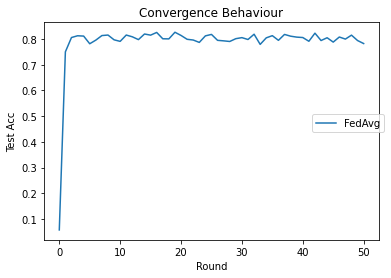

In [88]:
plot_convergence_behaviour(test_accs)

In [89]:
ultimate_aggr_model_y_preds = y_preds[-1]

In [90]:
aggr_model_precision_recall_fscore = precision_recall_fscore(y_test, ultimate_aggr_model_y_preds)

In [91]:
get_utility_measure_on_distributions(aggr_model_precision_recall_fscore, avg_local_model_precision_recall_fscore)

Distribution                              Precision        ... F1-score      
                                              Aggr. Local  ...    Aggr. Local
noniid-distribution-based-label-imbalance      0.66  0.52  ...     0.54  0.55

[1 rows x 6 columns]

# Label Distribution Skew: Quantity-based label imbalance

Each client owns data samples of a fixed subset of total labels. This is first introduced in [the experiments of FedAvg](https://arxiv.org/pdf/1602.05629.pdf), where each client is only assigned 2 subsets of the data, with different labels. Such a setting is also used in other studies, [here](https://arxiv.org/pdf/2004.10342.pdf) and [here](https://arxiv.org/pdf/1812.06127.pdf). [Here](https://arxiv.org/pdf/2004.10342.pdf)  a highly extreme case is considered, where each client only has data samples with a single label. We use a general partitioning strategy to set the number of labels that each client has; in the context of our study, this is either 1 or 2.

In [92]:
NUMBER_OF_CLIENTS = 2
MIN_AVAILABLE_CLIENTS = 2
NUMBER_OF_FL_ROUNDS = 1
LOCAL_EPOCHS = ceil(1500 / NUMBER_OF_FL_ROUNDS)
MIN_FIT_CLIENTS = 2
FRACTION_FIT = 1.0

In [93]:
# Overrides to global experiment config
DATA_PARTITIONING_STRATEGY = "noniid-quantity-based-label-imbalance2"

In [94]:
# Split train set into NUMBER_OF_CLIENTS partitions.
partitioned_train_set = get_partitions(X_train, y_train.to_numpy())

In [95]:
get_label_freqs(partitioned_train_set)

,y_train,client0,client1
0,1287,644,643
1,17270,0,17270
2,3747,3747,0


In [96]:
get_label_freqs(partitioned_train_set, relative=True)

,y_train,client0,client1
0,0.057703,0.146664,0.035896
1,0.774301,0.000000,0.964104
2,0.167997,0.853336,0.000000


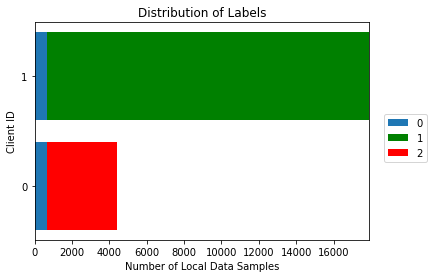

In [97]:
plot_distribution_of_labels(partitioned_train_set)

In [98]:
# Evaluate local models trained on local data
local_models_y_preds = evaluate_local_models(partitioned_train_set)

In [99]:
print(classification_report(y_test, local_models_y_preds[0]))

              precision    recall  f1-score   support

           0       0.08      0.77      0.15       143
           1       0.00      0.00      0.00      1920
           2       0.33      0.92      0.48       416

    accuracy                           0.20      2479
   macro avg       0.14      0.56      0.21      2479
weighted avg       0.06      0.20      0.09      2479



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
precision_recall_fscores_of_local_models = get_precision_recall_fscores_of_local_models(y_test, local_models_y_preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
avg_local_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_models)

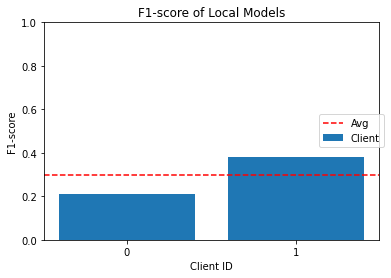

In [102]:
plot_performance_of_local_models(precision_recall_fscores_of_local_models, avg_local_model_precision_recall_fscore)

In [103]:
print_measures_of_dispersion(precision_recall_fscores_of_local_models)

Variance of F1-score across local models: 0.007212366413100272
Standard Deviation of F1-score across local models: 0.08492565226773517


In [104]:
# Run sim with global config
sim_results = run_sim(partitioned_train_set)

INFO flower 2022-02-12 23:13:49,708 | app.py:80 | Flower server running (insecure, 1 rounds)
INFO flower 2022-02-12 23:13:49,712 | server.py:118 | Initializing global parameters
INFO flower 2022-02-12 23:13:49,715 | server.py:304 | Requesting initial parameters from one random client


initializing Client0 with pid 18157


DEBUG flower 2022-02-12 23:13:51,726 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:13:51,729 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:13:51,730 | connection.py:36 | ChannelConnectivity.READY
INFO flower 2022-02-12 23:13:51,734 | server.py:307 | Received initial parameters from one random client
INFO flower 2022-02-12 23:13:51,736 | server.py:120 | Evaluating initial parameters


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.06      1.00      0.11       143
           1       0.00      0.00      0.00      1920
           2       0.00      0.00      0.00       416

    accuracy                           0.06      2479
   macro avg       0.02      0.33      0.04      2479
weighted avg       0.00      0.06      0.01      2479

Calculating probability estimates
Probability estimates: [[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 ...
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]
Calculating cross-entropy loss
Calculating the mean accuracy on the test data and labels
Finished centralized evaluation


INFO flower 2022-02-12 23:13:51,845 | server.py:127 | initial parameters (loss, other metrics): 1.0986122886681096, {'accuracy': 0.057684550221863654}
INFO flower 2022-02-12 23:13:51,850 | server.py:133 | FL starting


initializing Client1 with pid 18226


DEBUG flower 2022-02-12 23:13:52,745 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2022-02-12 23:13:52,748 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2022-02-12 23:13:52,748 | connection.py:36 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-02-12 23:13:52,749 | server.py:255 | fit_round: strategy sampled 2 clients (out of 2)
DEBUG flower 2022-02-12 23:13:52,751 | connection.py:36 | ChannelConnectivity.READY


Client1 with pid 18226 is sampled in rnd 1
Client0 with pid 18157 is sampled in rnd 1
Training finished for round 1
Training finished for round 1


DEBUG flower 2022-02-12 23:13:58,635 | server.py:264 | fit_round received 2 results and 0 failures


Beginning centralized evaluation
Updating aggregate model with the latest parameters
Class labels known to classifier: [0 1 2]
Predicting class labels for samples in X_test


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.19      0.74      0.31       143
           1       0.81      0.81      0.81      1920
           2       0.00      0.00      0.00       416

    accuracy                           0.67      2479
   macro avg       0.33      0.52      0.37      2479
weighted avg       0.64      0.67      0.65      2479

Calculating probability estimates
Probability estimates: [[1.49668115e-01 8.50331885e-01]
 [8.15594006e-05 9.99918441e-01]
 [7.45614514e-04 9.99254385e-01]
 ...
 [3.98340116e-03 9.96016599e-01]
 [2.19579705e-02 9.78042029e-01]
 [3.48479862e-03 9.96515201e-01]]
Calculating cross-entropy loss


Process Process-68:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-39-5164248b1a41>", line 38, in start_flower_server
    fl.server.start_server("0.0.0.0:80", server=server, config={"num_rounds": NUMBER_OF_FL_ROUNDS})
  File "/usr/local/lib/python3.7/dist-packages/flwr/server/app.py", line 86, in start_server
    force_final_distributed_eval=force_final_distributed_eval,
  File "/usr/local/lib/python3.7/dist-packages/flwr/server/app.py", line 118, in _fl
    hist = server.fit(num_rounds=config["num_rounds"])
  File "/usr/local/lib/python3.7/dist-packages/flwr/server/server.py", line 145, in fit
    res_cen = self.strategy.evaluate(parameters=self.parameters)
  File "/usr/local/lib/python3.7/dist-packages/flwr/server/strategy/fedavg.py", line 178, in evaluate
    eva

In [105]:
y_preds = sim_results["y_preds"]
test_accs = sim_results["test_accs"]

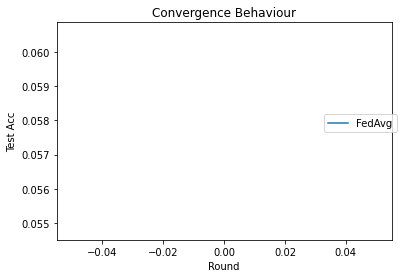

In [106]:
plot_convergence_behaviour(test_accs)

In [107]:
ultimate_aggr_model_y_preds = y_preds[-1]

In [108]:
aggr_model_precision_recall_fscore = precision_recall_fscore(y_test, ultimate_aggr_model_y_preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
get_utility_measure_on_distributions(aggr_model_precision_recall_fscore, avg_local_model_precision_recall_fscore)

Distribution                           Precision        ... F1-score      
                                           Aggr. Local  ...    Aggr. Local
noniid-quantity-based-label-imbalance2      0.33  0.24  ...     0.37   0.3

[1 rows x 6 columns]